# <center>BIG DATA ASSIGNMENT</center>

### The objective of analysis
Finding the optimal unit for zone feature in order to predict the transaction price of a residential real estate.
There are two measures of price: Transaction_price in currency and Price_per_Floor_area in currency/square meter. The second measures is better, as it aggregates two columns.

One of the challange of real estate valuation is the amount and quality of data.
The valuation is based on market sell/buy transactions, which globally are in huge amout, but locally not necessary. 
The transactons are spread in time. The prices changes in time depending on macro economics situation and local changes (better road or other , positive or negative).
The transaction prices forms outpu/target data. In order to use data from different periods of time the model of precise and correct trend regression shoul be applied in order to correct the prices by the changes in time. Trend may be different for piriods/time and for location and for the type of building/type of construction.
    
### The conditions/definitions of a real estate value
- RICS is a standard-setting body. Standars are availabel on their website:
https://www.rics.org/globalassets/rics-website/media/upholding-professional-standards/sector-standards/valuation/comparable-evidence-in-real-estate-valuation.pdf
- One of the approaches to real estate valuation is market approach: "This approach adopts the principle that the value of one property may be derived by comparing it directly with market transactions for similar properties. It is widely used in the valuation of residential, rural and commercial real estate and is sometimes used for the valuation of land and other real estate assets" (RICS)
- "Transactions in the open market close to the date of valuation will almost invariably provide the best and most reliable source of evidence. However, even in the most transparent markets, full details of sales and lettings are rarely publicly available. Real estate transactions are often complex, and the headline data alone rarely provide sufficient evidence, so it is vital to gain as much information as possible from each comparable transaction in order that it may be effectively applied to the asset being valued. The accuracy of published data should therefore be confirmed where possible and full details of reported transactions should be established. Valuers should ensure that full details of any incentives (such as rent-free periods, capital payments by either party or lease breaks) forming part of a comparable transaction are incorporated into the analysis of the evidence. Incentives are commonly offered in the case, for example, of new house sales or in retail or office lettings." (RICS)
- "The most probable price (in terms of money) which a property should bring in a competitive and open market under all conditions requisite to a fair sale, the buyer and seller each acting prudently and knowledgeably, and assuming the price is not affected by undue stimulus. Implicit in this definition is the consummation of a sale as of a specified date and the passing of title from seller to buyer under conditions whereby: the buyer and seller are typically motivated; both parties are well informed or well advised, and acting in what they consider their best interests; a reasonable time is allowed for exposure in the open market; payment is made in terms of cash in United States dollars or in terms of financial arrangements comparable thereto; and the price represents the normal consideration for the property sold unaffected by special or creative financing or sales concessions granted by anyone associated with the salec." (USPAP - Uniform Standards of Professional Appraisal Practice)

### Conclusions:
- the market transactions must be used to valuate a property. Market transaction is a transaction the buyer and seller are typically motivated.
- the best transactions are the one that are close to the date of valuation. The reason is that prices (values) change during time due to many factors: macro economics and local changes.

### Models to be used:
- Regression:
    - SVR
    - Decision Tree


# Steps in the project

### The KDD process was used iteratively:
1. Raw Data
2. Data Understanding
3. Data Preprocessing
4. Data Modeling
5. Validation & Interpretation
6. Knowledge (included in report)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import random
import math
import statistics

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

#from sklearn.cluster import KMeans

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Regression
from sklearn.svm import SVR
from scipy.stats import pearsonr

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor



Using TensorFlow backend.


### Helper functions for visualization

In [2]:
# Helper function to draw boxplot and histogram based on column name and print basic statistics

def plot_boxplot_histogram(df, column_name=''):
    df = df
    col_name = column_name
    # Data to plot
    data = df[col_name]
    mu = df[col_name].mean()  # mean of distribution
    sigma = df[col_name].std()  # standard deviation of distribution
    x = mu + sigma * np.random.randn(500)

    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(10, 4.5))
    
    # boxplot
    ax1.set_title('Boxplot')
    ax1.boxplot(data, flierprops=dict(markerfacecolor='g', marker='D'))
    # histogam
    ax2.set_title('Histogram: $\mu$={:.2f}, $\sigma$={:.2f}'.format(mu, sigma))
    n, bins, patches = ax2.hist(data, bins=50, density=1, histtype='bar', rwidth=1)
    # add a 'best fit' line to histogram
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
    np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    ax2.plot(bins, y, '-')

    # show figure
    #plt.title('Boxplot and histogram of ' + col_name) # add title
    plt.suptitle('Boxplot and histogram of ' + col_name)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
    
    pd.set_option('display.precision', 2)
    print(df[col_name].describe(percentiles = [.05, .25, .5, .75, .95]))
    pd.set_option('display.precision', 6)

            
def trim_axes(axes, N):
    axes = axes.flat # make it flat!!!
    for ax in axes[N:]:
        ax.remove()
    return axes[:N]
    
# @param df - DataFrame to be plotted
# @param column_names - names of column to be plotted. Enables to select some columns from DataFrame
def plot_boxplot_multi(df, column_names=None, ncol=4):
    df_local = df
    col_names = column_names
    if col_names == None:
        col_names = df_local.columns
    
    ncol = ncol
    nrow = math.ceil(len(col_names)/ncol)
    
    # Create figure and axes
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, sharex=False, sharey=False, figsize=(4*ncol, 3*nrow))

    # Remove unused axes and flat axes array
    axes = trim_axes(axes=axes, N=len(col_names))
    
    for i, c_name in enumerate(col_names):
        data = df_local[c_name]
        axes[i].set_title(c_name)
        axes[i].boxplot(data, flierprops=dict(markerfacecolor='g', marker='D'))
                
    # show figure
    #plt.title('Boxplot and histogram of ' + col_name) # add title
    plt.suptitle('Boxplots of columns')
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()    

def plot_boxplot_hist_multi(df, column_names=[], ncol=4):
    col_names = column_names
    df_local = df
    ncol = ncol
    nrow = (math.ceil(len(col_names)/ncol))*2
    
    # Create figure and axes
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, sharex=False, sharey=False, figsize=(4*ncol, 3*nrow))

    # Remove unused axes and flat axes array
    axes = trim_axes(axes=axes, N=len(col_names)*2)
    
    i = 0
    for c_name in col_names:
        data = df_local[c_name]
        
        mu = df_local[c_name].mean()  # mean of distribution
        sigma = df_local[c_name].std()  # standard deviation of distribution
        x = mu + sigma * np.random.randn(500)

        # boxplot
        axes[i].set_title(c_name)
        axes[i].boxplot(data, flierprops=dict(markerfacecolor='g', marker='D'))
        i += 1
        # histogam
        axes[i].set_title('Histogram:  $\mu$={:.2f}, $\sigma$={:.2f}'.format(mu, sigma))
        n, bins, patches = axes[i].hist(data, bins=50, density=True, histtype='bar', rwidth=1)
        # add a 'best fit' line to histogram
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
        np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        axes[i].plot(bins, y, '-')
        i += 1

                
    # show figure
    #plt.title('Boxplot and histogram of ' + col_name) # add title
    plt.suptitle('Boxplots of columns')
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()    

    
# Helper function: returns outliers (o1: outliers 1, o3: outliers 3) of the column as dataframe, plots boxplot and histogram of them and prints basic statistics
def get_plot_outliers_o1_o3(df, column_name='', plot=True):
    col_name = column_name
    df_local = df
    plot_data = plot

    # The way to determine outliers:
    # Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html
    # The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2).
    # The whiskers extend from the edges of box to show the range of the data.
    # The position of the whiskers is set by default to 1.5 * IQR (IQR = Q3 - Q1) from the edges of the box
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1

    labels_o1 = df_local[col_name] <= Q1 - 1.5 * IQR
    df_o1 = df_local.loc[labels_o1]
    data_o1 = df_o1[col_name]
    
    labels_o3 = df_local[col_name] >= Q3 + 1.5 * IQR
    df_o3 = df_local.loc[labels_o3]
    data_o3 = df_o3[col_name]
    
    # plot data
    if plot_data:
        # Create figure and axes
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(10, 4.5))
        ax1.set_title('O1 Boxplot')
        ax2.set_title('O1 Histogram')
        ax3.set_title('O3 Boxplot')
        ax4.set_title('O3 Histogram')

        if not len(df_o1.index) == 0:
            ax1.boxplot(data_o1, flierprops=dict(markerfacecolor='g', marker='D'))
            ax2.hist(data_o1, density=True, histtype='bar', rwidth=1)
        else:
            ax1.text(x=0.5, y=0.5, s='No outliers', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, bbox=dict(facecolor='green', alpha=0.5))
            ax2.text(x=0.5, y=0.5, s='No outliers', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, bbox=dict(facecolor='green', alpha=0.5))

        if not len(df_o3.index) == 0:
            ax3.boxplot(data_o3, flierprops=dict(markerfacecolor='g', marker='D'))
            ax4.hist(data_o3, density=True, histtype='bar', rwidth=0.9)
        else:
            ax3.text(x=0.5, y=0.5, s='No outliers', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes, bbox=dict(facecolor='green', alpha=0.5))
            ax4.text(x=0.5, y=0.5, s='No outliers', horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes, bbox=dict(facecolor='green', alpha=0.5))

        # show figure
        plt.suptitle('Boxplot and histogram of O1 and O3 outliers of ' + col_name)
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        plt.show()
    
    pd.set_option('display.precision', 2)
    print('Percent of O1 outliers: {:.2f}%'.format(len(df_o1.index)/len(df_local.index)*100))
    if not len(df_o1.index) == 0:
        print('O1 outliers statistics:\n{}'.format(data_o1.describe(percentiles=[])))
    print('Percent of O3 outliers: {:.2f}%'.format(len(df_o3.index)/len(df_local.index)*100))
    if not len(df_o3.index) == 0:
        print('O3 outliers statistics:\n{}'.format(data_o3.describe(percentiles=[])))
    pd.set_option('display.precision', 6)

    
    return df_o1, df_o3
    
    

# Plots scatter diagram and regression function to visualize data 
# @param s_X, s_Y - Series of data (Series because it pass name)
# @param kernel - It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
# @param s - marker size
def scatter_regression(s_X, s_Y, same_scale=False, figsize=(10, 10), s=3):
    x = s_X
    y = s_Y
    scale=same_scale
    figsize=figsize
    s=s
    
    # Calculate data for regression line
    X = x.values
    X = X.reshape(-1, 1)
#    X = X.flatten()
#    X = X.reshape(len(X),1)
    Y = y.values
    Y = Y.reshape(-1, 1)
    
    lr = LinearRegression()    
    lr.fit(X, Y)
    Y_predict = lr.predict(X)
    
    # plot data
    plt.figure(figsize=figsize)
    plt.scatter(X, Y, s=s) # s - marker size
    plt.plot(X, Y_predict, color='red')
    plt.title('Scatter Diagram and Regression')
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    # Set up x-axis and y-axis to have the same scale
    if scale:
        bottom, top = plt.ylim()
        left, right = plt.xlim()
        start = np.minimum(bottom, left)
        end = np.maximum(top, right)
        plt.ylim(start, end)
        plt.xlim(start, end)

    plt.show()



# Other Helper Functions

In [3]:
       
def display_percentage_of_nan(df, col_names):
    col_names = col_names
    pd.options.display.float_format = "{:,.2f}".format
    print('Percentage of nan values:')
    no_of_rows = len(df.index.values) # this is fast method (performance) of getting the number of rows
    print(100- df[col_names].count()/no_of_rows*100)
    pd.reset_option('display.float_format')
    
def get_O1_O3(df, col_name=''):
    col_name = col_name
    df = df

    # The way to determine outliers:
    # Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html
    # The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2).
    # The whiskers extend from the edges of box to show the range of the data.
    # The position of the whiskers is set by default to 1.5 * IQR (IQR = Q3 - Q1) from the edges of the box
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    
    O1 = Q1 - 1.5 * IQR
    O3 = Q3 + 1.5 * IQR
    
    return O1, O3


def smooth_price_by_time(periods):
    periods=periods
    
    for i in periods:
        start = i[0]
        end = i[1]

        # Calculate linear regression
        # Get data from given period of time
        # TODO: Do not take data that were smoothed already to calculate regression:
        # DONE: very simple way, should be corrected as it is not taking data equal to start ->  df[df['Time'] > start] 
        df_temp = df[df['Time'] > start][df['Time'] < end] # Get data from one year. 
        df_temp.reset_index(drop=False, inplace=True) # keep original index
        X = df_temp[['Time']]
        Y = df_temp['Price_per_Floor_area']
        lr = LinearRegression()  
        lr.fit(X, Y)
        # Linear regression parameters
        a = lr.coef_[0]
        b = lr.intercept_
        # Visualize linear regression
        scatter_regression(s_X=df_temp['Time'], s_Y=df_temp['Price_per_Floor_area'], same_scale=False, figsize=(8, 4), s=5)
        print('y = {}*x + {}'.format(round(a,2), round(b,2)))

        # Smooth data by using linear regression parameters
        # Smooth also the data that were smoothed in a previos loop
        df_temp = df[df['Time'] >= start][df['Time'] < end] # Get data from one year. 
        s = pd.Series(list(zip(df_temp['Time'], df_temp['Price_per_Floor_area'])))

        labels = ( df['Time'] >= start ) & ( df['Time'] < end )
        df.loc[labels, 'Price_per_Floor_area'] = s.transform(lambda x: x[1] + (end - x[0])*a)

        # Correct 'Time' value in smoothed data
        df.loc[labels, 'Time'] = end


# 1. Raw Data

### General information about the data
- The data contains information about residential real estate selling/buying transaction in Cracow that were made from 2010 until 2019
- Clause: due to data protection the analysed data do not contain important columns like a detailed address or detailed description of the transaction that would be normally available in case of commercial purpose. Both values could be usable for the paricular data analysis. Especially based on the detail address it is possible to receive more information about i.e. the exact location (distance from the main road, ect), the year of construction, number of storeys ect. From that reason it was decided to take into account the features that where available or that could be derived from other data with a high probability.

### Downloading data
- All data are in the 'data' folder and are in few files according to the year of transaction.

In [4]:
list_file = glob.glob('data/*.csv') # read filenames from the folder
list_df = [] # list of DataFrames
for file in list_file:
    df = pd.read_csv(file)
    list_df.append(df)
    
# Concatenate everything into a single DataFrame
df = pd.concat(list_df, ignore_index=True)

In [5]:
# Checking if the data were downloaded
df.head(1)

Transaction_date        Admin_district               Street  \
0       2010-12-31  Kraków - Śródmieście  Narzymskiego Józefa   

   Geodesic_precinct        Type_of_law Transaction_price  Floor_area  \
0                  5  własność-własność            159670       22.81   

   Other_area  Price_per_Floor_area            PCC Year_of_construction  \
0        3.31                7000.0  nie zapłacono                  NaN   

                           Short_description  Storey   Floor No_of_storeys  \
0  pokój:1,kuchnia:1,łazienka:1,przedpokój:1     1.0  parter           NaN   

  Standard_of_flat Type_of_other_area        Seller           Buyer  
0              NaN            piwnica  spółdzielnia  osoba fizyczna

In [6]:
df.tail(2)

Transaction_date     Admin_district      Street  Geodesic_precinct  \
59429       2019-01-02  Kraków - Podgórze  Turniejowa                 63   
59430       2019-01-02  Kraków - Podgórze    Topazowa                104   

             Type_of_law Transaction_price  Floor_area  Other_area  \
59429  własność-własność            268000       31.23         NaN   
59430  własność-własność            345000       73.60         NaN   

       Price_per_Floor_area        PCC Year_of_construction  \
59429               8581.49  zapłacono                  NaN   
59430               4687.50  zapłacono                  NaN   

                                       Short_description  Storey     Floor  \
59429  pokój z aneksem kuchennym:1,łazienka:1,przedpo...     4.0  3 piętro   
59430  pokój:3,kuchnia:1,łazienka z wc:1,wc:2,przedpo...     4.0       NaN   

      No_of_storeys Standard_of_flat Type_of_other_area          Seller  \
59429           NaN              NaN                NaN  osoba fizyczna   
59430           NaN              NaN                NaN  osoba fizyczna   

                Buyer  
59429  osoba fizyczna  
59430  osoba fizyczna

In [7]:
columns_to_drop = ['PCC'] # tax related, may be dropped
df.drop(columns=columns_to_drop, inplace=True)

# 2. Data Understanding

### General summary of the data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59431 entries, 0 to 59430
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Transaction_date      59431 non-null  object 
 1   Admin_district        59431 non-null  object 
 2   Street                59431 non-null  object 
 3   Geodesic_precinct     59431 non-null  int64  
 4   Type_of_law           59431 non-null  object 
 5   Transaction_price     59431 non-null  object 
 6   Floor_area            59385 non-null  float64
 7   Other_area            18489 non-null  float64
 8   Price_per_Floor_area  59404 non-null  float64
 9   Year_of_construction  20298 non-null  object 
 10  Short_description     57296 non-null  object 
 11  Storey                53455 non-null  float64
 12  Floor                 51003 non-null  object 
 13  No_of_storeys         9527 non-null   object 
 14  Standard_of_flat      7808 non-null   object 
 15  Type_of_other_area 

##### Conclusion:
Most of the data are object type. Only some of them are numeric type

In [9]:
display_percentage_of_nan(df=df, col_names=df.columns)

Percentage of nan values:
Transaction_date        0.00
Admin_district          0.00
Street                  0.00
Geodesic_precinct       0.00
Type_of_law             0.00
Transaction_price       0.00
Floor_area              0.08
Other_area             68.89
Price_per_Floor_area    0.05
Year_of_construction   65.85
Short_description       3.59
Storey                 10.06
Floor                  14.18
No_of_storeys          83.97
Standard_of_flat       86.86
Type_of_other_area     54.61
Seller                  0.11
Buyer                   0.11
dtype: float64


##### Conclusion
- There are complete data in the following columns: Transaction_date, Admin_district, Street, Geodesic_precinct, Type_of_law 
- There are less than 1% of missing values in the following columns: Transaction_price, Floor_area, Price_per_Floor_area, Seller, Buyer.
- There is 4% of missing values in Short_description
- There is around 10% missing values in the following columns: Storey, Floor
- There is more than 50% of missing values in the following columns: Other_area, Yera_of_construction, No_of_storeys, Standard_of_flat, Type_of_other_area

### Unique values in the data columns

In [10]:
# Checking the unique values in columns that may contain some specific words for the analyzed data
columns = df.columns

for value in columns:
    print('Column name: {}\nUnique values: {}\n'.format(value, df[value].unique()))

Column name: Transaction_date
Unique values: ['2010-12-31' '2010-12-30' '2010-12-29' ... '2019-01-04' '2019-01-03'
 '2019-01-02']

Column name: Admin_district
Unique values: ['Kraków - Śródmieście' 'Kraków - Krowodrza' 'Kraków - Podgórze'
 'Kraków - Nowa Huta']

Column name: Street
Unique values: ['Narzymskiego Józefa' 'Chełmońskiego Józefa' 'Mieczykowa' ... 'Rżącka'
 'Szaflarska' 'Falista']

Column name: Geodesic_precinct
Unique values: [  5  33  69   6  48  11  45   4  13  10   9  20 216   2  43  61  44   3
  15  19  12  22  29  28  42 145  34  16   7  49  50  32  57  55  54   8
  41 119 116  14  87  17  93  52  53  35  47  65  63  31  56  46 105   1
  23  62  30  59  51  21  60  40  58 118 120 104  90  25  92  18 146 101
  99  67  68 100  97  86  64 103  88  74 110  85  84  36 106  81  79  75
  37  38  73  71]

Column name: Type_of_law
Unique values: ['własność-własność' 'spółdzielcze wł. prawo' 'własność-u.wieczyste'
 '67/129' '208/5' '165/4' '229/6' '176' '196/4' '272/10' '286' '2

##### Conclusion
The meaning of the above values was consulting with the expert in real estate valuation:
- some data may be used to fill in missing values in other columns
- some data may be used to create more appropriate feature containing numeric values
- some data are redundant

In [11]:
# The columns Admin_district and Geodesic_precinct relates to the geospatial data
# Testing if the same value of Geodesic_precinct appears for different values of Admin_district.
# If it is both columns must be used altogether
for value in df['Geodesic_precinct']:
    if df['Admin_district'][df['Geodesic_precinct'] == value].unique().size > 1:
        print('Conclusion')
        print('The same value of Geodesic_precinct appears for different values of Admin_district')
        print('It means that both columns depend on each other.')
        break

Conclusion
The same value of Geodesic_precinct appears for different values of Admin_district
It means that both columns depend on each other.


# Description and explanation of columns names:

The data refer to selling/buying transactions of a real estate in Cracow in Poland from 2010 to 2019.
The type of real estate is flat: a self-contained housing unit that occupies only part of a building.
Definition of flat from Oxford Dictionary: "A set of rooms forming an individual residence, typically on one floor and within a larger building containing a number of such residences."
Definition of flat from RICS (The Royal Institution of Chartered Surveyors) website: "A flat is a separate and self-contained premise constructed or adapted for use for residential purposes and forming part of a building from some other part of which it is divided horizontally. Flats have to be contained within a dwelling with at least two storeys."

### Other explanations and definitions:
- geospatial data: There are many ways of spatial divisions in Poland. One of the offical division is geodetic. Cadastral parcel is the smalles region. The geodesic precinct precinct is the next level of spatial division containing many of cadastral parcels. (source: https://stat.gov.pl/en/metainformations/glossary/terms-used-in-official-statistics/1738,term.html). The administrative district is the next level of spatial division containing many of geodesic precinct.
- There are two types of flat ownership in Poland: cooperative law ('spoldzielcze prawo') and ownership ('wlasnosc'). The cooperative law is very similar to ownership – it includes right of possession, usage and disposal. The right is transferrable, inheritable and enforceable. It was widely used between 1945 - 1990 (comunism period).
- The difference between storey and flat:  #TODO


### There are following columns in the dataset:
- Transaction_date: (data type: object) a date of a selling/buying transaction of a flat. 
- Admin_district: (data type: object) geospatial data - the name of an administrative district; Cracov is divided on 4 main and large administrativ districts: 'Krowodrza', 'Srodmiescie', 'Podgorze', 'Nowa Huta'
- Street: (data type: object) geospatial data - a name of a street
- Geodesic_precinct: (data type: number) geospatial data - a name of a geodesic precinct. The unit extracted of the country area for register of lands and buildings purpose.
- Type_of_law: (data type: object) a type of law to the real estate that is an object of transaction - cooperative law or ownership.
- Transaction_price: (data type: object) a price of a selling/buying transaction of a flat in PLN currency
- Floor_area: (data type: number) a size of a flat in square meters
- Other_area: (data type: number) a size of an additional area, besides the size of a flat. Typical additional area is a part of a celler in a building, that the owner can use on it's own purpose.
- Price_per_Floor_area: (data type: number) a Transaction price divided by a Floor_area. The unit of measure is: PLN currency/square meter rounded to two decimal places.
- Year_of_construction: (data type: object) a year of a construction of a building
- Short_description: (data type: object) a short description of a flat, containing information about the number of rooms, open/close kitchen, number of bathrooms, seperate toilet from the bathroom, corridor
- Storey: (data type: number) a storey on which a flat is located
- Floor: (data type: object) a floor on which a flat is located
- No_of_storeys: (data type: object) a number of storyes in a building
- Standard_of_flat: (data type: object) a standard/condition of a flat
- Type_of_other_area: (data type: object) an information about a type of other area being sold altogether with a flat in the same transaction.
- Seller: (data type: object) an information of a type of person according to te law (natural person, legal person - private or public) 
- Buyer: (data type: object) an information of a type of person according to te law (natural person, legal person - private or public)


## Other information about data:

The way of inserting the data into data base guarantees the data are not duplicated. There is no need to check for duplicates.


# 3. Data Preprocessing

## Feature: Transaction_price

### Data Transformation: Feature encoding

#### Changing the type of data: column Transaction_price
The column Transaction_price should be a numeric (type of float). It was decided to change the type of data aready at this stage of data analysis to avoid the situation, where the data are not convertible to numeric type.

In [12]:
df['Transaction_price'] = pd.to_numeric(arg=df['Transaction_price'], errors='coerce', downcast=None)
df['Transaction_price'].dtypes

dtype('float64')

In [13]:
display_percentage_of_nan(df=df, col_names=['Transaction_price'])

Percentage of nan values:
Transaction_price   0.08
dtype: float64


## Feature: Transaction_date

### Data Transformation: Feature encoding

#### Changing the type of data: column Transaction_date
The column Transaction_date should be a datetime type.

In [14]:
# Convert Transaction_date data type from object to datetime
df['Transaction_date'] = pd.to_datetime(df['Transaction_date'], infer_datetime_format=True, errors='coerce')

In [15]:
display_percentage_of_nan(df=df, col_names=['Transaction_date'])

Percentage of nan values:
Transaction_date   0.00
dtype: float64


## Instances

### Data Reduction: Removing irrelevant instances
Removing irrelevant instances containing non-market transactions based on feature Seller or Buyer.

Based on expert knowledge non-market transactions must be removed as they are irrelevant for the objective of the data analysis.

The easiest way to track such transactions is to check the sides (Buyer/Seller) of a transaction.
The following Sellers usually offer a special conditions to transacions for Buyers: 'syndyk', 'gmina', 'partia, stowarzyszenie, związek', 'komornik', 'Skarb Państwa', 'likwidator', 'kościół, związek wyznaniowy'

The following Buyers usually receive a special conditions to transacions from Sellers: 'Skarb Państwa', 'partia, stowarzyszenie, związek', 'najemca', 'województwo', 'kościół, związek wyznaniowy', 'dzierżawca'

In [16]:
seller_type_to_drop = [ 'syndyk', 'gmina', 'partia, stowarzyszenie, związek', 'komornik', 'Skarb Państwa',
                       'likwidator', 'kościół, związek wyznaniowy']
for value in seller_type_to_drop:
    indices = df[df['Seller'] == value].index
    df.drop(indices, inplace=True)

In [17]:
buyer_type_to_drop = [ 'Skarb Państwa', 'partia, stowarzyszenie, związek', 'najemca', 'województwo', 
                      'kościół, związek wyznaniowy', 'dzierżawca']
for value in seller_type_to_drop:
    indices = df[df['Buyer'] == value].index
    df.drop(indices, inplace=True)
    
# IMPORTANT! Reset index/labes after droping instances
df.reset_index(drop=True, inplace=True)

## Feature: Transaction_price, Floor_area

### Data Cleaning: Filling in missing data
The data of Transaction_price and Floor_area are crucial for the particular data analysis. There is more data in Price_per_Floor_area than in Transaction_price and Floor_area.
- The values of Transaction_price may be derived from multiplying Floor_area by Price_per_Floor_area.
- The values of Floor_area may be derived from deviding Transaction_price by Price_per_Floor_area.

In [18]:
index = df['Transaction_price'].isna()
df.loc[index, 'Transaction_price'] = df['Floor_area']*df['Price_per_Floor_area']

In [19]:
index = df['Floor_area'].isna()
df.loc[index, 'Floor_area'] = df['Transaction_price']/df['Price_per_Floor_area']

### Data Reduction: Removing instances containing nan value
The instances having missing values in the Transaction_price or the Floor_area column will be droped.

Reasoning: those data are crucial and must be correct; there is a small amout of missing values in those columns (less than 1%).

In [20]:
df.dropna(subset=['Transaction_price', 'Floor_area'], inplace=True)

In [21]:
display_percentage_of_nan(df=df, col_names=['Transaction_price', 'Floor_area'])

Percentage of nan values:
Transaction_price   0.00
Floor_area          0.00
dtype: float64


## Feature: Floor_area

#### Data investigation

In [22]:
df[['Floor_area']].describe()

Floor_area
count   58788.000000
mean       56.542868
std      1266.759325
min         1.000000
25%        36.770000
50%        47.680000
75%        59.370000
max    307000.000000

In [23]:
# The max and min Floor_area must be investigated in details, as they may be incorrect data (mistakes made during creating the data)
df[df['Floor_area'] == df['Floor_area'].max()]

Transaction_date      Admin_district            Street  \
56384       2019-06-14  Kraków - Nowa Huta  Morcinka Gustawa   

       Geodesic_precinct        Type_of_law  Transaction_price  Floor_area  \
56384                  4  własność-własność              49.14    307000.0   

       Other_area  Price_per_Floor_area Year_of_construction  \
56384       13.05                   0.0                  NaN   

                                       Short_description  Storey     Floor  \
56384  pokój:1,pokój z aneksem kuchennym:1,łazienka z...     2.0  1 piętro   

      No_of_storeys Standard_of_flat                     Type_of_other_area  \
56384           NaN              NaN  KOMÓRKA LOKATORSKA, miejsce postojowe   

          Seller           Buyer  
56384  deweloper  osoba fizyczna

In [24]:
df[df['Floor_area'] == df['Floor_area'].min()]

Transaction_date      Admin_district        Street  Geodesic_precinct  \
32394       2015-02-03  Kraków - Krowodrza  Lea Juliusza                  4   
32415       2015-02-02  Kraków - Krowodrza  Lea Juliusza                  4   
32755       2015-01-14  Kraków - Krowodrza  Lea Juliusza                  4   
32803       2015-01-12  Kraków - Krowodrza  Lea Juliusza                  4   

             Type_of_law  Transaction_price  Floor_area  Other_area  \
32394  własność-własność          1273000.0         1.0         NaN   
32415  własność-własność          1100000.0         1.0         NaN   
32755  własność-własność           445000.0         1.0         NaN   
32803  własność-własność           420000.0         1.0         NaN   

       Price_per_Floor_area Year_of_construction Short_description  Storey  \
32394             1273000.0                  NaN               NaN     2.0   
32415             1100000.0                  NaN               NaN     2.0   
32755              445000.0                  NaN               NaN     1.0   
32803              420000.0                  NaN               NaN     1.0   

          Floor No_of_storeys Standard_of_flat Type_of_other_area  \
32394  1 piętro           NaN              NaN                NaN   
32415  1 piętro           NaN              NaN                NaN   
32755    parter           NaN              NaN                NaN   
32803    parter           NaN              NaN                NaN   

                       Seller                          Buyer  
32394  przeds., spółka, firma  osoba fizyczna przedsiębiorca  
32415          osoba fizyczna         przeds., spółka, firma  
32755  przeds., spółka, firma         przeds., spółka, firma  
32803          osoba fizyczna         przeds., spółka, firma

##### Conclusion to Floor_area
Instances having min and max values of floor are incorrect. The mean is 56.66. Hovewer, the standard deviation is 1260. 50% of all values are between 36 and 59.
Based on expertise it was decided to remove all instances which Floor_area value is less than 15 or greater than 300, as those instances do not satisfy the definition of market transaction. Such transactions are exceptional.

### Data Reduction: Removing instances

In [25]:
# Create Series of data to be removed (Series has the same labels/indices as DataFrame)
s = df['Floor_area'][ ( (df['Floor_area'] < 15) | (df['Floor_area'] > 300) ) ]
labels = s.index # Get indices
df.drop(labels=labels, inplace=True)

# Reset index/labes after droping instances
df.reset_index(drop=True, inplace=True)

In [26]:
df[['Floor_area']].describe()

Floor_area
count  58656.000000
mean      51.023237
std       21.685382
min       15.000000
25%       36.810000
50%       47.700000
75%       59.400000
max      296.000000

In [27]:
display_percentage_of_nan(df=df, col_names=['Floor_area'])

Percentage of nan values:
Floor_area   0.00
dtype: float64


## Feature: Year_of_construction

### Data Cleaning: Filling in missing data
Some values may be derived from data in other columns:
- Seller: if a Seller is legal person or a natural person acting as developer it means that it was a residential property development company, hence it is a new construction. The year of transaction is the year of construction.
- Type_of_law: the cooperative law was popular from 1970 until 1990. It means that buildings were build in that period.
- Street: (TODO explanation)
- Admin_district and Geodesic_precinct: i.e. most of the buildings in central location of a city were build before 1945 (expertise knowledge)

It was decided to use approximation of a Year_of_construction, ie. for building constructed between 1970-1990 the approximation is 1980.

In [28]:
# Use values from Seller column
df['Seller'].unique()

array(['spółdzielnia', 'osoba fizyczna', 'deweloper',
       'spółka prawa handlowego', 'przeds., spółka, firma',
       'osoba fizyczna przedsiębiorca', 'osoba-jedn. zagraniczna', nan,
       'spółka cywilna', 'wspólnota gruntowa, mieszkaniowa'], dtype=object)

In [29]:
seller_developer = ['deweloper', 'spółka prawa handlowego', 'przeds., spółka, firma', 
                       'osoba fizyczna przedsiębiorca', 'osoba-jedn. zagraniczna', 'spółka cywilna']
for value in seller_developer:
    index = ( df['Year_of_construction'].isna() ) & ( df['Seller'] == value )
    df.loc[index, 'Year_of_construction'] = df['Transaction_date'].dt.year

In [30]:
# Using values from Type_of_law column
df['Type_of_law'].unique()

array(['własność-własność', 'spółdzielcze wł. prawo',
       'własność-u.wieczyste'], dtype=object)

In [31]:
cooperative_law = ['spółdzielcze wł. prawo']
for value in cooperative_law:
    index = ( df['Year_of_construction'].isna() ) & ( df['Type_of_law'] == value )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1970, high=1989, size=len(s_temp.index)) # 1980  approximation; value based on expertise knowledge

In [32]:
# Using values from Admin_district and Geodesic_precinct
data = df['Geodesic_precinct'][df['Admin_district'] == 'Kraków - Śródmieście'].unique()
data.sort()
data

array([  1,   2,   3,   4,   5,   6,   7,   8,  11,  12,  13,  14,  15,
        16,  17,  21,  22,  23,  50,  51,  52,  53,  59,  60,  61,  62,
       116, 118, 119, 120, 145, 146, 216], dtype=int64)

In [33]:
# [1,2,3,4,5,6,7,8,11,12,13,14,15,16,17,21,22,23,50,51,52,53,59,60,61,62,116,118,119,120,145,146,216]
geo_region = [1,2,3,11,12,13,14,15,50,51,52,53,59,60,61,62,116,118,119,120,145,146,216]
for value in geo_region:
    index = ( df['Year_of_construction'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Śródmieście' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1890, high=1939, size=len(s_temp.index)) # 1920 approximation; value based on expertise knowledge

In [34]:
# Helper function to find a correct name of the street
def find_street(name):
    street = df['Street'].unique()
    street.sort()
    street = pd.Series(street)
    print(street[street.str.contains(name, case=False, regex=False)])
    
find_street('pszona')

844    Pszona Mieczysława
dtype: object


In [35]:
street = ['Kantora Tadeusza']
for value in street:
    index = ( df['Year_of_construction'].isna() ) & ( df['Street'] == value ) & ( df['Admin_district'] == 'Kraków - Śródmieście' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1945, high=1969, size=len(s_temp.index)) # 1960 approximation; value based on expertise knowledge

In [36]:
street = ['Nuszkiewicza Ryszarda Majora', 'Kwartowa', 'Rezedowa', 'Fiołkowa', 'Pszona Mieczysława']
for value in street:
    index = ( df['Year_of_construction'].isna() ) & ( df['Street'] == value ) & ( df['Admin_district'] == 'Kraków - Śródmieście' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1991, high=2010, size=len(s_temp.index)) # 2000 approximation; value based on expertise knowledge

In [37]:
geo_region = [17]
for value in geo_region:
    index = ( df['Year_of_construction'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Śródmieście' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1945, high=1969, size=len(s_temp.index)) # 1960 approximation; value based on expertise knowledge

In [38]:
geo_region = [4,5,6,7,8,16,21,22,23]
for value in geo_region:
    index = ( df['Year_of_construction'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Śródmieście' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1970, high=1989, size=len(s_temp.index)) # 1980 approximation; value based on expertise knowledge

In [39]:
data = df['Geodesic_precinct'][df['Admin_district'] == 'Kraków - Nowa Huta'].unique()
data.sort()
data

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 18, 32, 36, 44, 45,
       47, 48, 49, 50, 51, 52, 54, 58], dtype=int64)

In [40]:
# [1,2,3,4,5,6,7,8,9,10,11,12,18,32,36,44,45,47,48,49,50,51,52,54,58]
geo_region = [45,47,48,50,51]
for value in geo_region:
    index = ( df['Year_of_construction'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Nowa Huta' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1945, high=1969, size=len(s_temp.index)) # approximation; value based on expertise knowledge

In [41]:
geo_region = [1,2,3,4,5,6,7,8,9,10,11,12,18,32,36,44,49]
for value in geo_region:
    index = ( df['Year_of_construction'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Nowa Huta' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1970, high=1989, size=len(s_temp.index)) # approximation; value based on expertise knowledge

In [42]:
geo_region = [52,54,58]
for value in geo_region:
    index = ( df['Year_of_construction'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Nowa Huta' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1991, high=2010, size=len(s_temp.index)) # approximation; value based on expertise knowledge

In [43]:
# 'Admin_district' = 'Kraków - Podgórze'
data = df['Geodesic_precinct'][df['Admin_district'] == 'Kraków - Podgórze'].unique()
data.sort()
data

array([  3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  25,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  40,  41,  42,  43,  44,  46,  47,  48,  49,
        50,  51,  52,  53,  55,  56,  57,  58,  60,  61,  62,  63,  64,
        65,  67,  68,  69,  71,  73,  74,  75,  79,  81,  84,  85,  86,
        87,  88,  90,  92,  93,  97,  99, 100, 101, 103, 104, 105, 106,
       110], dtype=int64)

In [44]:
# [3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,25,28,29,30,31,32,33,34,35,36,37,38,40,41,42,43,44,46,47,48,49,50,51,52,
# 53,55,56,57,58,60,61,62,63,64,65,67,68,69,71,73,74,75,79,81,84,85,86,87,88,90,92,93,97,99,100,101,103,104,105, 106,110]

geo_region=[10,12,13,14,15]
for value in geo_region:
    index = ( df['Year_of_construction'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Podgórze' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1890, high=1939, size=len(s_temp.index)) # 1920 approximation; value based on expertise knowledge

In [45]:
geo_region=[11,31,34,48,49,50,51,52,53,55,56,57,58,60,61]
for value in geo_region:
    index = ( df['Year_of_construction'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Podgórze' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1970, high=1989, size=len(s_temp.index)) # approximation; value based on expertise knowledge

In [46]:
geo_region=[3,4,5,7,8,9,16,17,18,19,20,21,25,28,29,30,32,33,35,36,37,38,40,41,42,43,44,46,47,62,63,64,65,67,68,69,71,73,74,75,79,81,84,85,86,87,88,90,92,93,97,99,100,101,103,104,105,106,110]
for value in geo_region:
    index = ( df['Year_of_construction'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Podgórze' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1991, high=2010, size=len(s_temp.index)) # approximation; value based on expertise knowledge

In [47]:
# 'Admin_district' = 'Kraków - Krowodrza'
data = df['Geodesic_precinct'][df['Admin_district'] == 'Kraków - Krowodrza'].unique()
data.sort()
data

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 17, 19, 20,
       21, 23, 25, 28, 29, 30, 31, 32, 33, 34, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 51, 52, 53], dtype=int64)

In [48]:
geo_region = [4,12,13,14,45,46]
for value in geo_region:
    index = ( df['Year_of_construction'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Krowodrza' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1945, high=1969, size=len(s_temp.index)) # approximation; value based on expertise knowledge

In [49]:
geo_region = [2,3,6,41,42,43,44]
for value in geo_region:
    index = ( df['Year_of_construction'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Krowodrza' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1970, high=1989, size=len(s_temp.index)) # approximation; value based on expertise knowledge

In [50]:
geo_region = [1,5,7,8,9,10,11,17,19,20,21,23,25,28,29,30,31,32,33,34,40,47,48,49,51,52,53]
for value in geo_region:
    index = ( df['Year_of_construction'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Krowodrza' )
    s_temp = index[index == True]
    df.loc[index, 'Year_of_construction'] = np.random.randint(1991, high=2010, size=len(s_temp.index)) # approximation; value based on expertise knowledge

In [51]:
display_percentage_of_nan(df=df, col_names=['Year_of_construction'])

Percentage of nan values:
Year_of_construction   0.00
dtype: float64


## Feature: Storey, Floor

### Data Cleaning: Filling in missing data
- Storey: may be derived from the Floor column
- Floor: may be derived from the Storey column

Beforhand both columns need to be inspected and Floor data type should be converted from object to float data type.

#### Inspecting values in column Storey and Floor

In [52]:
# Inspecing Storey column
data = df['Storey'].unique()
data.sort()
np.set_printoptions(precision=2, suppress=True) # default 8
data

array([ -2.  ,  -1.1 ,  -1.  ,  -0.2 ,   0.  ,   0.1 ,   0.5 ,   1.  ,
         1.2 ,   1.3 ,   2.  ,   2.3 ,   3.  ,   3.13,   3.4 ,   3.5 ,
         4.  ,   4.5 ,   5.  ,   5.6 ,   6.  ,   6.7 ,   7.  ,   7.8 ,
         8.  ,   9.  ,  10.  ,  10.11,  11.  ,  12.  ,  13.  ,  13.14,
        14.  ,  14.15,  15.  ,  16.  ,  17.  , 123.  , 321.  ,    nan])

In [53]:
inspect = [-2., -1.1, -1., -0.2, 0.1, 0.5, 1.2, 1.3, 2.3, 3.13, 3.4, 3.5, 4.5, 5.6, 6.7, 7.8, 10.11, 13.14, 14.15, 123., 321.]

for value in inspect:
    print(df[['Floor', 'Storey', 'Short_description']][df['Storey'] == value].head(1))

      Floor  Storey                                 Short_description
37688   NaN    -2.0  pokój:2,aneks kuchenny:1,łazienka:1,przedpokój:1
          Floor  Storey                                  Short_description
46335  suterena    -1.1  pokój:2,pokój z aneksem kuchennym:1,łazienka:1...
         Floor  Storey                    Short_description
5631  suterena    -1.0  pokój:1,aneks kuchenny:1,łazienka:1
        Floor  Storey                                 Short_description
28352  parter    -0.2  pokój:4,aneks kuchenny:1,łazienka:2,przedpokój:3
          Floor  Storey                                  Short_description
19874  1 piętro     0.1  pokój:2,kuchnia:1,łazienka:1,przedpokój:1,kory...
      Floor  Storey                                  Short_description
58471   NaN     0.5  pokój z aneksem kuchennym:1,łazienka:1,przedpo...
       Floor  Storey                               Short_description
1319  parter     1.2  pokój:4,kuchnia:1,łazienka:1,wc:1,przedpokój:3
      Floor  Sto

In [54]:
# It was decided to set few unusual values to nan
storey = [-2., -1.1, -0.2, 0.1, 0.5, 1.3, 3.13, 3.5, 123., 321.]
for value in storey:
    index = df['Storey'] == value
    df.loc[index, 'Storey'] = np.nan

In [55]:
# The data with the pattern i.e. 1.2, 3.4 discribe a two level flat.
# It was decided to change data to more meaningfull by leaving only the lower storey
storey = [1.2, 2.3, 3.4, 4.5, 5.6, 6.7, 7.8, 10.11, 13.14, 14.15]
for value in storey:
    index = df['Storey'] == value
    df.loc[index, 'Storey'] = int(value) # Converts from float to int with loosing precision

In [56]:
# Inspecting Floor column
data = df['Floor'].unique()
data

array(['parter', 'powyżej 5 piętra', '2 piętro', '1 piętro', '3 piętro',
       '4 piętro', '5 piętro', nan, 'nie podano', 'poddasze',
       'przyziemie', 'suterena', 'piwnica', '4'], dtype=object)

#### Data Reduction: Removing instances

In [57]:
# Drop unrelevant instances
indices = df[df['Floor'] == 'piwnica'].index
df.drop(indices, inplace=True)

# Reset index/labes after droping instances
df.reset_index(drop=True, inplace=True)

In [58]:
# It was decided to change data to more meaningfull by leaving only the lower storey
index = df['Floor'] == 'nie podano'
df.loc[index, 'Floor'] = np.nan

index = df['Floor'] == 'parter'
df.loc[index, 'Floor'] = 0

index = ( df['Floor'] == 'powyżej 5 piętra' ) | ( df['Floor'] == 'poddasze' )
df.loc[index, 'Floor'] = 6

index = ( df['Floor'] == 'suterena' ) | (df['Floor'] == 'przyziemie')
df.loc[index, 'Floor'] = -1

for value in np.arange(1, 6, 1):
    index = ( df['Floor'].notna() ) & ( df['Floor'].str.contains(str(value) + ' piętro') )
    df.loc[index, 'Floor'] = value

In [59]:
# Inspecting values
data = df['Floor'].unique()
data

array([0, 6, 2, 1, 3, 4, 5, nan, -1, '4'], dtype=object)

In [60]:
# Convertint object data type to float data type
df['Floor'] = pd.to_numeric(arg=df['Floor'], errors='coerce', downcast=None)
df['Floor'].dtypes

dtype('float64')

#### Filling in missing values in Storey and Floor column

In [61]:
# Fill in missing values in Storey column based on values in Floor column
data = df['Floor'].unique()
for value in data:
    index = ( df['Storey'].isna() ) & ( df['Floor'] == value )
    df.loc[index, 'Storey'] = value-1

In [62]:
# Filling in missing values in Floor column
data = df['Storey'].unique()
for value in data:
    index = ( df['Floor'].isna() ) & ( df['Storey'] == value )
    df.loc[index, 'Floor'] = value+1

In [63]:
display_percentage_of_nan(df=df, col_names=['Storey', 'Floor'])

Percentage of nan values:
Storey   3.38
Floor    3.38
dtype: float64


## Feature: No_of_storeys

### Data Cleaning: Filling in missing data
The data of No_of_storeys may be determined based on:
- Floor or Storey: if a Floor is greater than 4 or Storey is greater than 5 it means that the building is a tall building
- Admin_district and Geodesic_precinct: There are many areas in Cracove for which it is posibble to determine a high of a building based on expertise knowledge, ie. most of the buildings in central location of a city are short buildings.

In [64]:
df['No_of_storeys'].unique()

array([nan, 11.0, 8.0, 6.0, 3.0, 7.0, 5.0, 4.0, 4.5, 3.5, 9.0, 12.0, 5.5,
       2.0, 6.5, 10.0, 2.5, 1.5, '5', '11', '4', '2', '6', '7', '3', '9',
       '3.5', '8', '4.5', '12', '6.5', '2.5', '1', '10', '5.5', '1.5',
       14.0, 13.0, 1.0, 17.0, 16.0, '17', '16', '13', '14', '15',
       '3 piętro'], dtype=object)

In [65]:
labels = df['No_of_storeys'] == '3 piętro' 
df.loc[labels, 'No_of_storeys'] = 3

In [66]:

labels = ( df['No_of_storeys'].isna() ) & ( ( df['Floor'] > 4 ) | ( df['Storey'] > 5 ) )
df.loc[labels, 'No_of_storeys'] = 10

geo_region = [1,2,3,11,12,13,14,15,50,51,52,53,59,60,61,62,116,118,119,120,145,146,216]
for value in geo_region:
    labels = ( df['No_of_storeys'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Śródmieście' )
    df.loc[labels, 'No_of_storeys'] = 5 # approximation; value based on expertise knowledge

geo_region=[10,12,13,14,15]
for value in geo_region:
    labels = ( df['No_of_storeys'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Podgórze' )
    df.loc[labels, 'No_of_storeys'] = 5 # approximation; value based on expertise knowledge
    
geo_region = [45,47,48,50,51]
for value in geo_region:
    labels = ( df['No_of_storeys'].isna() ) & ( df['Geodesic_precinct'] == value ) & ( df['Admin_district'] == 'Kraków - Nowa Huta' )
    df.loc[labels, 'No_of_storeys'] = 5 # approximation; value based on expertise knowledge

In [67]:
# Convert datatype to number
df['No_of_storeys'] = pd.to_numeric(arg=df['No_of_storeys'], errors='coerce', downcast=None)
df['No_of_storeys'].dtypes

dtype('float64')

In [68]:
display_percentage_of_nan(df=df, col_names=['No_of_storeys'])

Percentage of nan values:
No_of_storeys   57.10
dtype: float64


## Feature: Year_of_construction
The values in Year_of_construction column must be investigated before filling up values in Standard_of_flat column

#### Inspecting data

In [69]:
# Inspecting values
df['Year_of_construction'].unique()

array([1973, 1979, 2002, 1988, 1981, 1987, 'lata 2000-2009', 2010,
       'lata 2010-2019', 1977, 1985, 1903, 1893, 1930, 1971, 1978, 1975,
       1963, 2009, 'przedwojenny', 1982, 1951, 1980, 1983, 1966, 1984,
       1972, 1976, 1961, 1994, 1970, 1986, 1974, 1960, 1954, 2003, 2006,
       1999, 1991, 'lata 50-te', 1965, 1997, 1937, 1998, 1947, 1906, 1925,
       1949, 2001, 1956, 1892, 'lata 60-te', 1952, 1992,
       'przed rokiem 1900', 1964, 1946, 1968, 1958, 'lata 90-te', 1948,
       1924, 1995, 1955, 1996, 2008, 'lata 80-te', 1959, 1950, 1929, 1901,
       2007, 1895, 'lata 40-te', 1957, 1931, 1953, 1891, 'lata 70-te',
       2004, 1967, 1911, 1907, 2005, 1945, 1993, 1898, 1915, 1913, 1909,
       1962, 2000, 1897, 1932, 1920, 1935, 1908, 1917, 1904, 1923, 1902,
       1938, 1916, 1896, 1900, 1912, 1910, 1927, 1894, 1905, 1928, 1922,
       1919, 1936, 1918, 1899, 1934, 1926, 1890, 2011, 1914, 1921, 1933,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2020, 2019], dtype=object

##### Conclusion
- there are few string type values denoting a period of time (i.e. 80's)
It was decided to convert those data to random number from the corresponding period.

In [70]:
# ['przedwojenny',  'przed rokiem 1900', 'lata 2000-2009', 'lata 2010-2019',
# 'lata 40-te', 'lata 50-te', 'lata 60-te', 'lata 70-te', 'lata 80-te', 'lata 90-te']

labels = ( df['Year_of_construction'].notna() ) & (( df['Year_of_construction'] == 'przedwojenny' ) | ( df['Year_of_construction'] == 'przed rokiem 1900' ) )
s_temp = labels[labels == True]
df.loc[labels, 'Year_of_construction'] = np.random.randint(1900, high=1945, size=len(s_temp.index))

labels = ( df['Year_of_construction'].notna() ) & ( df['Year_of_construction'] == 'lata 2000-2009' )
s_temp = labels[labels == True]
df.loc[labels, 'Year_of_construction'] = np.random.randint(2000, high=2009, size=len(s_temp.index))

labels = ( df['Year_of_construction'].notna() ) & ( df['Year_of_construction'] == 'lata 2010-2019' )
s_temp = labels[labels == True]
df.loc[labels, 'Year_of_construction'] = np.random.randint(2010, high=2019, size=len(s_temp.index))

for value in np.arange(40, 100, 10):
    labels = ( df['Year_of_construction'].notna() ) & ( df['Year_of_construction'].str.contains('lata ' + str(value) + '-te') )
    s_temp = labels[labels == True]
    df.loc[labels, 'Year_of_construction'] = np.random.randint(int(value) + 1900, high=(int(value) + 1910), size=len(s_temp.index))

In [71]:
# Converting data types to int
df['Year_of_construction'] = pd.to_numeric(arg=df['Year_of_construction'], errors='coerce', downcast=None)
df['Year_of_construction'].dtypes

dtype('int64')

In [72]:
display_percentage_of_nan(df=df, col_names='Year_of_construction')

Percentage of nan values:
0.0


## Feature: Standard_of_flat
The data of Standard_of_flat are crucial for the particular data analysis. 

In [73]:
# Checking unique values
df['Standard_of_flat'].unique()

array([nan, 'bardzo dobry', 'do remontu', 'do remontu kapitalnego',
       'dostateczny', 'dobry', 'do bieżącej konserwacji'], dtype=object)

### Data Cleaning: Smoothing-out NoisyData: Binning -> transforming from object type to numeric type (categories)
There are 6 different values. However, some values have similar meaning.
It was decided to group values into 3 categories:
- 'bardzo dobry' (meaning: 'good'):1
- 'dobry', 'do bieżącej konserwacji' (meaning: 'middle'):2
- 'do remontu', 'do remontu kapitalnego', 'dostateczny' (meaning: flats that require refurbishment/fit out):3

In [74]:
dict_standar_of_flat = {'bardzo dobry':1, # 'very good'
                        'dobry':2, 'do bieżącej konserwacji':2, # 'middle'
                        'do remontu':3, 'do remontu kapitalnego':3, 'dostateczny':3 # 'to refurbishment'
                       }

for key, value in dict_standar_of_flat.items():
    labels = df['Standard_of_flat'] == key
    df.loc[labels, 'Standard_of_flat'] = value

### Data Cleaning:Filling in missing data based on criteria from other features
Based on expert knowledge the data may be derived from the Seller or Year_of_construction.
- Seller:
    - 3 (to refurbishment/fit out) - Flats sold by developers (primary market) are usually sold as 'shell and core'. They require fit out works
- Year_of_construction:
    - 1 (very good) - flats located in buildings constructed after 1990 usually have very good standard;
    - 2 (niddle) - flats in building between 1970-1990 usually have middle standard; 
    - 3 (to refurbishment/fit out) - other flats usually require refurbishment. If a flat has very bad or very good condition it is usually mentioned in contract for some legal purposes (ie. tax). 

In [75]:
# Fill in missing values based on Seller feature
dict_standar_of_flat['shell and core']=3

# 'shell and core' standard
seller_developer = ['deweloper', 'spółka prawa handlowego', 'przeds., spółka, firma', 
                       'osoba fizyczna przedsiębiorca', 'osoba-jedn. zagraniczna', 'spółka cywilna']
for value in seller_developer:
    index = ( df['Standard_of_flat'].isna() ) & ( df['Seller'] == value )
    df.loc[index, 'Standard_of_flat'] = 3

In [76]:
# Filling in missing values based on data derived from Year_of_construction column
index = ( df['Standard_of_flat'].isna() ) & ( df['Year_of_construction'] < 1945 )
df.loc[index, 'Standard_of_flat'] = 3 # 'bad'

index = ( df['Standard_of_flat'].isna() ) & ( df['Year_of_construction'] >= 1945 ) & ( df['Year_of_construction'] < 1990 )
df.loc[index, 'Standard_of_flat'] = 2 #'middle'

index = ( df['Standard_of_flat'].isna() ) & ( df['Year_of_construction'] >= 1990 )
df.loc[index, 'Standard_of_flat'] = 1 #'very good'

In [77]:
# Converting data type from object to int
df['Standard_of_flat'] = pd.to_numeric(arg=df['Standard_of_flat'], errors='coerce', downcast=None)
df['Standard_of_flat'].dtypes

dtype('int64')

In [78]:
display_percentage_of_nan(df=df, col_names=['Standard_of_flat'])

Percentage of nan values:
Standard_of_flat   0.00
dtype: float64


## Feature: Admin_district, Geodesic_precinct -> Location

### Data Transformation: Feature construction: 
It was decided to create feature Location (type number) based on Admin_district and Geodesic_precinct: the data in the Geodesic_precinct column are connected with the data in Admin_district column, ie. for the same value of Geodesic_precinct there may be 4 options of Admin_district: 'Kraków - Śródmieście', 'Kraków - Nowa Huta', 'Kraków - Podgórze', 'Kraków - Krowodrza'. The dictionary will be created, where the key is a tuple of Admin_district and Geodesic_precinct and the value is the unique int number. Based on that dictionary the Location values will be propagated.

In [79]:
# TODO: try pivot and then build the dictionary from indices

# Create list of tupels by zipping values from Admin_district and Geodesic_precinct
zip_data = list(zip(df['Admin_district'], df['Geodesic_precinct']))
s = pd.Series(zip_data)
unique_data = s.unique()
# Create Series to sort data
s = pd.Series(unique_data)
s.sort_values(inplace=True)
# Reset index, start index from 1
#s.index = pd.RangeIndex(start=1, stop=len(s) + 1, step=1)
# create df with 'Location'
df_location_dict = pd.DataFrame(s.values.tolist(), columns=['Admin_district', 'Geodesic_precinct'])

location = range(1, len(df_location_dict) + 1)
# inserting new column to DataFrame
s = pd.Series(location, dtype='int')
df_location_dict.insert(loc=len(df_location_dict.columns), column='Location', value=s)
#df_location_dict.to_csv('df_location_dict.csv', index=False)

In [80]:
# create column Location and add values
s = pd.Series(np.zeros(len(df), dtype='int'))
# Insert column after 'Geodesic_precinct'
loc = np.nonzero(df.columns.to_numpy() == 'Geodesic_precinct')
loc = int(loc[0][0]) + 1
df.insert(loc, 'Location', s)

# Assign correct values based on df_location_dict
for label, content in df_location_dict.iterrows():
    index = ( df['Admin_district'] == content['Admin_district'] ) & (df['Geodesic_precinct'] == content['Geodesic_precinct'] )
    df.loc[index, 'Location'] = content['Location']

# Convert data type to int
#df['Location'] = pd.to_numeric(arg=df['Location'], errors='coerce', downcast='integer')
# Test conversion
df['Location'].dtype

dtype('int32')

In [81]:
df.head(1)

Transaction_date        Admin_district               Street  \
0       2010-12-31  Kraków - Śródmieście  Narzymskiego Józefa   

   Geodesic_precinct  Location        Type_of_law  Transaction_price  \
0                  5       149  własność-własność           159670.0   

   Floor_area  Other_area  Price_per_Floor_area  Year_of_construction  \
0       22.81        3.31                7000.0                  1973   

                           Short_description  Storey  Floor  No_of_storeys  \
0  pokój:1,kuchnia:1,łazienka:1,przedpokój:1     1.0    0.0            NaN   

   Standard_of_flat Type_of_other_area        Seller           Buyer  
0                 2            piwnica  spółdzielnia  osoba fizyczna

## Feature: Short_description -> Number_of_rooms, Kitchen_separate,	Number_of_bathrooms,	WC,	Wardrobe_room,	Storage_room

### Data Transformation: Feature construction
Creating columns based on Short_description:
- Number_of_rooms
- Kitchen_separate
- Number_of_bathrooms
- WC
- Wardrobe_room
- Storage_room

In [82]:
# Get unique values from Short_description
data = df['Short_description'].unique()
data = pd.Series(data)
data.dropna(inplace=True)
data

0               pokój:1,kuchnia:1,łazienka:1,przedpokój:1
1        pokój:1,aneks kuchenny:1,łazienka:1,przedpokój:1
2               pokój:2,kuchnia:1,łazienka:1,przedpokój:1
3          pokój:4,kuchnia:1,łazienka:1,wc:1,przedpokój:1
4               pokój:3,kuchnia:1,łazienka:1,przedpokój:1
                              ...                        
2042    pokój:1,pokój z aneksem kuchennym:1,pomieszcze...
2043    pokój:4,pokój z aneksem kuchennym:1,łazienka:2...
2044    pokój:3,kuchnia:1,łazienka:2,wc:1,przedpokój:1...
2045    pokój:3,kuchnia:1,łazienka:2,wc:2,przedpokój:2...
2046    pokój:3,kuchnia:1,łazienka z wc:1,wc:2,przedpo...
Length: 2046, dtype: object

##### Conclusion: the data in Short_description column are key:value data separated by comma
Next step: create DataFrame based on data in Short_description column wher:
- keys from Short_description data will be the name of columns
- indices will be the same as main DataFrame 'df'

In [83]:
# Get kyes from values in Short_description column

# Helper function
# Converts data in Short_description from string to dictionary
def convert_to_dict(short_desc=''):
    temp_dict={}

    temp_list = short_desc.split(',')
    for i, v in enumerate(temp_list):
        other_list = v.split(':')
        temp_dict[other_list[0]] = int(other_list[1])
        
    return temp_dict

In [84]:
dict_keys = {}

for index, value in data.items():
    temp_dict = convert_to_dict(short_desc=value)
    
    for key in iter(temp_dict):
        if key not in dict_keys:
            dict_keys[key] = np.full((len(df.index)), np.nan)

In [85]:
# Reset indices in df DataFrame (many instances were removed). It is needed to keep consistency with df_sd DataFrame
df.reset_index(drop=True, inplace=True)

# Create DataFrame from short description (sd) data 
df_sd = pd.DataFrame(dict_keys)
df_sd.head(1)

pokój  kuchnia  łazienka  przedpokój  aneks kuchenny  wc  garderoba  \
0    NaN      NaN       NaN         NaN             NaN NaN        NaN   

   pomieszczenie gospodarcze  ciemna kuchnia  spiżarka  ...  \
0                        NaN             NaN       NaN  ...   

   pokój z aneksem kuchennym  pomieszczenie biurowe  magazyn  garaż  \
0                        NaN                    NaN      NaN    NaN   

   sala sprzedaży  korytarz  pomieszczenie usługowe  wc na półpiętrze  \
0             NaN       NaN                     NaN               NaN   

   przynależności  pomieszczenie socjalne  
0             NaN                     NaN  

[1 rows x 23 columns]

In [86]:
# Groupby df by Short_description, get indices, 
# create temp_dict based on grouped data, insert data to the df_short_description
df_grouped = df.groupby(['Short_description'])

In [87]:
for key, value in df_grouped.indices.items():
    temp_dict = convert_to_dict(key)
    
    for temp_k, temp_v in temp_dict.items():
        # Select rows and column from df_sd
        labels = value # label(s) or a boolean array, may be Series of boolean (boolean array must be the same length as DataFrame, hence Series of booleans must be the lengts as df)
        df_sd.loc[labels, temp_k] = temp_v # loc() accepts a list or array of labels as well as Series 
    

In [88]:
df_sd.head(1)

pokój  kuchnia  łazienka  przedpokój  aneks kuchenny  wc  garderoba  \
0    1.0      1.0       1.0         1.0             NaN NaN        NaN   

   pomieszczenie gospodarcze  ciemna kuchnia  spiżarka  ...  \
0                        NaN             NaN       NaN  ...   

   pokój z aneksem kuchennym  pomieszczenie biurowe  magazyn  garaż  \
0                        NaN                    NaN      NaN    NaN   

   sala sprzedaży  korytarz  pomieszczenie usługowe  wc na półpiętrze  \
0             NaN       NaN                     NaN               NaN   

   przynależności  pomieszczenie socjalne  
0             NaN                     NaN  

[1 rows x 23 columns]

In [89]:
# TEST
# Expected: Test passed: True
labels = random.sample(range(0, len(df.index)), 10)
for label in labels:
    test_pass = True
    
#    print('Label: {}'.format(label))
    # print data from df based on label
    df_string = df.loc[label, 'Short_description']
#    print(df_string)
    
    # print data from df_sd based on label
    s = df_sd.loc[label].dropna()
    for l, v in s.items():
        temp_str = l + ':' + str(int(v))
        
        if not temp_str in df_string:
            test_pass = False
        
#        print(temp_str)
        
    print('Test passed: {}'.format(test_pass))

Test passed: True
Test passed: True
Test passed: True
Test passed: True
Test passed: True
Test passed: True
Test passed: True
Test passed: True
Test passed: True
Test passed: True


In [90]:
# Investigate data in df_sd
df_sd.shape

(58638, 23)

In [91]:
df_sd.columns

Index(['pokój', 'kuchnia', 'łazienka', 'przedpokój', 'aneks kuchenny', 'wc',
       'garderoba', 'pomieszczenie gospodarcze', 'ciemna kuchnia', 'spiżarka',
       'nyża', 'antresola', 'łazienka z wc', 'pokój z aneksem kuchennym',
       'pomieszczenie biurowe', 'magazyn', 'garaż', 'sala sprzedaży',
       'korytarz', 'pomieszczenie usługowe', 'wc na półpiętrze',
       'przynależności', 'pomieszczenie socjalne'],
      dtype='object')

In [92]:
df_sd.count()

pokój                        54322
kuchnia                      32122
łazienka                     49367
przedpokój                   51980
aneks kuchenny               12685
wc                           10601
garderoba                     3483
pomieszczenie gospodarcze     1640
ciemna kuchnia                1310
spiżarka                      1004
nyża                           143
antresola                      245
łazienka z wc                 6113
pokój z aneksem kuchennym     9783
pomieszczenie biurowe           12
magazyn                         25
garaż                           79
sala sprzedaży                  18
korytarz                       578
pomieszczenie usługowe          14
wc na półpiętrze                 2
przynależności                  10
pomieszczenie socjalne           2
dtype: int64

In [93]:
display_percentage_of_nan(df=df, col_names=['Short_description'])
display_percentage_of_nan(df=df_sd, col_names=df_sd.columns)

Percentage of nan values:
Short_description   3.48
dtype: float64
Percentage of nan values:
pokój                         7.36
kuchnia                      45.22
łazienka                     15.81
przedpokój                   11.35
aneks kuchenny               78.37
wc                           81.92
garderoba                    94.06
pomieszczenie gospodarcze    97.20
ciemna kuchnia               97.77
spiżarka                     98.29
nyża                         99.76
antresola                    99.58
łazienka z wc                89.58
pokój z aneksem kuchennym    83.32
pomieszczenie biurowe        99.98
magazyn                      99.96
garaż                        99.87
sala sprzedaży               99.97
korytarz                     99.01
pomieszczenie usługowe       99.98
wc na półpiętrze            100.00
przynależności               99.98
pomieszczenie socjalne      100.00
dtype: float64


##### Conclusion:
definition: room - 'a part or division of a building enclosed by walls, floor, and ceiling'

- 96% of data are available in Short_description column, which is good. It means that only 4% of data do not contain short description.
- many data in df_sd DataFrame appear very seldom (belowe 1% cases). It means that flats with those type of rooms are rare on the market. May not be taken into account as not being typical.

#### Data Reduction of df_ds DataFrame
#### Dropping of columns that have rare values

In [94]:
# Create Series where index is the name of df_sd column and the value is the count() of values
no_of_rows = len(df_sd.index)
s = df_sd.count()/no_of_rows*100
 # Create list of columns to be dropped
columns = s[s<1].index
# Drop columns
df_sd.drop(columns=columns, inplace=True)

#### Continue investigation of df_sd

In [95]:
df_sd.columns

Index(['pokój', 'kuchnia', 'łazienka', 'przedpokój', 'aneks kuchenny', 'wc',
       'garderoba', 'pomieszczenie gospodarcze', 'ciemna kuchnia', 'spiżarka',
       'łazienka z wc', 'pokój z aneksem kuchennym'],
      dtype='object')

##### Conclusion:
Few columns have similar meaning and may be joined:
- 'pokój z aneksem kuchennym' - it means: room that is connected with the kitchen. The room may be bedroom or living room, or what is common in polish residential estate market, may have both functions. For that reason it may be devided into 'pokój' (bedroom/living room) and 'aneks kuchenny' (open kitchen).
- 'łazienka' and 'łazienka z wc' (meaning: bathroom) have very similar functionality and may be joined
- 'pomieszczenie gospodarcze' and 'spiżarka' (meaning: utility room / storage room) have similar functionality and may be joined
- new column may be created with boolean values. Column name 'Kitchen_separate', values: True/False. False if 'aneks kuchenny', 'ciemna kuchnia', 'pokój z aneksem kuchennym' (meaning: open kitchen to the living room), True if 'kuchnia' (meaning: separate kitchen)

The other column will be droped as they do not have important functions

In [96]:
# Investigate data
df_sd[['pokój z aneksem kuchennym', 'ciemna kuchnia', 'łazienka z wc' ]].describe()

pokój z aneksem kuchennym  ciemna kuchnia  łazienka z wc
count                9783.000000          1310.0    6113.000000
mean                    1.002147             1.0       1.019303
std                     0.054406             0.0       0.142276
min                     0.000000             1.0       0.000000
25%                     1.000000             1.0       1.000000
50%                     1.000000             1.0       1.000000
75%                     1.000000             1.0       1.000000
max                     2.000000             1.0       3.000000

In [97]:
# add values from columns to other column

df_sd['pokój'] = df_sd['pokój'].add(df_sd['pokój z aneksem kuchennym'], fill_value=0)

df_sd['łazienka'] = df_sd['łazienka'].add(df_sd['łazienka z wc'], fill_value=0)

df_sd['pomieszczenie gospodarcze'] = df_sd['pomieszczenie gospodarcze'].add(df_sd['spiżarka'], fill_value=0)

In [98]:
df_sd.head()

pokój  kuchnia  łazienka  przedpokój  aneks kuchenny   wc  garderoba  \
0    1.0      1.0       1.0         1.0             NaN  NaN        NaN   
1    1.0      NaN       1.0         1.0             1.0  NaN        NaN   
2    2.0      1.0       1.0         1.0             NaN  NaN        NaN   
3    2.0      1.0       1.0         1.0             NaN  NaN        NaN   
4    4.0      1.0       1.0         1.0             NaN  1.0        NaN   

   pomieszczenie gospodarcze  ciemna kuchnia  spiżarka  łazienka z wc  \
0                        NaN             NaN       NaN            NaN   
1                        NaN             NaN       NaN            NaN   
2                        NaN             NaN       NaN            NaN   
3                        NaN             NaN       NaN            NaN   
4                        NaN             NaN       NaN            NaN   

   pokój z aneksem kuchennym  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN

#### Feature construction: creating column Kitchen_separate (type boolean) based on 'aneks kuchenny' and 'kuchnia' column

In [99]:
# creating column Kitchen_separate and add values
arr = np.full((len(df_sd.index)), np.nan) # Create array (nan value) with size equal to the number of rows (using index is probably faster way)
# inserting new column to DataFrame
s = pd.Series(arr, dtype='float32') # TODO problem with np.nan, should be boolean type
df_sd.insert(1, 'Kitchen_separate', s)

# At first insert False represented by 0 if kitchen is not separate
labels = ( ( df_sd['aneks kuchenny'] > 0 ) | ( df_sd['ciemna kuchnia'] > 0 ) | ( df_sd['pokój z aneksem kuchennym'] > 0 ) )
df_sd.loc[labels, 'Kitchen_separate'] = 0

# Next insert True represented by 1 if kitchen is separate (may override False value, which is expected)
labels = df_sd['kuchnia'] > 0
df_sd.loc[labels, 'Kitchen_separate'] = 1


#### Data Reduction
Remove irrelevant or already exploited columns from df_ds DataFrame

In [100]:
# TODO: decide if drop or not the following columns: 'przedpokój', 'wc', 'garderoba', 'pomieszczenie gospodarcze'

columns_to_drop = ['pokój z aneksem kuchennym', 'ciemna kuchnia', 'łazienka z wc', 'spiżarka', 'przedpokój', 'kuchnia', 'aneks kuchenny']
df_sd.drop(columns=columns_to_drop, inplace=True)

In [101]:
df_sd.rename(columns={'pokój': 'Number_of_rooms', 'łazienka': 'Number_of_bathrooms', 'wc': 'WC', 'garderoba': 'Wardrobe_room', 'pomieszczenie gospodarcze': 'Storage_room' }, inplace=True)

In [102]:
df_sd.head(1)

Number_of_rooms  Kitchen_separate  Number_of_bathrooms  WC  Wardrobe_room  \
0              1.0               1.0                  1.0 NaN            NaN   

   Storage_room  
0           NaN

In [103]:
display_percentage_of_nan(df=df, col_names=['Short_description'])

display_percentage_of_nan(df=df_sd, col_names=df_sd.columns)

Percentage of nan values:
Short_description   3.48
dtype: float64
Percentage of nan values:
Number_of_rooms        3.55
Kitchen_separate       5.10
Number_of_bathrooms    5.46
WC                    81.92
Wardrobe_room         94.06
Storage_room          95.70
dtype: float64


In [104]:
# Fill in nan values with 0 if there was a short description of the flat
columns = df_sd.columns
for column in columns:
    labels = ( df['Short_description'].notna() ) & ( df_sd[column].isna() )
    df_sd.loc[labels, column] = 0

In [105]:
display_percentage_of_nan(df=df_sd, col_names=df_sd.columns)

Percentage of nan values:
Number_of_rooms       3.48
Kitchen_separate      3.48
Number_of_bathrooms   3.48
WC                    3.48
Wardrobe_room         3.48
Storage_room          3.48
dtype: float64


#### Joining df_sd to df DataFrame

In [106]:
# Test if both DataFrames have equal length
# Expected: True, as no rows were removed from df_sd.
# Labels were not reset in df_sd after taking data from df and labels were reset in df before the data were taken by df_sd
len(df.index) == len(df_sd.index)

True

In [107]:
df = df.join(df_sd)
df.head(1)

Transaction_date        Admin_district               Street  \
0       2010-12-31  Kraków - Śródmieście  Narzymskiego Józefa   

   Geodesic_precinct  Location        Type_of_law  Transaction_price  \
0                  5       149  własność-własność           159670.0   

   Floor_area  Other_area  Price_per_Floor_area  ...  Standard_of_flat  \
0       22.81        3.31                7000.0  ...                 2   

  Type_of_other_area        Seller           Buyer  Number_of_rooms  \
0            piwnica  spółdzielnia  osoba fizyczna              1.0   

   Kitchen_separate Number_of_bathrooms   WC Wardrobe_room  Storage_room  
0               1.0                 1.0  0.0           0.0           0.0  

[1 rows x 25 columns]

## Feature: Year_of_construction_class

### Data Transformation: Feature construction
Creating column Year_of_construction_class (type number) based on Year_of_construction; 5 groups (dictionary):
- 1: constructions build after 2010
- 2: constructions build between 1990 - 2010
- 3: constructions build between 1970 - 1990
- 4: constructions build between 1945 - 1970
- 5: constructions build before 1945

In [108]:
# TODO: MAYBE LEAVE IT FOR MACHINE LEARNING!!!!

# creating new column and adding values
arr = np.full((len(df_sd.index)), np.nan)
# inserting new column to DataFrame
s = pd.Series(arr, dtype='float32') # TODO problem with np.nan, should be boolean type
loc = np.nonzero(df.columns.to_numpy() == 'Year_of_construction')
loc = int(loc[0][0]) + 1
df.insert(loc, 'Year_of_construction_class', s)

labels = df['Year_of_construction'] >= 2010
df.loc[labels, 'Year_of_construction_class'] = 1

labels = ( (df['Year_of_construction'] >= 1990) & (df['Year_of_construction'] < 2010) )
df.loc[labels, 'Year_of_construction_class'] = 2

labels = ( (df['Year_of_construction'] >= 1970) & (df['Year_of_construction'] < 1990) )
df.loc[labels, 'Year_of_construction_class'] = 3

labels = ( (df['Year_of_construction'] >= 1945) & (df['Year_of_construction'] < 1970) )
df.loc[labels, 'Year_of_construction_class'] = 4
    
labels = df['Year_of_construction'] < 1945
df.loc[labels, 'Year_of_construction_class'] = 5



In [109]:
display_percentage_of_nan(df=df, col_names=['Year_of_construction_class'])

Percentage of nan values:
Year_of_construction_class   0.00
dtype: float64


## Feature: Time

### Data Transformation: Feature construction
Creating column Time (type number) based on Transaction_date.
### Data Cleaning: Data Binning
The feature Time uses month as a measurment. It starts form 1 which represents the min Transaction_date. Data are 

In [110]:
# creating new column and adding values
arr = np.full((len(df.index)), 0)
# inserting new column to DataFrame
s = pd.Series(arr, dtype='int32')
loc = np.nonzero(df.columns.to_numpy() == 'Transaction_date')
loc = int(loc[0][0]) + 1
df.insert(loc, 'Year', s)

df['Year'] = df['Transaction_date'].dt.year

# creating new column and adding values
arr = np.full((len(df.index)), 0)
# inserting new column to DataFrame
s = pd.Series(arr, dtype='int32')
loc = np.nonzero(df.columns.to_numpy() == 'Transaction_date')
loc = int(loc[0][0]) + 1
df.insert(loc, 'Month', s)
df['Month'] = df['Transaction_date'].dt.month

In [111]:
# creating new column and adding values
arr = np.full((len(df.index)), 0)
# inserting new column to DataFrame
s = pd.Series(arr, dtype='int32')
loc = np.nonzero(df.columns.to_numpy() == 'Transaction_date')
loc = int(loc[0][0]) + 1
df.insert(loc, 'Time', s)

min_year = df['Year'].min()
min_month = df['Month'][df['Year'] == min_year].min()

max_year = df['Year'].max()
max_month = df['Month'][df['Year'] == max_year].max()

number_of_months = (max_year - min_year) * 12 - min_month + max_month + 1

data = np.arange(1, number_of_months + 1, 1) # Start from 1, not 0

# Initialize starting year and month, increment them appropriately
year = min_year    
month = min_month

for value in data:
    # print('Year: {}, Month: {} , value: {}'.format(year, month, value))  # TEST

    labels = ( df['Year'] == year ) & ( df['Month'] == month )
    df.loc[labels, 'Time'] = value
    
    # increment year and month
    month += 1
    
    if value%12 == 0:
        year += 1
        month = 1 # reset month

In [112]:
df.sort_values(by=['Year', 'Month'], inplace=True)
df.head()

Transaction_date  Time  Month  Year        Admin_district  \
4746       2010-01-30     1      1  2010    Kraków - Krowodrza   
4747       2010-01-30     1      1  2010    Kraków - Krowodrza   
4748       2010-01-29     1      1  2010  Kraków - Śródmieście   
4749       2010-01-29     1      1  2010  Kraków - Śródmieście   
4750       2010-01-29     1      1  2010    Kraków - Nowa Huta   

                  Street  Geodesic_precinct  Location             Type_of_law  \
4746              Siewna                 43        31  spółdzielcze wł. prawo   
4747              Siewna                 43        31  spółdzielcze wł. prawo   
4748  Miechowity Macieja                 23       162    własność-u.wieczyste   
4749           Strzelców                 22       161  spółdzielcze wł. prawo   
4750             Szkolne                 45        57    własność-u.wieczyste   

      Transaction_price  ...  Standard_of_flat  Type_of_other_area  \
4746           180000.0  ...                 2             piwnica   
4747           180000.0  ...                 2             piwnica   
4748           336000.0  ...                 2                 NaN   
4749           210000.0  ...                 2             piwnica   
4750           145000.0  ...                 2             piwnica   

              Seller           Buyer  Number_of_rooms Kitchen_separate  \
4746  osoba fizyczna  osoba fizyczna              1.0              1.0   
4747  osoba fizyczna  osoba fizyczna              1.0              1.0   
4748  osoba fizyczna  osoba fizyczna              2.0              1.0   
4749  osoba fizyczna  osoba fizyczna              1.0              1.0   
4750  osoba fizyczna  osoba fizyczna              1.0              1.0   

      Number_of_bathrooms   WC  Wardrobe_room  Storage_room  
4746                  1.0  0.0            0.0           0.0  
4747                  1.0  0.0            0.0           0.0  
4748                  1.0  0.0            0.0           0.0  
4749                  1.0  0.0            0.0           0.0  
4750                  1.0  0.0            0.0           0.0  

[5 rows x 29 columns]

In [113]:
df.tail()

Transaction_date  Time  Month  Year        Admin_district  \
54927       2020-01-08   121      1  2020  Kraków - Śródmieście   
54928       2020-01-07   121      1  2020    Kraków - Krowodrza   
54929       2020-01-02   121      1  2020  Kraków - Śródmieście   
54910       2020-02-06   122      2  2020  Kraków - Śródmieście   
54909       2020-03-03   123      3  2020    Kraków - Nowa Huta   

                    Street  Geodesic_precinct  Location  \
54927          Na Barciach                 22       161   
54928              Opolska                 44        32   
54929  Łepkowskiego Józefa                 22       161   
54910               Reduta                 22       161   
54909   Bohaterów Września                  2        42   

                  Type_of_law  Transaction_price  ...  Standard_of_flat  \
54927       własność-własność           300000.0  ...                 1   
54928  spółdzielcze wł. prawo           320000.0  ...                 2   
54929       własność-własność           380000.0  ...                 1   
54910    własność-u.wieczyste           430000.0  ...                 2   
54909  spółdzielcze wł. prawo           268000.0  ...                 2   

       Type_of_other_area          Seller                          Buyer  \
54927                 NaN  osoba fizyczna                 osoba fizyczna   
54928             piwnica  osoba fizyczna                 osoba fizyczna   
54929                 NaN  osoba fizyczna                 osoba fizyczna   
54910  komórka lokatorska  osoba fizyczna  osoba fizyczna przedsiębiorca   
54909             piwnica  osoba fizyczna                 osoba fizyczna   

       Number_of_rooms Kitchen_separate  Number_of_bathrooms   WC  \
54927              2.0              0.0                  1.0  0.0   
54928              3.0              1.0                  1.0  1.0   
54929              2.0              0.0                  1.0  0.0   
54910              2.0              1.0                  1.0  0.0   
54909              2.0              1.0                  1.0  0.0   

       Wardrobe_room  Storage_room  
54927            0.0           0.0  
54928            0.0           0.0  
54929            0.0           0.0  
54910            0.0           0.0  
54909            0.0           0.0  

[5 rows x 29 columns]

## Feature: Market_type

### Data Transformation: Feature construction
Creating column Market_type (type boolean) on Seller where:
- 1 means primary market
- 0 means secondary based 

The primary market consists of new properties, which include new launches and ongoing projects from the developer. The secondary market is made up of secondary or sub-sale properties, previously owned houses.

In [114]:
# creating new column and adding values
arr = np.full((len(df.index)), 0)
# inserting new column to DataFrame
s = pd.Series(arr)
loc = np.nonzero(df.columns.to_numpy() == 'Seller')
loc = int(loc[0][0]) + 1
df.insert(loc, 'Market_type', s)

seller_developer = ['deweloper', 'spółka prawa handlowego', 'przeds., spółka, firma', 
                       'osoba fizyczna przedsiębiorca', 'osoba-jedn. zagraniczna', 'spółka cywilna']
for value in seller_developer:
    labels = df['Seller'] == value
    df.loc[labels, 'Market_type'] = 1


## Feature: Buyer, Seller, Other_area, Type_of_other_area

### Data Reduction: Feature selection
Based on the information received from the expert in real estate valuation, the following columns are irrelevant for the purpuse of the particular data analysis and may be removed from data frame after being used in the process of deriving other data:
- Buyer and Seller: it just one of the side of transaction
- Other_area and Type_of_other_area: it is not relevent for the value of the flat. If it was a garage it was a seperate real estate adn was sell for a separate price. The price was not included in a flat transaction price. Other usual spaces are a cellar, usually in old buildings, small space and usually in bad condition and security (dump, rats, thefts). They were popular in 60's - 80's but at the moment they usage is minor, usually for storing valueless things.

In [115]:
columns_to_drop = ['Other_area', 'Type_of_other_area', 'Seller','Buyer']
df.drop(columns=columns_to_drop, inplace=True)

## Data investigation

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58638 entries, 4746 to 54909
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Transaction_date            58638 non-null  datetime64[ns]
 1   Time                        58638 non-null  int64         
 2   Month                       58638 non-null  int64         
 3   Year                        58638 non-null  int64         
 4   Admin_district              58638 non-null  object        
 5   Street                      58638 non-null  object        
 6   Geodesic_precinct           58638 non-null  int64         
 7   Location                    58638 non-null  int32         
 8   Type_of_law                 58638 non-null  object        
 9   Transaction_price           58638 non-null  float64       
 10  Floor_area                  58638 non-null  float64       
 11  Price_per_Floor_area        58638 non-null  float64

## Feature: 'Transaction_date', 'Year', 'Month', 'Street', 'Type_of_law', 'Short_description', 'Storey'

### Data Reduction: Feature selection
Data from the following columns are in other features, so they can be removed: 'Transaction_date', 'Year', 'Month', 'Street', 'Type_of_law', 'Short_description', 'Storey': 

In [117]:
columns_to_drop = ['Transaction_date', 'Year', 'Month', 'Street', 'Type_of_law', 'Short_description', 'Storey']
df.drop(columns=columns_to_drop, inplace=True)

In [118]:
display_percentage_of_nan(df=df, col_names=df.columns)

Percentage of nan values:
Time                          0.00
Admin_district                0.00
Geodesic_precinct             0.00
Location                      0.00
Transaction_price             0.00
Floor_area                    0.00
Price_per_Floor_area          0.00
Year_of_construction          0.00
Year_of_construction_class    0.00
Floor                         3.38
No_of_storeys                57.10
Standard_of_flat              0.00
Market_type                   0.00
Number_of_rooms               3.48
Kitchen_separate              3.48
Number_of_bathrooms           3.48
WC                            3.48
Wardrobe_room                 3.48
Storage_room                  3.48
dtype: float64


## Feature: No_of_storeys

### Data Cleaning: Filling in missing values

In [119]:
# Fill in gaps in the No_of_storeys column with means obtained from corresponding data
df['No_of_storeys'].fillna(df.groupby(by=['Location', 'Year_of_construction'])['No_of_storeys'].transform('mean'), inplace=True)
# If there is no corresponding data, simply use the overall mean
df['No_of_storeys'].fillna(df['No_of_storeys'].mean(), inplace=True)

In [120]:
# Fill in gaps in the Floor column with means obtained from corresponding data
df['Floor'].fillna(df.groupby(by=['Location', 'Year_of_construction'])['Floor'].transform('mean'), inplace=True)
# If there is no corresponding data, simply use the overall mean
df['Floor'].fillna(df['Floor'].mean(), inplace=True)

In [121]:
columns = ['Number_of_rooms', 'Kitchen_separate', 'Number_of_bathrooms', 'WC', 'Wardrobe_room', 'Storage_room']

for column in columns:
    # Fill in gaps in a column with means obtained from corresponding data
    df[column].fillna(df.groupby(by=['Floor_area'])[column].transform('mean'), inplace=True)
    # If there is no corresponding data, simply use the overall mean
    df[column].fillna(df[column].mean(), inplace=True)

In [122]:
df.isna().any()

Time                          False
Admin_district                False
Geodesic_precinct             False
Location                      False
Transaction_price             False
Floor_area                    False
Price_per_Floor_area          False
Year_of_construction          False
Year_of_construction_class    False
Floor                         False
No_of_storeys                 False
Standard_of_flat              False
Market_type                   False
Number_of_rooms               False
Kitchen_separate              False
Number_of_bathrooms           False
WC                            False
Wardrobe_room                 False
Storage_room                  False
dtype: bool

In [123]:
df.dtypes

Time                            int64
Admin_district                 object
Geodesic_precinct               int64
Location                        int32
Transaction_price             float64
Floor_area                    float64
Price_per_Floor_area          float64
Year_of_construction            int64
Year_of_construction_class    float32
Floor                         float64
No_of_storeys                 float64
Standard_of_flat                int64
Market_type                     int32
Number_of_rooms               float64
Kitchen_separate              float32
Number_of_bathrooms           float64
WC                            float64
Wardrobe_room                 float64
Storage_room                  float64
dtype: object

### Convert some data types to integer
All data that describes the number of rooms should be rounded to integer. Also, Year_of_construction_classes, Floor, No_of_storeys. Convert data from float to int (it uses floor method)

In [124]:
df = df.astype({'Year_of_construction_class': 'int32', 'Floor': 'int32', 'No_of_storeys': 'int32', 
                'Standard_of_flat': 'int32', 'Number_of_rooms': 'int32', 'Kitchen_separate': 'int32', 
                'Number_of_bathrooms': 'int32', 'WC': 'int32', 'Wardrobe_room': 'int32', 'Storage_room': 'int32'})

In [125]:
df.dtypes

Time                            int64
Admin_district                 object
Geodesic_precinct               int64
Location                        int32
Transaction_price             float64
Floor_area                    float64
Price_per_Floor_area          float64
Year_of_construction            int64
Year_of_construction_class      int32
Floor                           int32
No_of_storeys                   int32
Standard_of_flat                int32
Market_type                     int32
Number_of_rooms                 int32
Kitchen_separate                int32
Number_of_bathrooms             int32
WC                              int32
Wardrobe_room                   int32
Storage_room                    int32
dtype: object

### Feature: Year_of_construction

In [126]:
columns_to_drop = ['Year_of_construction']
df.drop(columns=columns_to_drop, inplace=True)

## Feature: all features beside 'Admin_district', 'Geodesic_precinct', 'Market_type' (categorical value)

### Data Cleaning: Removing Outliers
The way to determine outliers:
The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2).
The whiskers extend from the edges of box to show the range of the data.
The position of the whiskers is set by default to 1.5 * IQR (IQR = Q3 - Q1) from the edges of the box.

Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html

Definitions:
- O1 - lower outliers
- O3 - upper outliers

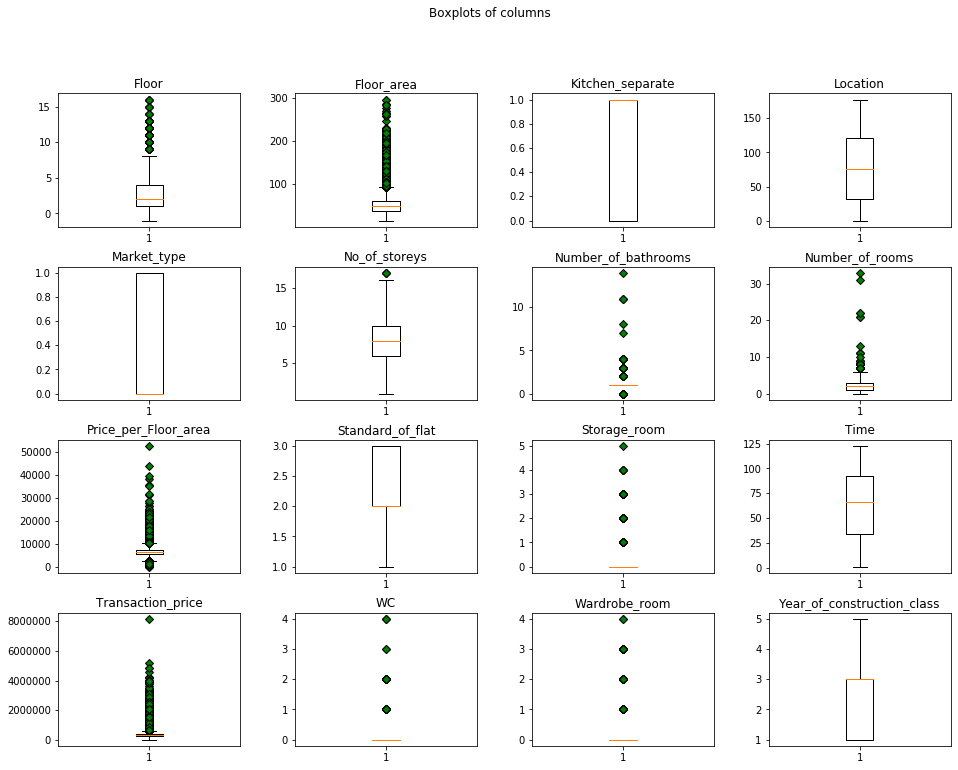

In [127]:
column_names_exclude=['Admin_district', 'Geodesic_precinct']
column_names=np.setdiff1d(df.columns, column_names_exclude)
column_names=column_names.tolist()
plot_boxplot_multi(df=df, column_names=column_names, ncol=4)

##### Conclusion
Most of the columns have outliers. They need to be investigated and removed.

#### Outliers: Transaction_price

It was decided to leave this column as it is. The Price_per_Floor_area is used as a measurement in Machine Learning model. The Transaction_price is reflected in the Price_per_Floor_area.

#### Outliers: Floor_area

In [128]:
col_name='Floor_area'

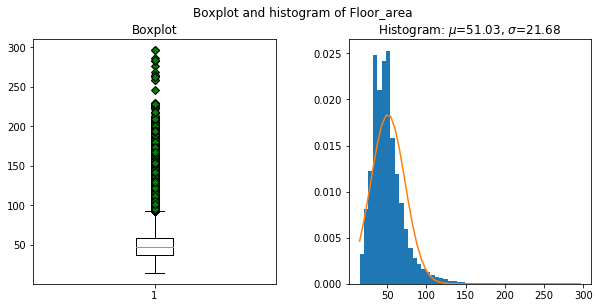

count    58638.00
mean        51.03
std         21.68
min         15.00
5%          24.97
25%         36.82
50%         47.70
75%         59.40
95%         90.04
max        296.00
Name: Floor_area, dtype: float64


In [129]:
plot_boxplot_histogram(df=df, column_name=col_name)

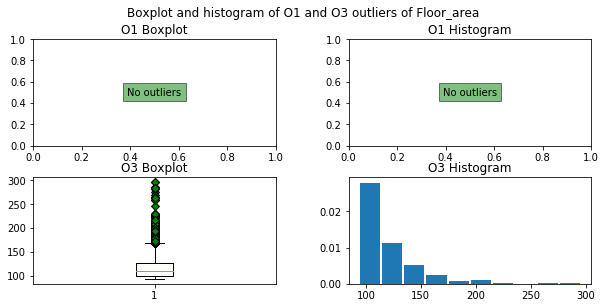

Percent of O1 outliers: 0.00%
Percent of O3 outliers: 4.32%
O3 outliers statistics:
count    2532.00
mean      118.79
std        27.64
min        93.27
50%       109.84
max       296.00
Name: Floor_area, dtype: float64


In [130]:
df_o1, df_o3 = get_plot_outliers_o1_o3(df=df, column_name=col_name)

##### Conclusion:
Continuous Probability Distributions: normal distribution, right skewnes.

It was decided:
- to drop instances with Floor_are above 150 (There is small number of such instances)
- to change the rest of upper outliers to random values between min and mean value of upper outliers

In [131]:
labels = df[col_name][df[col_name] > 150].index
df.drop(labels=labels, inplace=True)

labels = ( df[col_name] > df_o3[col_name].min() ) &  ( df[col_name] <= 150 )
s_temp = labels[labels == True]
df.loc[labels, col_name] = np.random.randint(df_o3[col_name].min(), high=df_o3[col_name].mean(), size=len(s_temp.index))

#### Outliers: Price_per_Floor_area

In [132]:
col_name='Price_per_Floor_area'

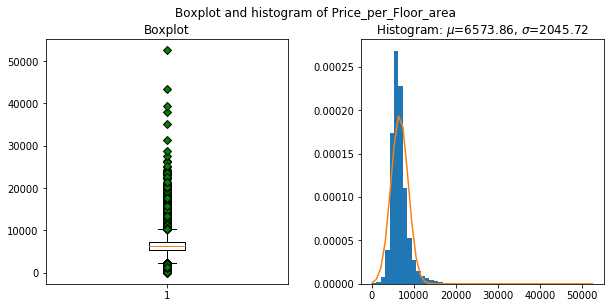

count    58369.00
mean      6573.86
std       2045.72
min         10.20
5%        4188.03
25%       5330.78
50%       6253.40
75%       7319.75
95%      10152.92
max      52571.43
Name: Price_per_Floor_area, dtype: float64


In [133]:
plot_boxplot_histogram(df=df, column_name=col_name)

##### Conclusion
- Continuous Probability Distributions: normal distribution, right skewnes.
- There is many outliers, especially upper ones
- The prices could change in time. Check the linear regression of Time and Price_per_Floor_area

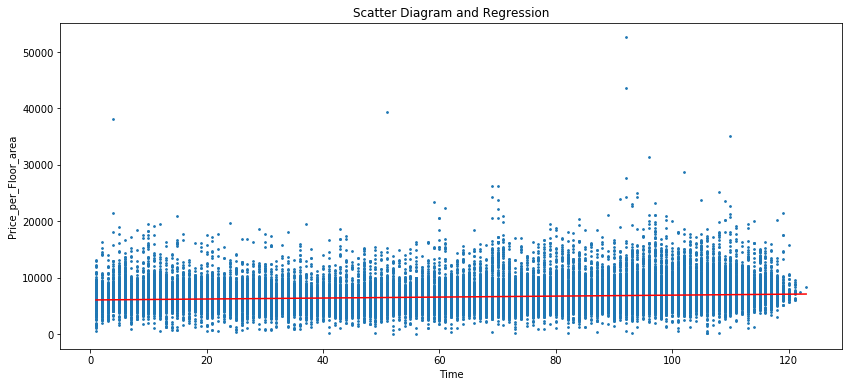

In [134]:
# Draw regression line at scatter diagram
scatter_regression(s_X=df['Time'], s_Y=df['Price_per_Floor_area'], same_scale=False, figsize=(14, 6))

##### Conclusion
Definitely outliers

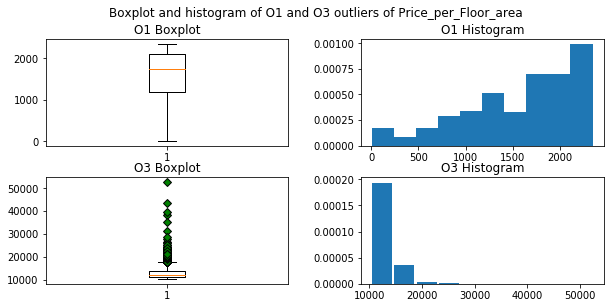

Percent of O1 outliers: 0.43%
O1 outliers statistics:
count     251.00
mean     1579.80
std       600.63
min        10.20
50%      1736.72
max      2342.86
Name: Price_per_Floor_area, dtype: float64
Percent of O3 outliers: 4.69%
O3 outliers statistics:
count     2738.00
mean     12744.67
std       2663.00
min      10303.69
50%      11990.69
max      52571.43
Name: Price_per_Floor_area, dtype: float64


In [135]:
df_o1, df_o3 = get_plot_outliers_o1_o3(df=df, column_name=col_name)

##### Conclusion
It was decided:
- to drop all data from lower outliers: ther is only 0.5% of such data
######  TODO- to drop instances where ther price_per_floor_are is below 4000 (expertise knowledge) 
- to remove all instances that are greater than the mean of O3
###### TODO or not TODO - to correct the rest to min value of upper outliers
- to keep the rest of data. Those data will be investigated again in next loop of the Clining Data Process

In [136]:
# Data Reduction
indices_to_remove = df_o1[col_name].index
df.drop(labels=indices_to_remove, inplace=True)

labels = df_o3[col_name] >= df_o3[col_name].mean()
indices_to_remove = df_o3.loc[labels].index
df.drop(labels=indices_to_remove, inplace=True)

df.reset_index(drop=True, inplace=True)

In [137]:
df.columns

Index(['Time', 'Admin_district', 'Geodesic_precinct', 'Location',
       'Transaction_price', 'Floor_area', 'Price_per_Floor_area',
       'Year_of_construction_class', 'Floor', 'No_of_storeys',
       'Standard_of_flat', 'Market_type', 'Number_of_rooms',
       'Kitchen_separate', 'Number_of_bathrooms', 'WC', 'Wardrobe_room',
       'Storage_room'],
      dtype='object')

In [138]:
# Data ............

# labels = df[col_name][df[col_name] > df_o3[col_name].min()].index
# df.loc[labels, col_name] = df_o3[col_name].min()

In [139]:
# drop all data where ther price_per_floor_are is below 4000

#labels = df[col_name][df[col_name] < 4000].index
#df.drop(labels=labels, inplace=True)

#### Outliers: Floor

In [140]:
col_name='Floor'

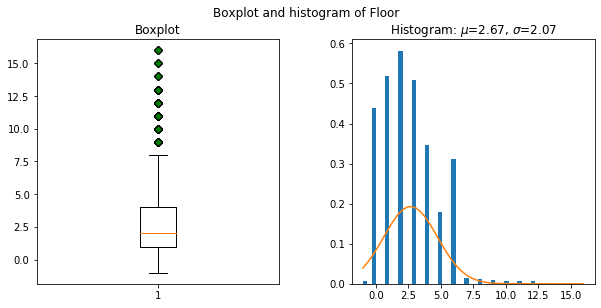

count    57080.00
mean         2.67
std          2.07
min         -1.00
5%           0.00
25%          1.00
50%          2.00
75%          4.00
95%          6.00
max         16.00
Name: Floor, dtype: float64


In [141]:
plot_boxplot_histogram(df=df, column_name=col_name)

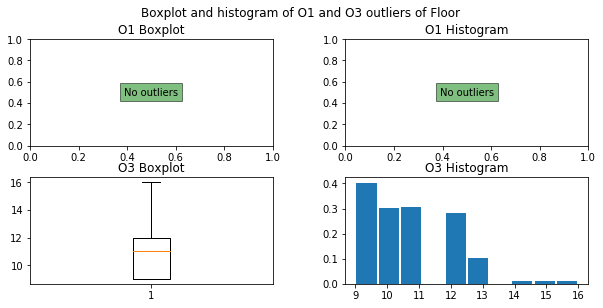

Percent of O1 outliers: 0.00%
Percent of O3 outliers: 1.02%
O3 outliers statistics:
count    584.00
mean      10.65
std        1.43
min        9.00
50%       11.00
max       16.00
Name: Floor, dtype: float64


In [142]:
df_o1, df_o3 = get_plot_outliers_o1_o3(df=df, column_name=col_name)

##### Conclusion:
It was decided to change the upper outliers to 7
It was decided to change the values lower than 0 to 0.

In [143]:
labels = df[col_name][df[col_name] < 0].index
df.loc[labels, col_name] = 0

labels = df_o3[col_name].index
df.loc[labels, col_name] = 7

#### Outliers: No_of_storeys

In [144]:
col_name='No_of_storeys'

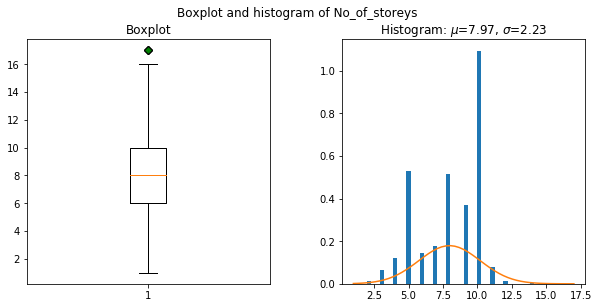

count    57080.00
mean         7.97
std          2.23
min          1.00
5%           4.00
25%          6.00
50%          8.00
75%         10.00
95%         10.00
max         17.00
Name: No_of_storeys, dtype: float64


In [145]:
plot_boxplot_histogram(df=df, column_name=col_name)

##### Conclusion:
- No outliers
- It was decided to create new feature Building_height with two values 0 - short (up to 5 storeys) and 1 - tall (above 5 storeys)

#### Outliers: Number_of_rooms

In [146]:
col_name='Number_of_rooms'

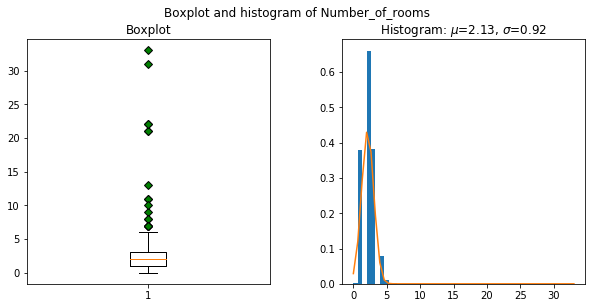

count    57080.00
mean         2.13
std          0.92
min          0.00
5%           1.00
25%          1.00
50%          2.00
75%          3.00
95%          4.00
max         33.00
Name: Number_of_rooms, dtype: float64


In [147]:
plot_boxplot_histogram(df=df, column_name=col_name)

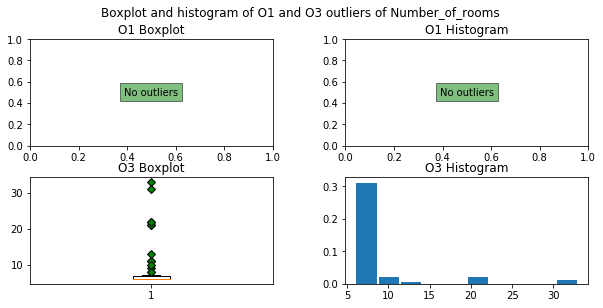

Percent of O1 outliers: 0.00%
Percent of O3 outliers: 0.12%
O3 outliers statistics:
count    70.00
mean      8.10
std       5.57
min       6.00
50%       6.00
max      33.00
Name: Number_of_rooms, dtype: float64


In [148]:
df_o1, df_o3 = get_plot_outliers_o1_o3(df=df, column_name=col_name)

##### Conclusion:
- geometric distribution

It was decided to change the bottom outliers to 1 and and upper outliers to 4

In [149]:
### TODO check if it is correct

labels = df[col_name][df[col_name] < 1].index
df.loc[labels, col_name] = 1


labels = df[col_name][df[col_name] > 4].index
df.loc[labels, col_name] = 4

#### Outliers: Number_of_bathrooms

In [150]:
col_name='Number_of_bathrooms'

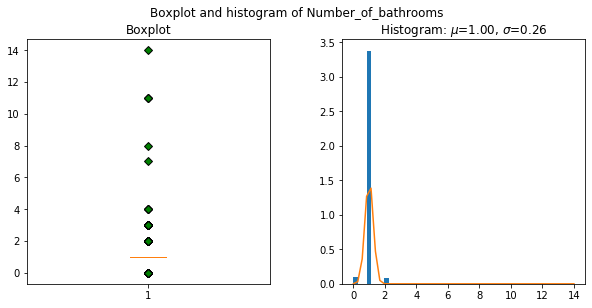

count    57080.00
mean         1.00
std          0.26
min          0.00
5%           1.00
25%          1.00
50%          1.00
75%          1.00
95%          1.00
max         14.00
Name: Number_of_bathrooms, dtype: float64


In [151]:
plot_boxplot_histogram(df, column_name=col_name)

##### Conclusion:
- geometric distribution

It was decided to:
- change all values lower that are 1 to 0 (it indicates that there is 1 bathroom)
- change all values greater than 1 to 1 (it indicates that there is one extra bathroom)

In [152]:
# Where cond is True, keep the original value. Where False, replace with corresponding value from other.
# Entries where cond is False are replaced with corresponding value from other
df[col_name].where(cond=df[col_name] > 1, other=0, inplace=True)
df[col_name].where(cond=df[col_name] < 1, other=1, inplace=True)

#### Outliers: WC

In [153]:
col_name='WC'

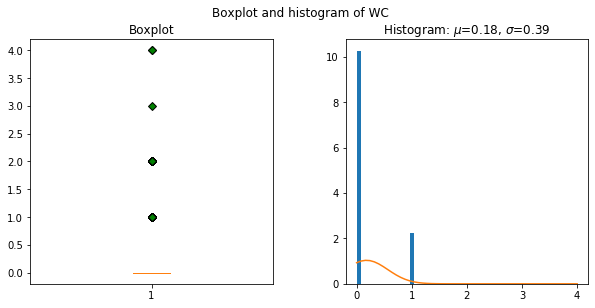

count    57080.00
mean         0.18
std          0.39
min          0.00
5%           0.00
25%          0.00
50%          0.00
75%          0.00
95%          1.00
max          4.00
Name: WC, dtype: float64


In [154]:
plot_boxplot_histogram(df=df, column_name=col_name)

##### Conclusion:
- geometric distribution 

It was decided to:
- change all values lower than 1 to 0
- change all values greater than 1 to 1 (indicates that there is WC as an extra room)

In [155]:
df[col_name].where(cond=df[col_name] < 1, other=1, inplace=True)
df[col_name].where(cond=df[col_name] >= 1, other=0, inplace=True)

#### Outliers: Wardrobe_room

In [156]:
col_name = 'Wardrobe_room'

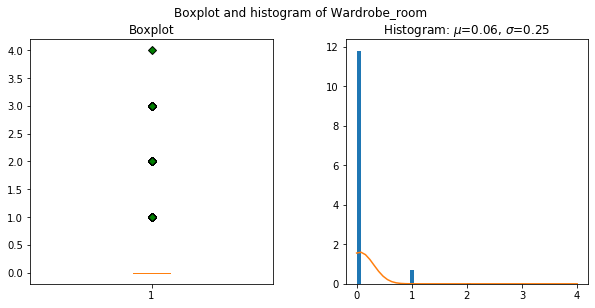

count    57080.00
mean         0.06
std          0.25
min          0.00
5%           0.00
25%          0.00
50%          0.00
75%          0.00
95%          1.00
max          4.00
Name: Wardrobe_room, dtype: float64


In [157]:
plot_boxplot_histogram(df, column_name=col_name)

##### Conclusion:
- geometric distribution 

It was decided to:
- change all values lower than 1 to 0
- change all values greater than 1 to 1 (indicates that there is an extra room)

In [158]:
df[col_name].where(cond=df[col_name] < 1, other=1, inplace=True)
df[col_name].where(cond=df[col_name] >= 1, other=0, inplace=True)

#### Outliers: Storage_room

In [159]:
col_name = 'Storage_room'

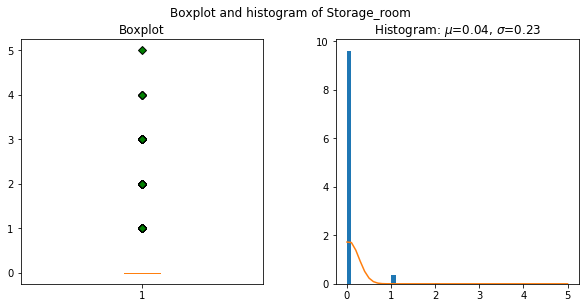

count    57080.00
mean         0.04
std          0.23
min          0.00
5%           0.00
25%          0.00
50%          0.00
75%          0.00
95%          0.00
max          5.00
Name: Storage_room, dtype: float64


In [160]:
plot_boxplot_histogram(df=df, column_name=col_name)

##### Conclusion:
- geometric distribution 

It was decided to:
- change all values lower than 1 to 0
- change all values greater than 1 to 1 (indicates that there is an extra room)

In [161]:
df[col_name].where(cond=df[col_name] < 1, other=1, inplace=True)
df[col_name].where(cond=df[col_name] >= 1, other=0, inplace=True)

### Visualization after dealing with outliers

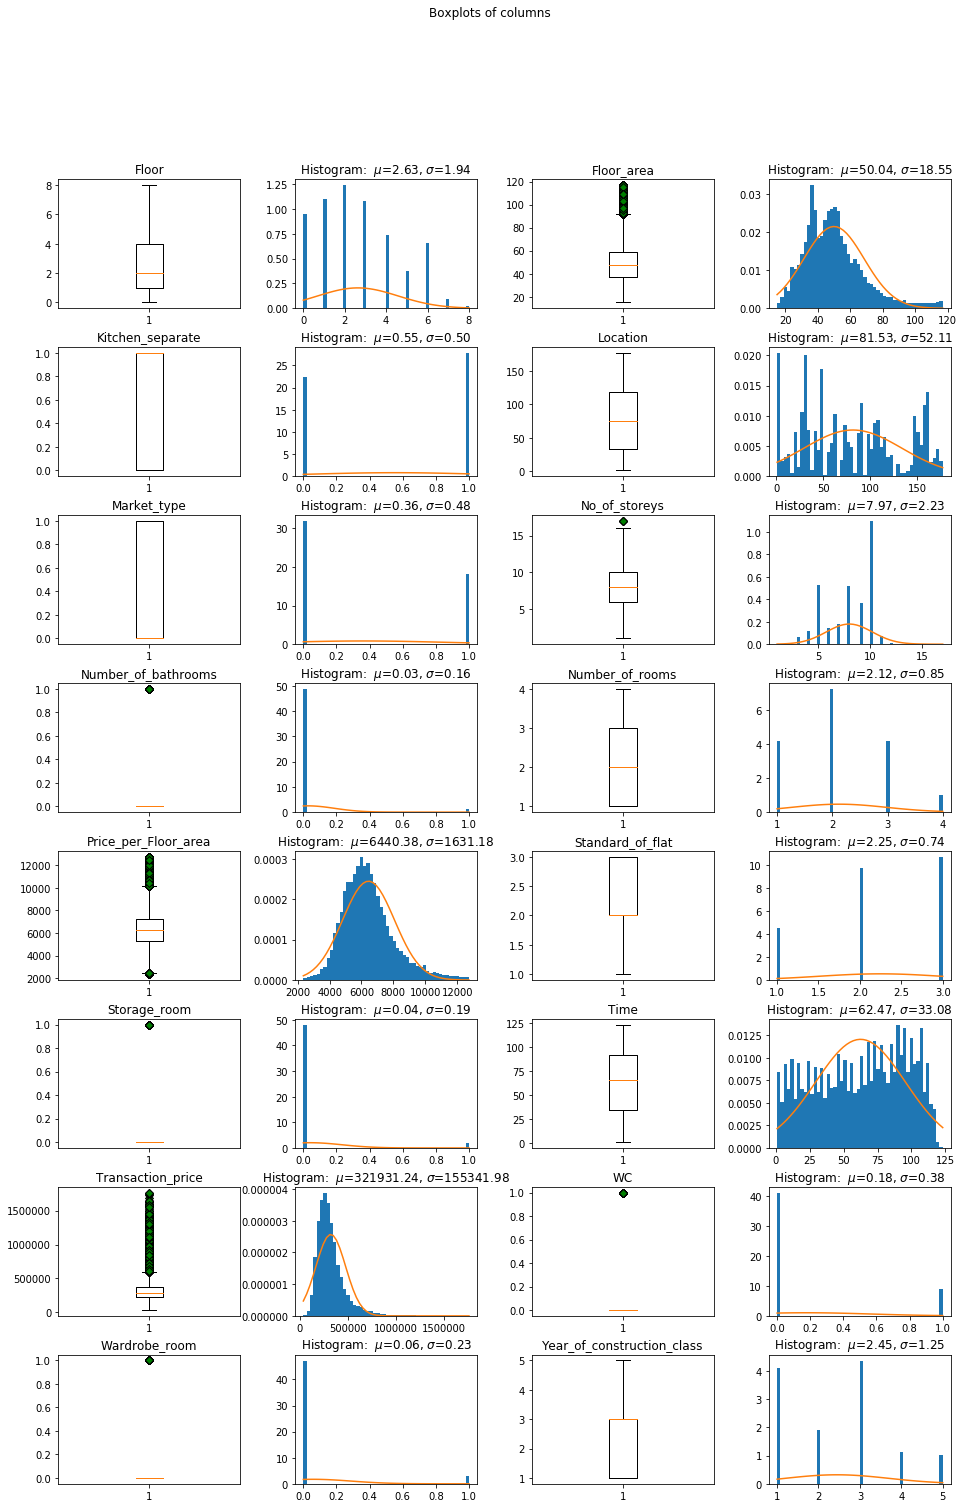

In [162]:
column_names_exclude=['Admin_district', 'Geodesic_precinct']
column_names=np.setdiff1d(df.columns, column_names_exclude)
column_names=column_names.tolist()

plot_boxplot_hist_multi(df=df, column_names=column_names, ncol=4)

##### Conclusion
- Looks much better, but still many anomalies
- Right skewnes in Floor_are
- Continuous Probability Distributions:
    - normal distribution/Gaussian distribution/“bell curve if Floor_area and Price_per_floor_area
- Discrete Probability Distributions:
    - Bernoulli Distribution (special case of e binomial distribution) with probability close to many 0 or 1 (failer or success) for most of the features describing the number of extra rooms, like WC, wardrobe, storage room ect. (It was decided to leave them for first loop (training) and next remove them manually.)
    - Poisson distribution: Location
    - Uniform distribution: Time

## Feature: No_of_storeys -> Building_heigh

### Data Transformation: Feature Construction
It was decided to create new feature Building_height based on No_of_storeys.
Building_height has two values that describe the highes of the building: 0 - short (up to 8 storeys) and 1 - tall (above 8 storeys)

In [163]:
# IMPORTANT! Reset index/labes before inserting new column, as index could be change in the meantime
df.reset_index(drop=True, inplace=True)

# creating column Building_height based on No_of_storeys
arr = np.zeros(len(df.index), dtype=int) # Zero represents short building (using index is probably faster way)
# inserting new column to DataFrame
s = pd.Series(arr, index=df.index, dtype='int') # TODO problem with np.nan, should be boolean type
loc = np.nonzero(df.columns.to_numpy() == 'No_of_storeys')
loc = int(loc[0][0]) + 1
df.insert(loc, 'Building_height', s)

# Correct values for tall building
labels = df[df['No_of_storeys'] > 8].index
df.loc[labels, 'Building_height'] = 1

In [164]:
# Test
# Expected: 
# 0
# 0
# 1
# False
print(df[['Building_height']][df['No_of_storeys'] == 7].head(1))
print(df[['Building_height']][df['No_of_storeys'] == 8].head(1))
print(df[['Building_height']][df['No_of_storeys'] == 9].head(1))


# TODO check if the below is correct

labels = ( ( df['No_of_storeys'] > 8 ) & ( df['Building_height'] == 0 ) )
print(df.loc[labels, 'Building_height'])
print(df['Building_height'].isna().any())

   Building_height
1                0
   Building_height
7                0
    Building_height
26                1
Series([], Name: Building_height, dtype: int32)
False


### Data Reduction: Feature selection
Removing No_of_storeys feature

In [165]:
df.drop(columns=['No_of_storeys'], inplace=True)

## Feature: Price_per_Floor_area

### Data Cleaning: Removing outliers

In [166]:
col_name='Price_per_Floor_area'

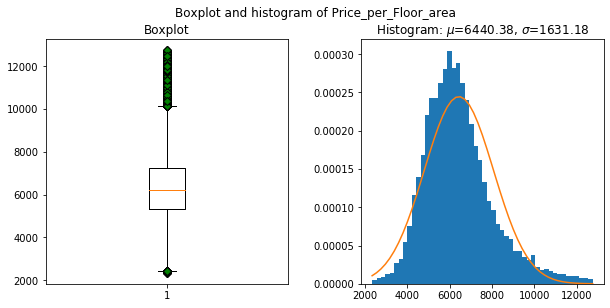

count    57080.00
mean      6440.38
std       1631.18
min       2352.02
5%        4225.35
25%       5324.12
50%       6227.51
75%       7250.55
95%       9611.09
max      12743.63
Name: Price_per_Floor_area, dtype: float64


In [167]:
plot_boxplot_histogram(df=df, column_name=col_name)

##### Conclusion
- Continuous Probability Distributions: normal distribution, right skewnes.
- There is many outliers, especially upper ones
- The prices could change in time. Check the linear regression of Time and Price_per_Floor_area

In [168]:
df_o1, df_o3 = get_plot_outliers_o1_o3(df=df, column_name=col_name, plot=False)

Percent of O1 outliers: 0.04%
O1 outliers statistics:
count      25.00
mean     2398.04
std        27.50
min      2352.02
50%      2405.65
max      2432.91
Name: Price_per_Floor_area, dtype: float64
Percent of O3 outliers: 3.32%
O3 outliers statistics:
count     1895.00
mean     11182.24
std        720.47
min      10140.41
50%      11065.67
max      12743.63
Name: Price_per_Floor_area, dtype: float64


##### Conclusion
It was decided:
- to drop all data from lower outliers: ther is only 0.5% of such data


- to keep the rest of data. Data should be smooth at first with regression function.



In [169]:
# Data Reduction
indices_to_remove = df_o1[col_name].index
df.drop(labels=indices_to_remove, inplace=True)
df.reset_index(drop=True, inplace=True)

## Feature: Number_of_bathrooms, WC, Wardrobe_room, Storage_room -> Extra_room

In [170]:
df.columns

Index(['Time', 'Admin_district', 'Geodesic_precinct', 'Location',
       'Transaction_price', 'Floor_area', 'Price_per_Floor_area',
       'Year_of_construction_class', 'Floor', 'Building_height',
       'Standard_of_flat', 'Market_type', 'Number_of_rooms',
       'Kitchen_separate', 'Number_of_bathrooms', 'WC', 'Wardrobe_room',
       'Storage_room'],
      dtype='object')

### Data Transformation: Feature Construction
### Data Aggregation
It was decided to create new feature Extra_room based on 'Number_of_bathrooms', 'WC', 'Wardrobe_room', 'Storage_room'
Extra_room has two values that describe if there is any extra room in a flat, like bathroom,WC, ect.: 
- 0 - no extra rooms
- 1 - there is extra room

In [171]:
# Reset index/labes, as index could be change in the meantime
df.reset_index(drop=True, inplace=True)

# creating column
arr = np.zeros(len(df.index), dtype=int) # Zero represents short building (using index is probably faster way)
# inserting new column to DataFrame
s = pd.Series(arr, index=df.index, dtype='int')
df.insert(len(df.columns), 'Extra_room', s)

# Correct values
labels = ( (df['Number_of_bathrooms'] > 0) &  (df['WC'] > 0) &  (df['Wardrobe_room'] > 0) &  (df['Storage_room'] > 0) )
df.loc[labels, 'Extra_room'] = 1

### Data Reduction: Feature selection
Removing 'Number_of_bathrooms', 'WC', 'Wardrobe_room', 'Storage_room' feature

In [172]:
df.drop(columns=['Number_of_bathrooms', 'WC', 'Wardrobe_room', 'Storage_room'], inplace=True)

### Visualization

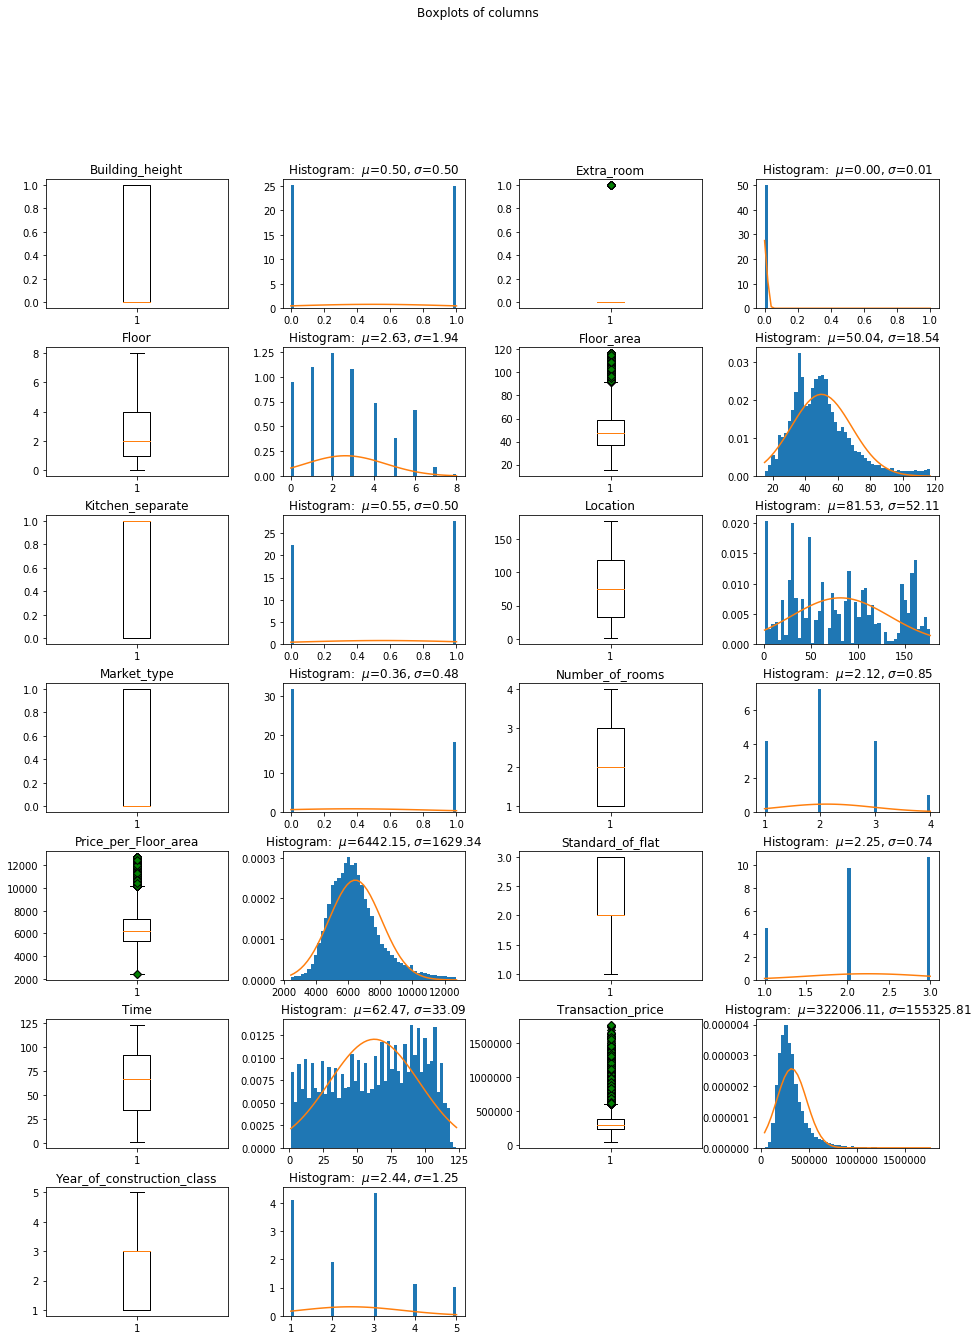

In [173]:
column_names_exclude=['Admin_district', 'Geodesic_precinct']
column_names=np.setdiff1d(df.columns, column_names_exclude)
plot_boxplot_hist_multi(df=df, column_names=column_names, ncol=4)

In [174]:
display_percentage_of_nan(df=df, col_names=df.columns)

Percentage of nan values:
Time                         0.00
Admin_district               0.00
Geodesic_precinct            0.00
Location                     0.00
Transaction_price            0.00
Floor_area                   0.00
Price_per_Floor_area         0.00
Year_of_construction_class   0.00
Floor                        0.00
Building_height              0.00
Standard_of_flat             0.00
Market_type                  0.00
Number_of_rooms              0.00
Kitchen_separate             0.00
Extra_room                   0.00
dtype: float64


In [175]:
df.dtypes

Time                            int64
Admin_district                 object
Geodesic_precinct               int64
Location                        int32
Transaction_price             float64
Floor_area                    float64
Price_per_Floor_area          float64
Year_of_construction_class      int32
Floor                           int32
Building_height                 int32
Standard_of_flat                int32
Market_type                     int32
Number_of_rooms                 int32
Kitchen_separate                int32
Extra_room                      int32
dtype: object

In [176]:
#pl = pd.plotting.scatter_matrix(df, diagonal='hist', figsize=(20,20), s=100)

In [177]:
#fig, ax = plt.subplots(figsize=(20,8))
#plt.suptitle('')
#df.boxplot(column=['Price_per_Floor_area'], by=['Location', 'Year_of_construction_classes'], ax=ax)

##### Conclusion: 
- outliers
- smooth data at first by regression of Time to Price_per_Floor_area

# OUTPUT
## DF_PREPROCESSED
- data require further preprocessing:
    - Price_per_Floor_area require smoothing by trend function (trend of average transactional prices per square metre over time)
    - Price_per_Floor_area - still many outliers

In [178]:
DF_PREPROCESSED = df

# <center>------------------ METHOD NUMBER I ---------------------------</center>

#  'Location' as a spatial unit
'Location' was created as a unique value of 'Admin_district', 'Geodesic_precinct'

# INPUT

In [179]:
df = DF_PREPROCESSED.copy()

# 3. Data Preprocessing

In [180]:
df.columns

Index(['Time', 'Admin_district', 'Geodesic_precinct', 'Location',
       'Transaction_price', 'Floor_area', 'Price_per_Floor_area',
       'Year_of_construction_class', 'Floor', 'Building_height',
       'Standard_of_flat', 'Market_type', 'Number_of_rooms',
       'Kitchen_separate', 'Extra_room'],
      dtype='object')

In [181]:
df.drop(columns=['Transaction_price'], inplace=True)

In [182]:
# Rester index to avoid error
df.reset_index(drop=True, inplace=True)

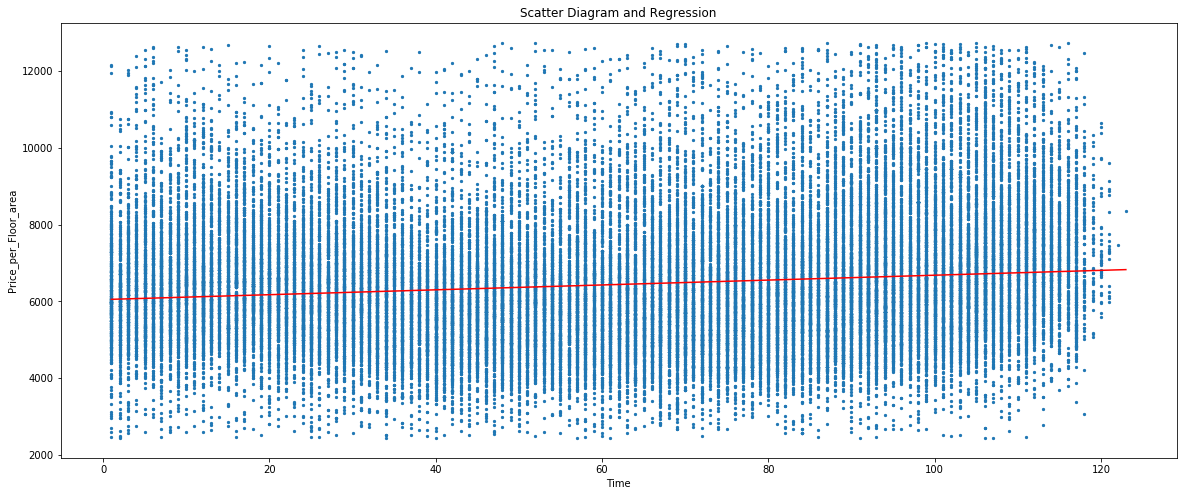

In [183]:
# Draw regression line at scatter diagram
scatter_regression(s_X=df['Time'], s_Y=df['Price_per_Floor_area'], same_scale=False, figsize=(20, 8), s=5)

##### Conclusion
At first there was a drop in prices, next they were stable, next there was increase

#### Data Cleaning: Smoothing data

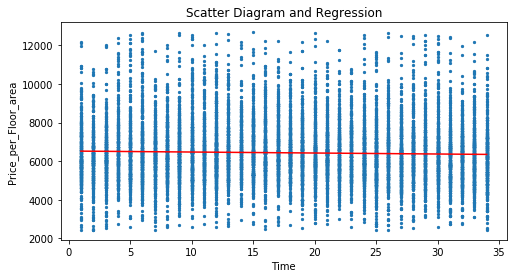

y = -5.13*x + 6524.29


C:\Users\MoioM\Anaconda3\envs\snakes\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


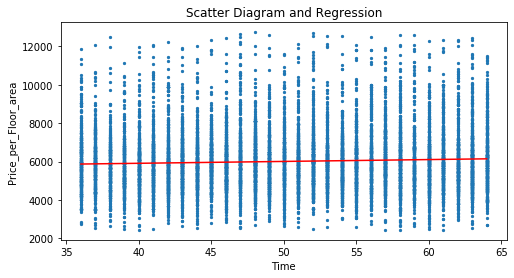

y = 9.69*x + 5520.58


C:\Users\MoioM\Anaconda3\envs\snakes\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


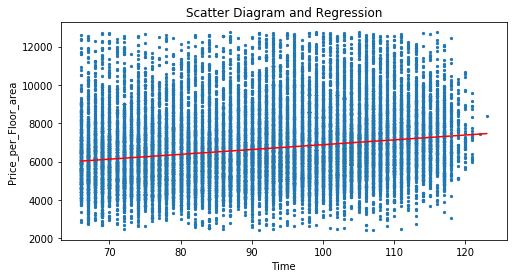

y = 25.19*x + 4360.98


In [184]:
# Smooth data by trend, split Time into three periods
periods = [(0, 35), (35, 65), (65, df['Time'].max() + 1)]
smooth_price_by_time(periods=periods)

In [185]:
# Drop columns
df.drop(columns=['Time', 'Admin_district', 'Geodesic_precinct'], inplace=True)

#### Visualization

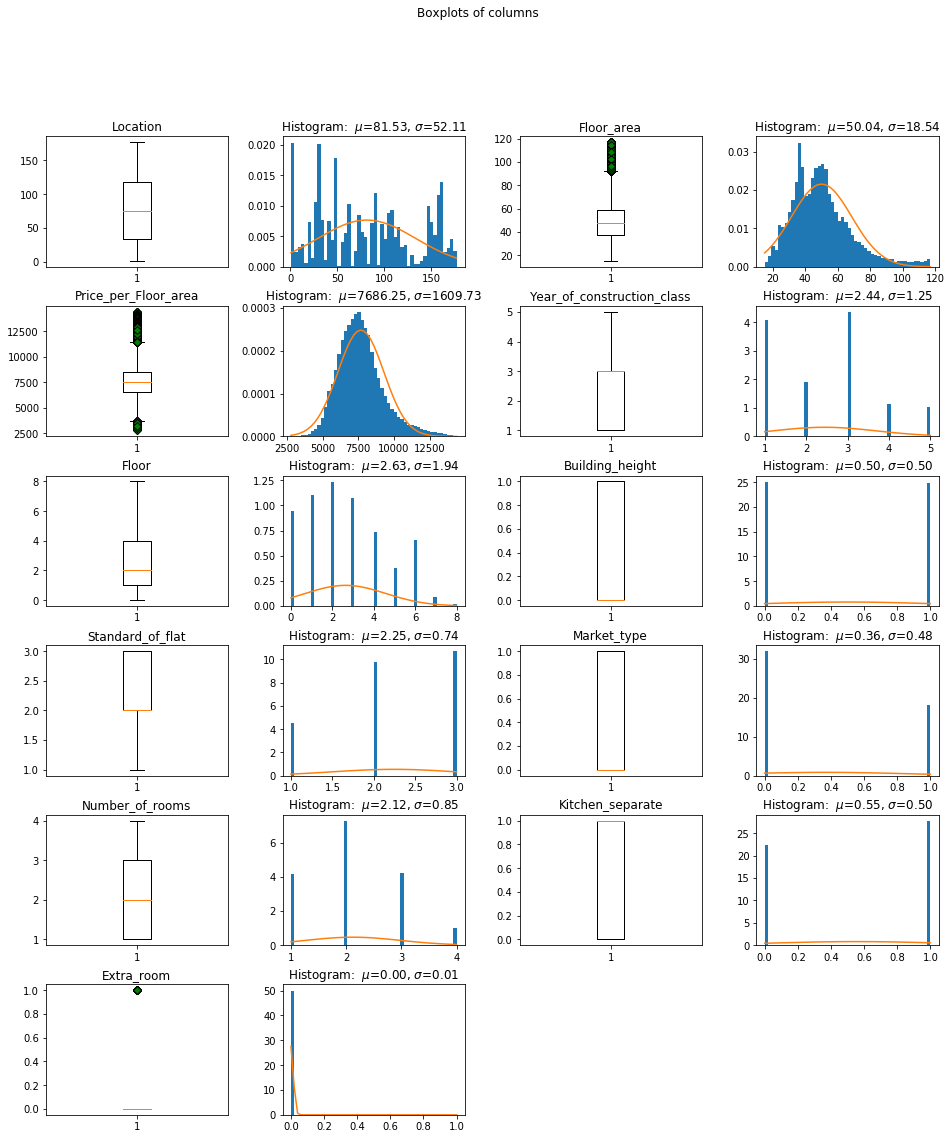

In [186]:
plot_boxplot_hist_multi(df=df, column_names=df.columns, ncol=4)

#### Feature: Price_per_Floor_area

#### Data Cleaning: Removing outliers

In [187]:
col_name='Price_per_Floor_area'

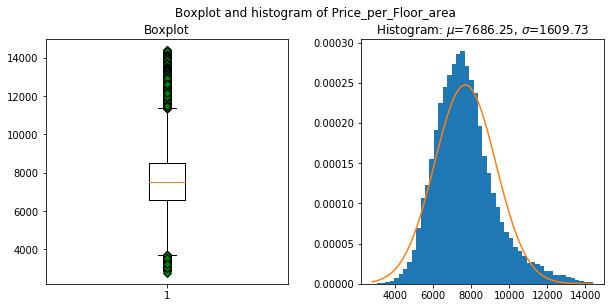

count    57055.00
mean      7686.25
std       1609.73
min       2787.71
5%        5417.83
25%       6591.91
50%       7517.40
75%       8515.74
95%      10733.38
max      14393.23
Name: Price_per_Floor_area, dtype: float64


In [188]:
plot_boxplot_histogram(df=df, column_name=col_name)

##### Conclusion
- Continuous Probability Distributions: normal distribution, right skewnes.
- There is many outliers, especially upper ones

In [189]:
df_o1, df_o3 = get_plot_outliers_o1_o3(df=df, column_name=col_name, plot=False)

Percent of O1 outliers: 0.10%
O1 outliers statistics:
count      58.00
mean     3426.28
std       229.77
min      2787.71
50%      3507.11
max      3704.98
Name: Price_per_Floor_area, dtype: float64
Percent of O3 outliers: 3.12%
O3 outliers statistics:
count     1782.00
mean     12350.46
std        726.59
min      11401.62
50%      12196.28
max      14393.23
Name: Price_per_Floor_area, dtype: float64


##### Conclusion
It was decided:
- to drop all data from lower outliers: ther is only 0.5% of such data

- to log transform the rest of data to log

In [190]:
O1, O3 = get_O1_O3(df, col_name)
print('O1: {:.2f}; O3: {:.2f}'.format(O1, O3))

O1: 3706.17; O3: 11401.48


In [191]:
# Remove outliers
labels = df[col_name][df[col_name] < O1].index
df.drop(labels=labels, inplace=True)
df.reset_index(drop=True, inplace=True)

# Correct outliers to be between outlier.min
#labels = df[col_name] > O3
#df.loc[labels, col_name] = O3

#df[col_name] = np.log(df[col_name])
df[col_name] = df[col_name].transform(np.log)

#### Outliers: Floor_area

In [192]:
col_name='Floor_area'

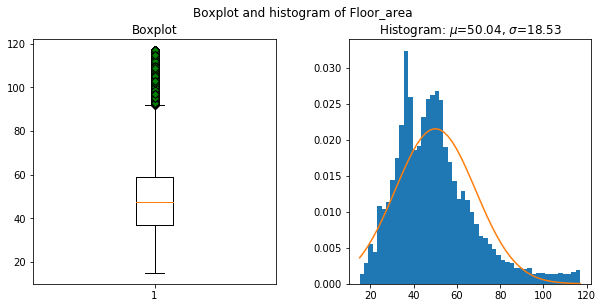

count    56997.00
mean        50.04
std         18.53
min         15.00
5%          25.07
25%         36.81
50%         47.60
75%         58.92
95%         86.70
max        117.00
Name: Floor_area, dtype: float64


In [193]:
plot_boxplot_histogram(df=df, column_name=col_name)

In [194]:
df_o1, df_o3 = get_plot_outliers_o1_o3(df=df, column_name=col_name, plot=False)

Percent of O1 outliers: 0.00%
Percent of O3 outliers: 3.88%
O3 outliers statistics:
count    2210.00
mean      104.14
std         7.57
min        92.10
50%       104.00
max       117.00
Name: Floor_area, dtype: float64


In [195]:
O1, O3 = get_O1_O3(df, col_name)
print('O1: {:.2f}; O3: {:.2f}'.format(O1, O3))

O1: 3.65; O3: 92.09


##### Conclusion:
Continuous Probability Distributions: normal distribution, right skewnes.

It was decided to transform data by log function

In [196]:
df[col_name] = df[col_name].transform(np.log)

#### Visualization

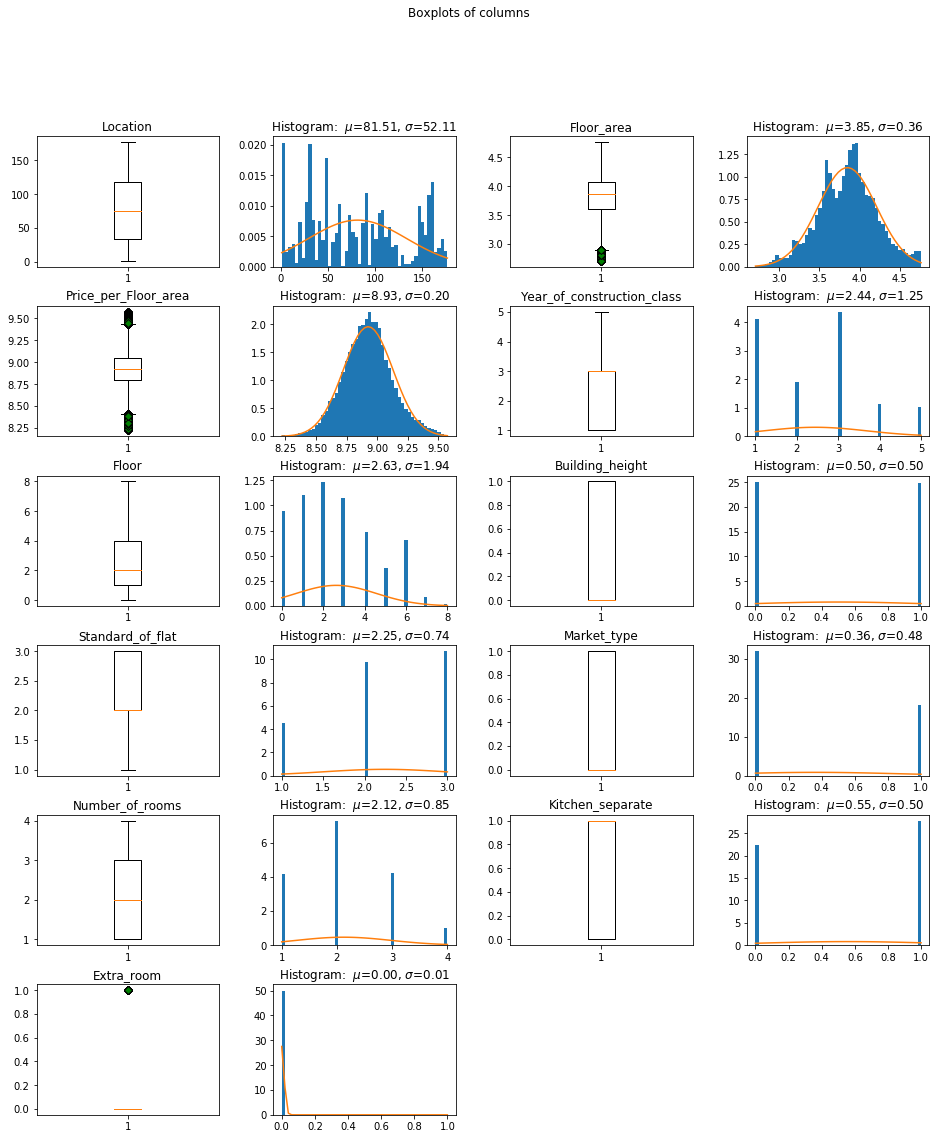

In [197]:
plot_boxplot_hist_multi(df=df, column_names=df.columns, ncol=4)

### Feature: Location

#### Data Transformation: transforming categorical variables to numeric variables
The variables Location are categorical variables. SVR can only handle numeric values and so we need to create a new variable (dummy variable) for every unique value of the categorical variables.

In [198]:
df_dummies = pd.get_dummies(df.Location , prefix='Location_', columns='Location', drop_first=False )
df_dummies.head(1)

Location__1  Location__2  Location__3  Location__4  Location__5  \
0            0            0            0            0            0   

   Location__6  Location__7  Location__8  Location__9  Location__10  ...  \
0            0            0            0            0             0  ...   

   Location__168  Location__169  Location__170  Location__171  Location__172  \
0              0              0              0              0              0   

   Location__173  Location__174  Location__175  Location__176  Location__177  
0              0              0              0              0              0  

[1 rows x 175 columns]

In [199]:
df = pd.concat( [df, df_dummies] , axis=1 )

In [200]:
df.head(1)

Location  Floor_area  Price_per_Floor_area  Year_of_construction_class  \
0        31    3.367296              8.963132                           3   

   Floor  Building_height  Standard_of_flat  Market_type  Number_of_rooms  \
0      3                1                 2            0                1   

   Kitchen_separate  ...  Location__168  Location__169  Location__170  \
0                 1  ...              0              0              0   

   Location__171  Location__172  Location__173  Location__174  Location__175  \
0              0              0              0              0              0   

   Location__176  Location__177  
0              0              0  

[1 rows x 186 columns]

In [201]:
df.columns

Index(['Location', 'Floor_area', 'Price_per_Floor_area',
       'Year_of_construction_class', 'Floor', 'Building_height',
       'Standard_of_flat', 'Market_type', 'Number_of_rooms',
       'Kitchen_separate',
       ...
       'Location__168', 'Location__169', 'Location__170', 'Location__171',
       'Location__172', 'Location__173', 'Location__174', 'Location__175',
       'Location__176', 'Location__177'],
      dtype='object', length=186)

# TODO check if correct columns were selected

In [202]:
df.drop(columns=['Location'], inplace=True)

# OUTPUT
## DF_OUTPUT_I3
- Price_per_Floor_area is:
    - smoothed by trend
    - outliers are removed
    - transformed by log function to remove right skewnes
- Floor_are is:
    - transformed by log function to remove right skewnes

In [203]:
DF_OUTPUT_I3 = df.copy()

# 4. Data Modeling

# Model number I.A
## SVR

In [204]:
df = DF_OUTPUT_I3.copy()

### Splitting data into input and output (data and target)

In [205]:
X_df = df.drop(columns=['Price_per_Floor_area'], inplace=False) # input; deep copy of columns 
Y_df = df[['Price_per_Floor_area']] # output

### Data Transformation: Rescale Data
### Normalize data 
Data were rescaled using normalization, MinMax techniqe. It means that the data were rescaled to lie between 0 and 1. It brings all the values of numeric columns in the dataset to a common scale.

In [206]:
# get a set of values from original dataset
X = X_df.values

# normalized data
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [207]:
# Cache input and output data as dataframe
X_df = pd.DataFrame.from_records(X, columns=X_df.columns) # Create dataframe of from normalized data

# Test: display first instance
X_df.head(1)

Floor_area  Year_of_construction_class  Floor  Building_height  \
0    0.320938                         0.5  0.375              1.0   

   Standard_of_flat  Market_type  Number_of_rooms  Kitchen_separate  \
0               0.5          0.0              0.0               1.0   

   Extra_room  Location__1  ...  Location__168  Location__169  Location__170  \
0         0.0          0.0  ...            0.0            0.0            0.0   

   Location__171  Location__172  Location__173  Location__174  Location__175  \
0            0.0            0.0            0.0            0.0            0.0   

   Location__176  Location__177  
0            0.0            0.0  

[1 rows x 184 columns]

#### Statistical description of normalized data
Data were normalized using MinMax technique.
- expected: min = 0, max = 0
- mean do not need to be 0 and standad deviation do not need to be 1

In [208]:
df_desc=X_df.describe()
df_desc.loc[['min', 'max', 'mean', 'std']]

Floor_area  Year_of_construction_class     Floor  Building_height  \
min     0.000000                    0.000000  0.000000         0.000000   
max     1.000000                    1.000000  1.000000         1.000000   
mean    0.554753                    0.361146  0.329134         0.498360   
std     0.176371                    0.313106  0.242838         0.500002   

      Standard_of_flat  Market_type  Number_of_rooms  Kitchen_separate  \
min           0.000000     0.000000         0.000000          0.000000   
max           1.000000     1.000000         1.000000          1.000000   
mean          0.622542     0.362387         0.374236          0.554433   
std           0.370725     0.480694         0.284837          0.497033   

      Extra_room  Location__1  ...  Location__168  Location__169  \
min     0.000000     0.000000  ...       0.000000       0.000000   
max     1.000000     1.000000  ...       1.000000       1.000000   
mean    0.000211     0.003527  ...       0.004158       0.002684   
std     0.014509     0.059280  ...       0.064350       0.051742   

      Location__170  Location__171  Location__172  Location__173  \
min        0.000000       0.000000       0.000000       0.000000   
max        1.000000       1.000000       1.000000       1.000000   
mean       0.001404       0.003597       0.000947       0.009808   
std        0.037438       0.059865       0.030766       0.098547   

      Location__174  Location__175  Location__176  Location__177  
min        0.000000       0.000000       0.000000       0.000000  
max        1.000000       1.000000       1.000000       1.000000  
mean       0.001228       0.004298       0.001544       0.001965  
std        0.035024       0.065422       0.039263       0.044285  

[4 rows x 184 columns]

#### Data Reduction: Feature selection: PCA
PCA technique (Principal Component Analysis)
- automatically select the features that contribut best to prediction
- allows to reduce dimentionality

It is necessary to normalize data before performing PCA (data are already normalized)

In [209]:
#X = X_df.values

In [210]:
#pca = PCA(n_components=6)
#pca.fit(X) # Fit the model with X

In [211]:
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

# summarize components
#print("Explained Variance: %s" % pca.explained_variance_ratio_)
#print(pca.components_)

In [212]:
#print(pca.singular_values_)

In [213]:
#X = pca.transform(X) # Apply dimensionality reduction to X

In [214]:
# Cache output data after this stage
#X_df = pd.DataFrame.from_records(X)
#Y_df = Y_df

### Model: Regression: SVR(kernel='linear')

### Document Choice:
- there is more than 50 instances
- data taget is not categorical
- data target describes quantity (number)
- there is less than 100k instances
- all feature should be important
- use SVR(kernel='linear')

In [215]:
# Input Data
X = X_df.values
y = Y_df.values.flatten()

In [216]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Train data 

In [217]:
# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py
regressor = SVR(kernel='linear', C=1, gamma='auto')

model = regressor.fit(X_train, y_train)

#### Evaluate model

In [218]:
y_predicted = model.predict(X_test)

In [219]:
# transform from log
y_test = np.exp(y_test)
y_predicted = np.exp(y_predicted)

In [220]:
# value of Y_predict
y_predicted[0]

8341.326956272234

In [221]:
# actual value
y_test[0]

7858.074034689157

In [222]:
s_predicted = pd.Series(y_predicted, name='Predicted output')
s_target = pd.Series(y_test, name='Target output')

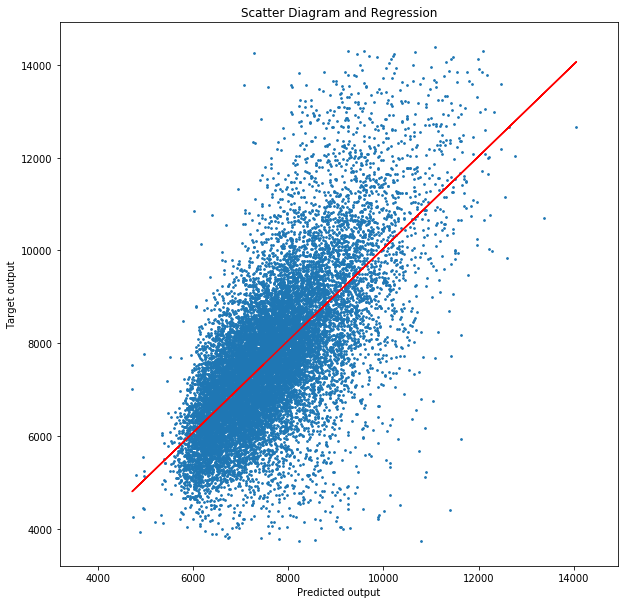

In [223]:
# plot scatter diagram to visualize how well data were predicted
scatter_regression(s_X=s_predicted, s_Y=s_target, same_scale=True)

In [224]:
# Calculate Pearson Correlation Coeficient, the closer to 1 the better
r_pearson_coef, p = pearsonr(y_predicted, y_test)
print('Pearson Correlation Coeficient: {:.2f}, P-value: {}'.format(r_pearson_coef, p))

Pearson Correlation Coeficient: 0.68, P-value: 0.0


In [225]:
s_predicted.describe()

count    17100.000000
mean      7639.721209
std       1100.221175
min       4718.450452
25%       6830.098039
50%       7505.333494
75%       8245.707448
max      14056.587648
Name: Predicted output, dtype: float64

In [226]:
s_target.describe()

count    17100.000000
mean      7699.121255
std       1615.366164
min       3729.665534
25%       6596.237124
50%       7531.873828
75%       8520.049879
max      14391.228657
Name: Target output, dtype: float64

### Conclusion
- positive correlation coefficient
- The Pearson's correlation coefficient droped. Probably data had too many outliers before PCA
- It took short long to train data
- There are many outliers. It should be corrected.

# Model number I.B
## DecisionTree

In [227]:
df = DF_OUTPUT_I3.copy()

#### Split data into input and output (data and target)

In [228]:
X_df = df.drop(columns=['Price_per_Floor_area'], inplace=False) # input; deep copy of columns 
y_df = df[['Price_per_Floor_area']] # output

In [229]:
# Input Data
X = X_df.values
y = y_df.values.flatten()

In [230]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Train data 

In [231]:
regressor = DecisionTreeRegressor()
model = regressor.fit(X_train, y_train)

#### Evaluate model

In [232]:
y_predicted = model.predict(X_test)

In [233]:
# transform from log
y_test = np.exp(y_test)
y_predicted = np.exp(y_predicted)

In [234]:
# value of Y_predict
y_predicted[0]

8910.837893442109

In [235]:
# actual value
y_test[0]

9103.556109308573

In [236]:
s_predicted = pd.Series(y_predicted, name='Predicted output')
s_target = pd.Series(y_test, name='Target output')

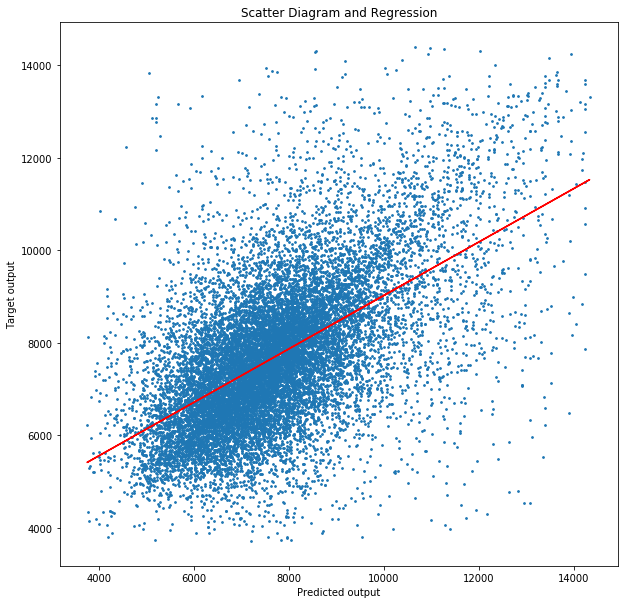

In [237]:
# plot scatter diagram to visualize how well data were predicted
scatter_regression(s_X=s_predicted, s_Y=s_target, same_scale=True)

In [238]:
# Calculate Pearson Correlation Coeficient, the closer to 1 the better
r_pearson_coef, p = pearsonr(y_predicted, y_test)
print('Pearson Correlation Coeficient: {:.2f}, P-value: {}'.format(r_pearson_coef, p))

Pearson Correlation Coeficient: 0.58, P-value: 0.0


In [239]:
s_predicted.describe()

count    17100.000000
mean      7698.957215
std       1606.566043
min       3756.070712
25%       6610.343542
50%       7519.281209
75%       8494.557816
max      14336.089429
Name: Predicted output, dtype: float64

In [240]:
s_target.describe()

count    17100.000000
mean      7691.034754
std       1606.570414
min       3713.954328
25%       6581.161865
50%       7530.123986
75%       8530.366249
max      14393.225435
Name: Target output, dtype: float64

### Conclusion
- positive correlation coefficient
- The Pearson's correlation coefficient droped. Probably data had too many outliers before PCA
- It took short long to train data
- There are many outliers. It should be corrected.

# <center>------------------ METHOD NUMBER II ---------------------------</center>

## Find similar zones based on similar trend:
- splitting data according to Municipal district (external data)
- checking trend
- finding similar zones
- combining Municipal districts into bigger similar zones
- preprocessing
- creating and training model

# INPUT

In [241]:
df = DF_PREPROCESSED.copy()

In [242]:
df.drop(columns=['Transaction_price'], inplace=True)

# 3. Data Preprocessing 

- Location: add Municipal_district

#### Add Municipal_district feature

In [243]:
df_location_dict = pd.read_csv('df_municipal_district_dict.csv')

In [244]:
df_location_dict.head(1)

Admin_district  Geodesic_precinct  Location Municipal_district  \
0  Kraków - Krowodrza                  1         1       VI Bronowice   

        Old_district  
0  BRONOWICE WIELKIE

In [245]:
# create new feature
s = pd.Series(np.full(len(df), np.nan))
# Insert column before 'Location'
loc = np.nonzero(df.columns.to_numpy() == 'Location')
loc = int(loc[0][0])
df.insert(loc, 'Municipal_district', s)

# Assign correct values based on df_location_dict
for label, content in df_location_dict.iterrows():
    index = ( df['Location'] == content['Location'] )
    df.loc[index, 'Municipal_district'] = content['Municipal_district']

In [246]:
df.head(1)

Time      Admin_district  Geodesic_precinct Municipal_district  Location  \
0     1  Kraków - Krowodrza                 43   IV Prądnik Biały        31   

   Floor_area  Price_per_Floor_area  Year_of_construction_class  Floor  \
0        29.0                6206.9                           3      3   

   Building_height  Standard_of_flat  Market_type  Number_of_rooms  \
0                1                 2            0                1   

   Kitchen_separate  Extra_room  
0                 1           0

In [247]:
# Rester index to avoid error
df.reset_index(drop=True, inplace=True)

### Visualization of trend for each Municipal district

1


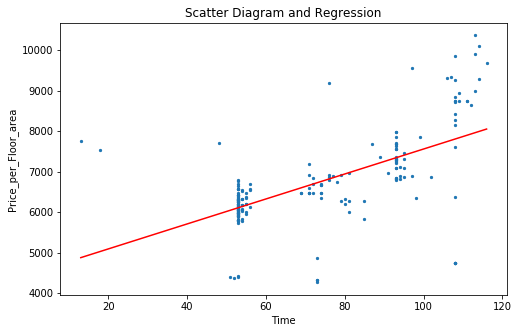

2


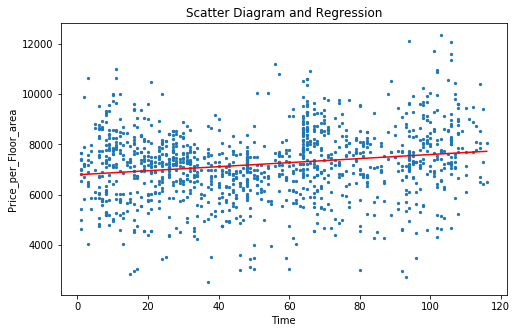

3


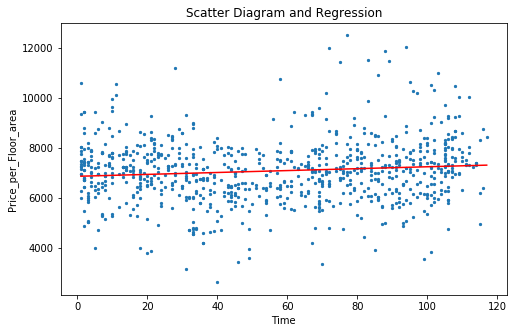

4


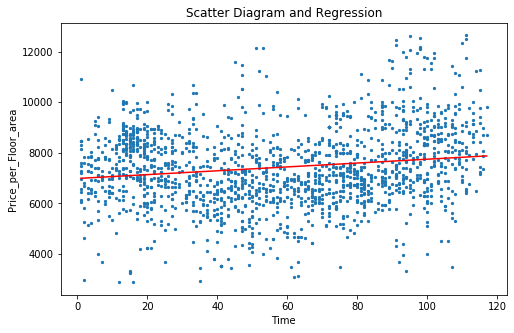

5


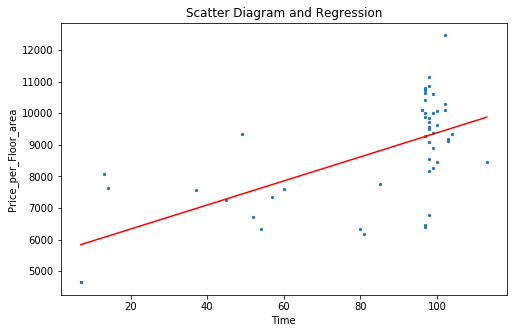

6


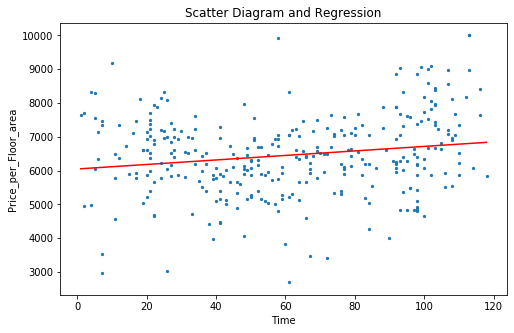

7


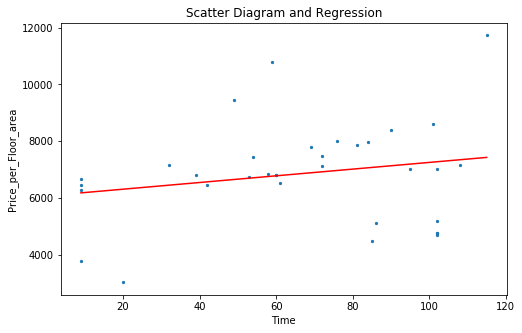

8


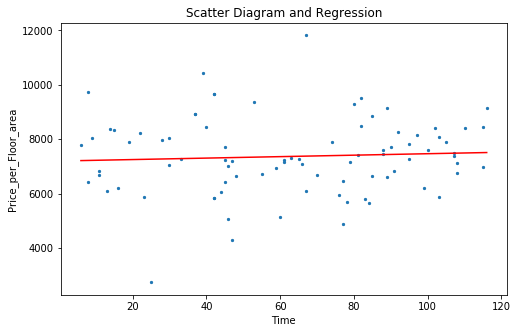

9


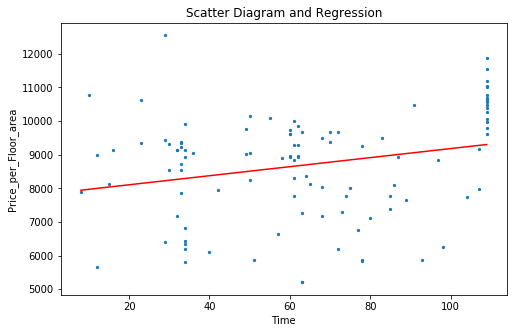

10


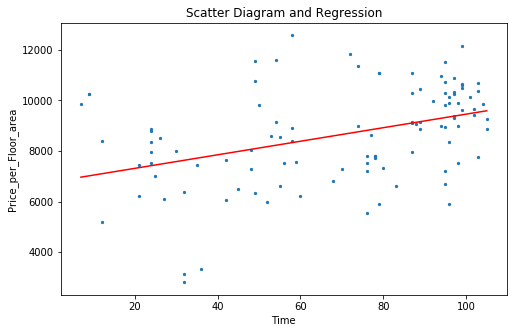

11


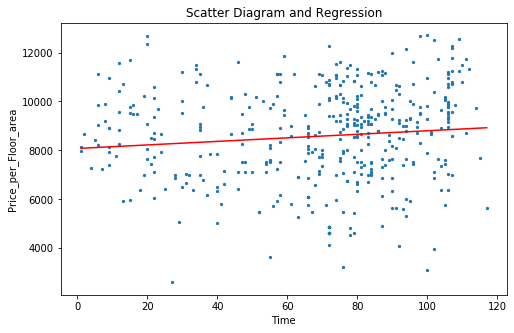

12


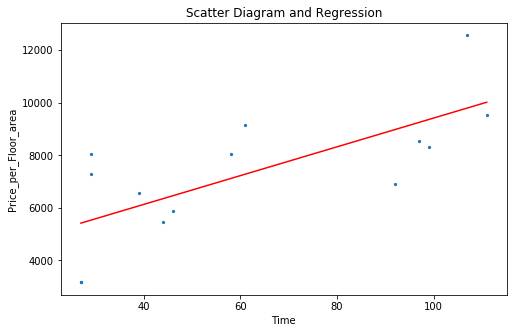

13


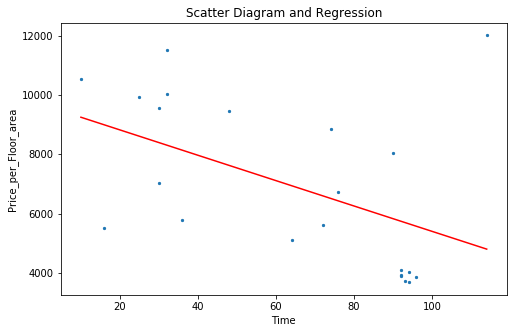

14


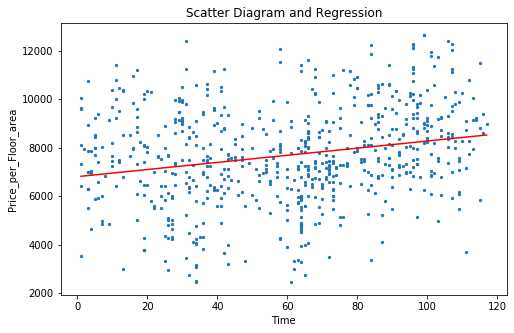

15


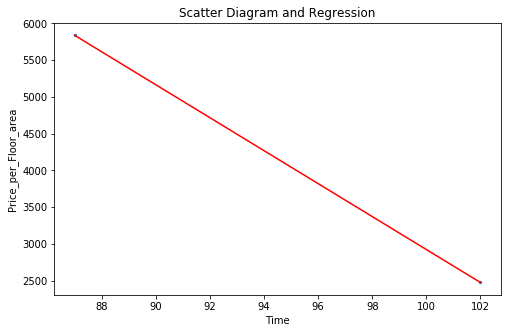

16


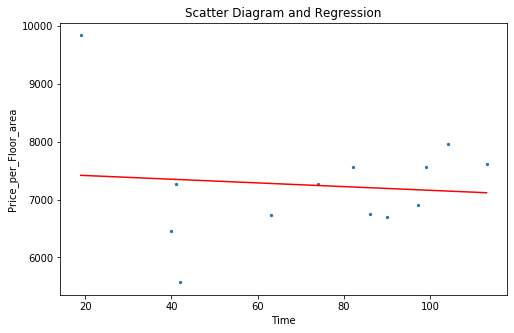

17


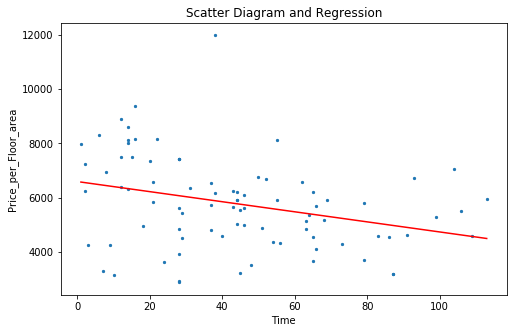

18


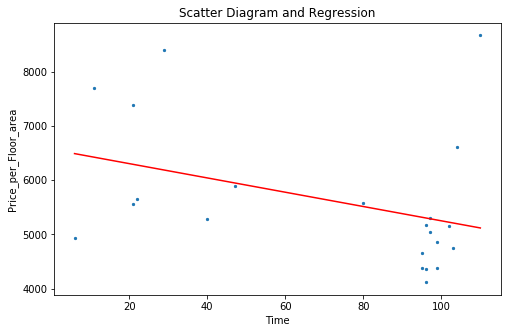

19


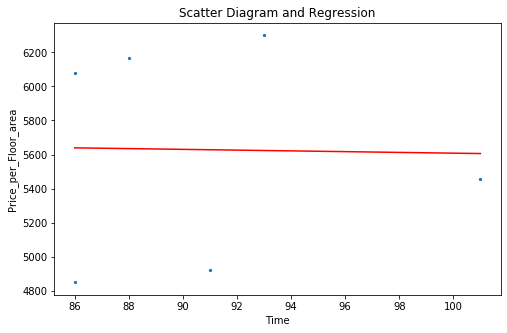

20


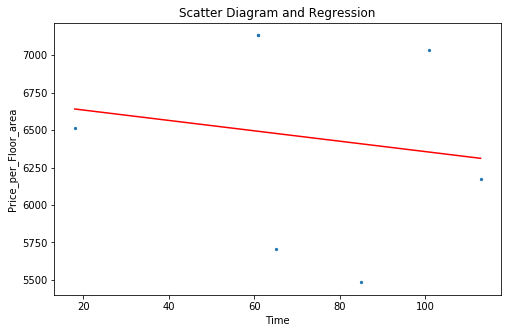

21


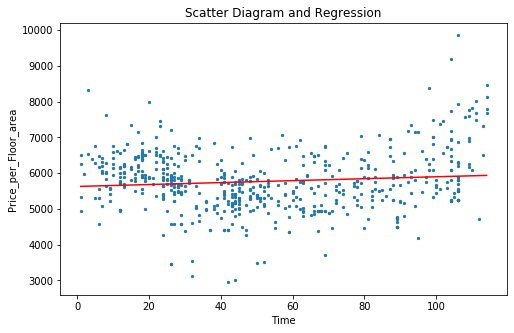

22


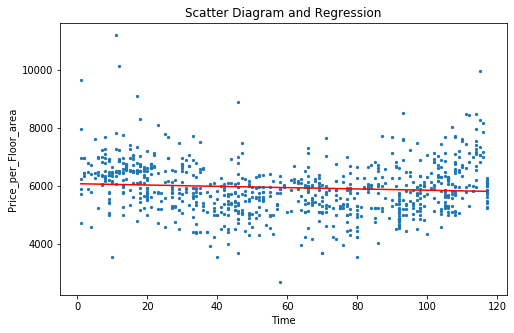

23


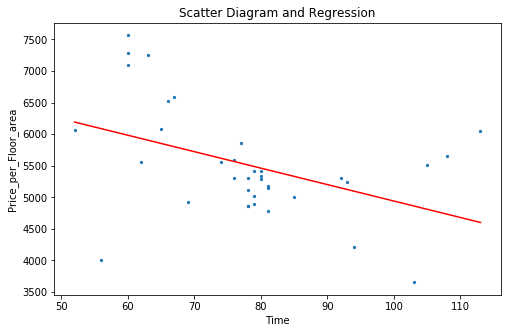

24


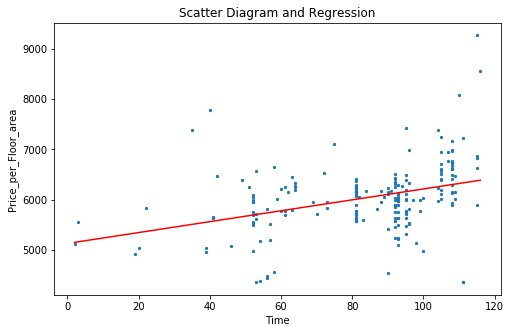

25


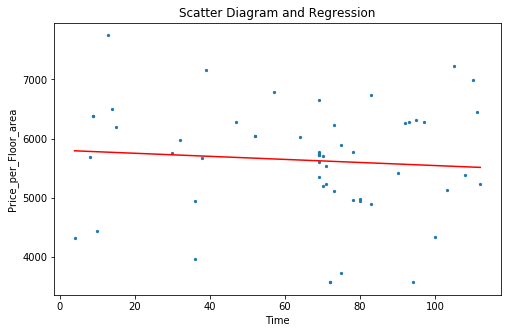

26


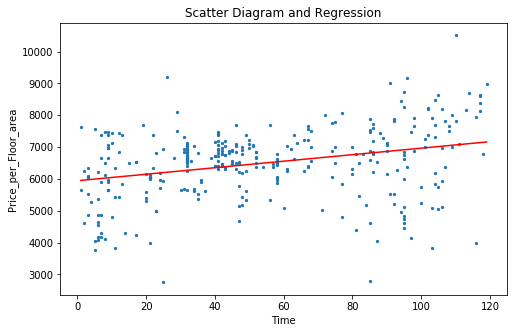

27


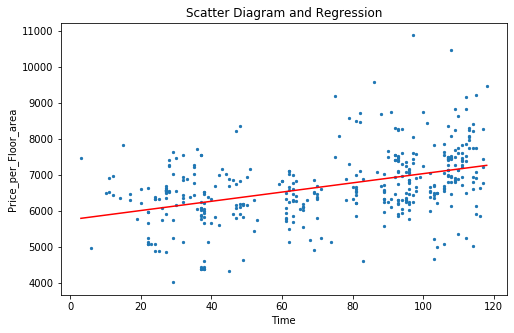

28


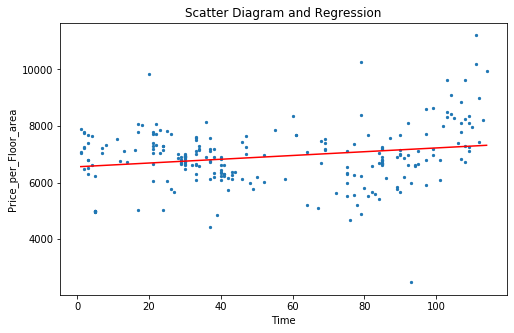

29


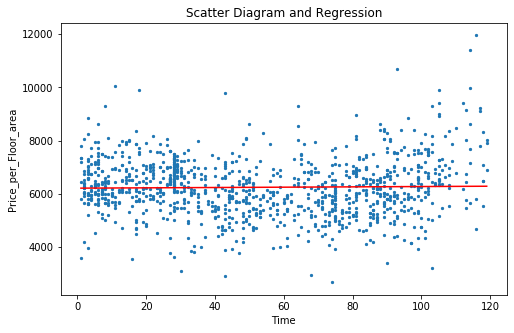

30


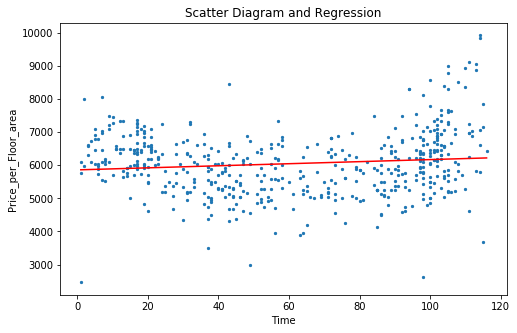

31


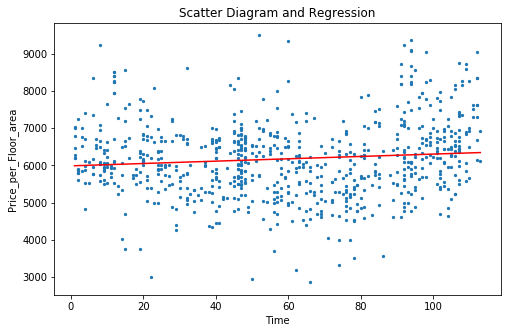

32


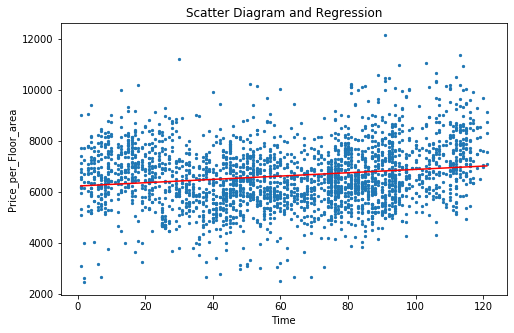

33


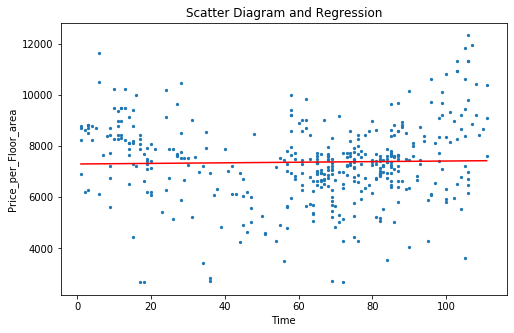

34


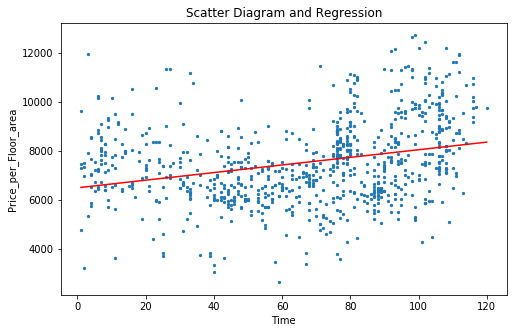

35


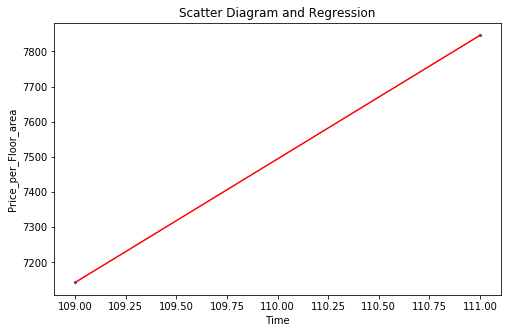

36


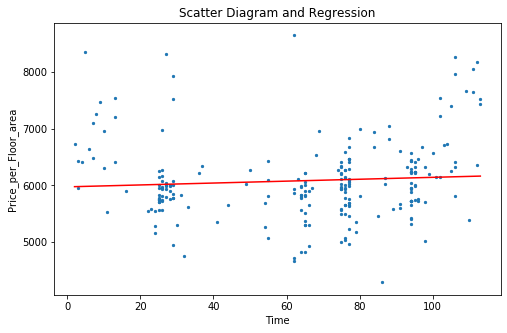

37


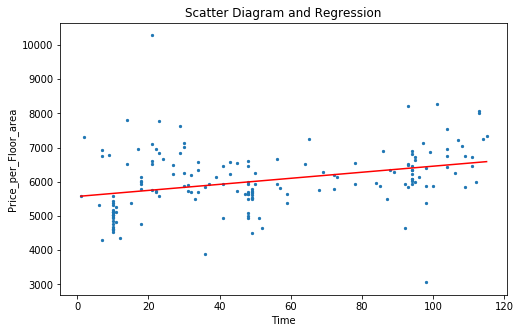

38


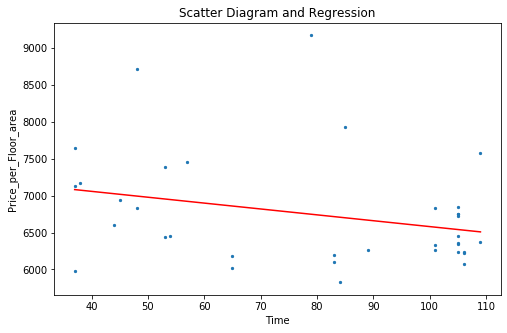

39


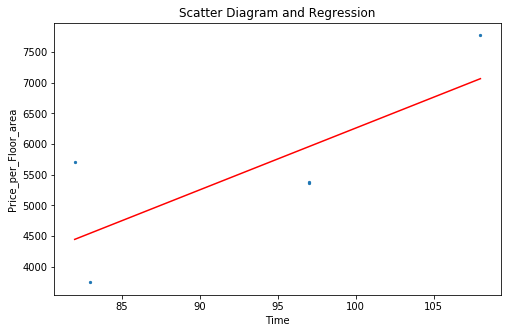

40


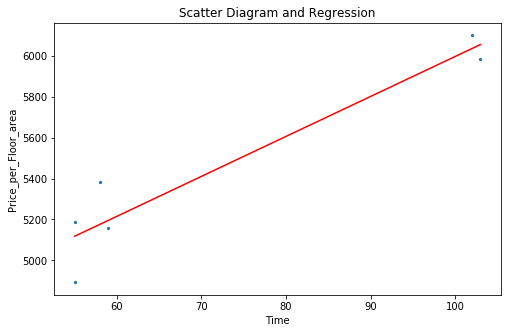

41


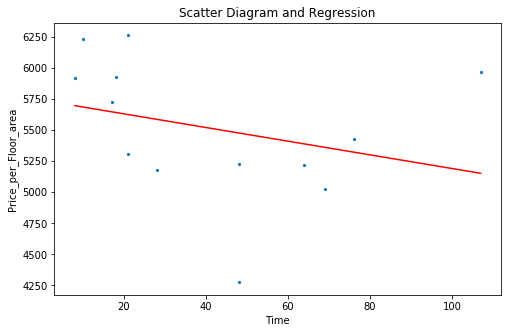

42


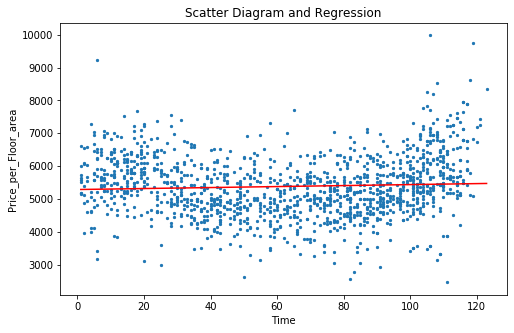

43


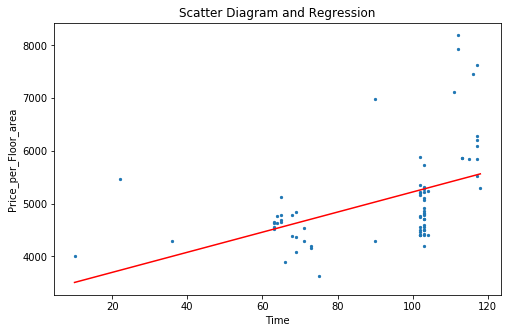

44


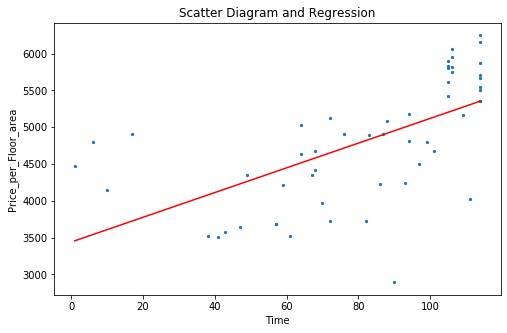

45


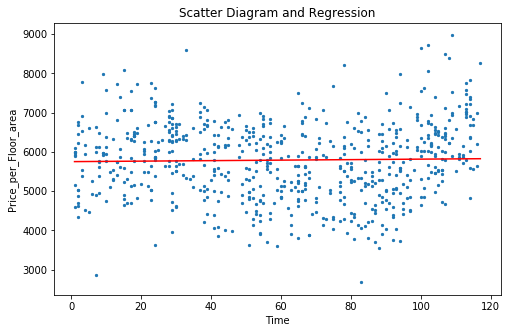

46


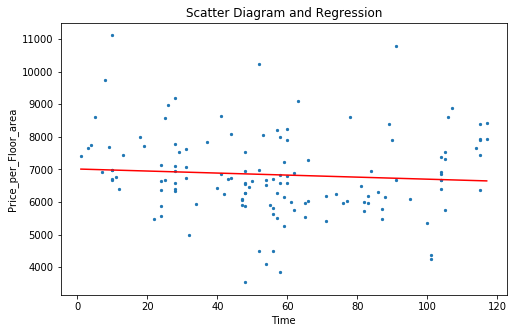

47


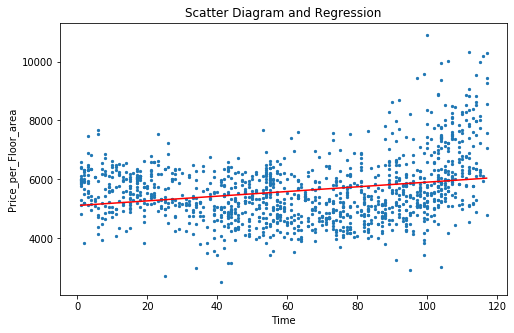

48


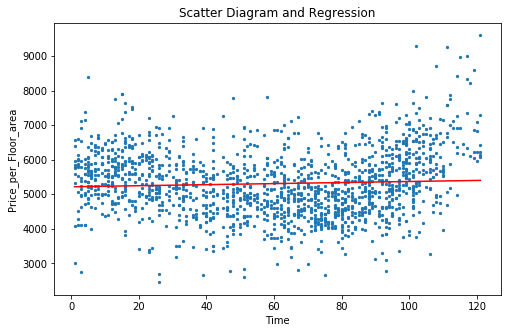

49


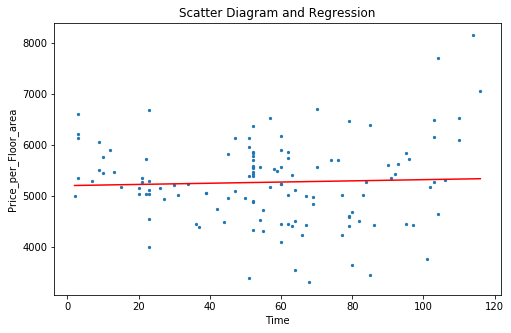

50


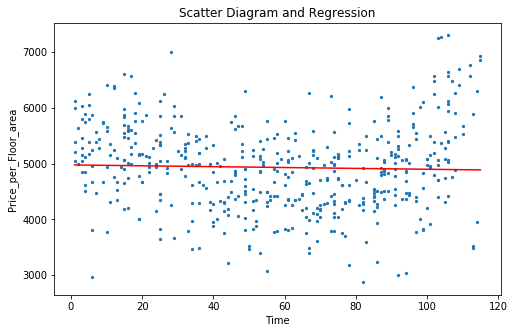

51


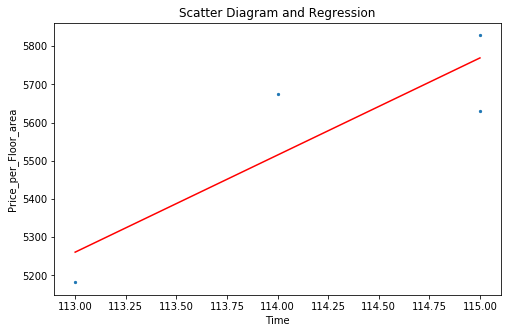

52


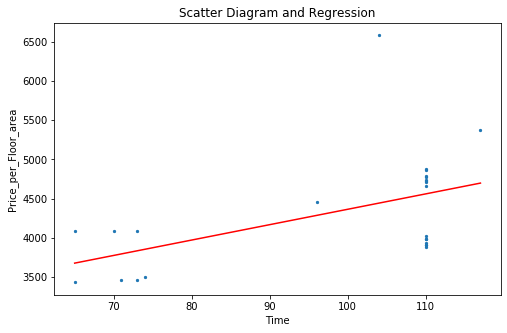

53


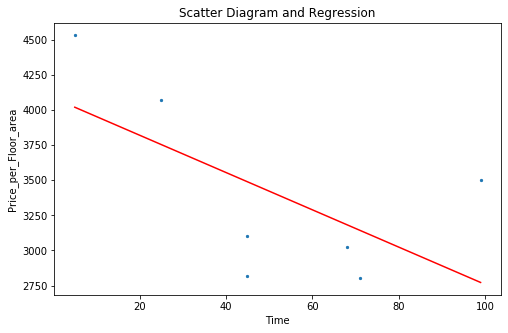

55


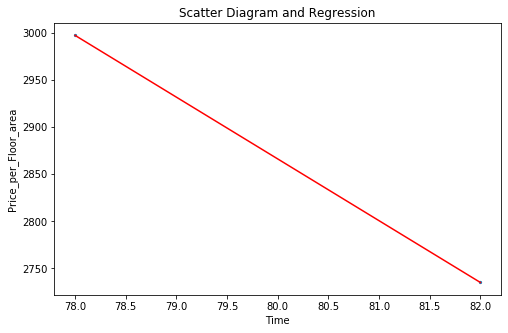

56


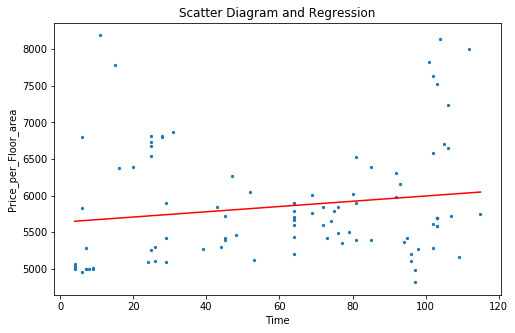

57


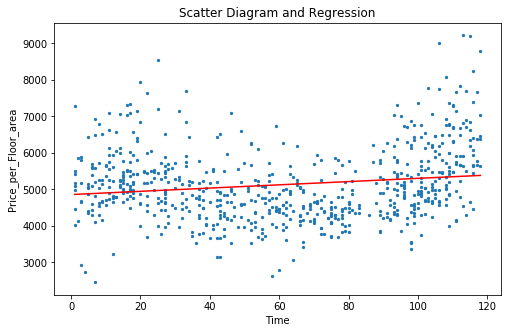

58


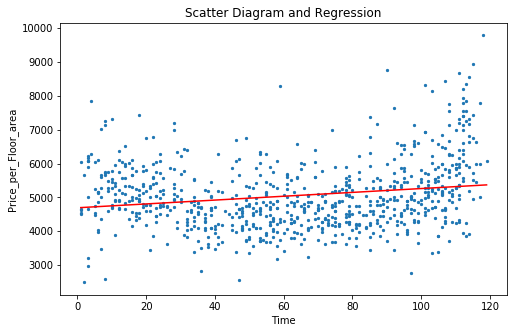

59


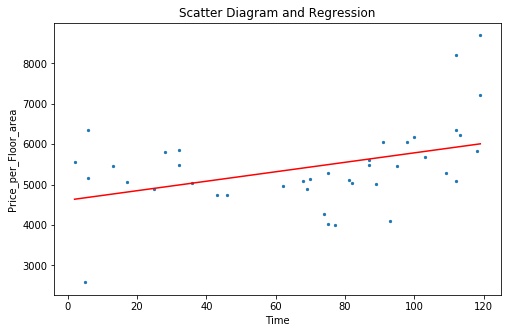

60


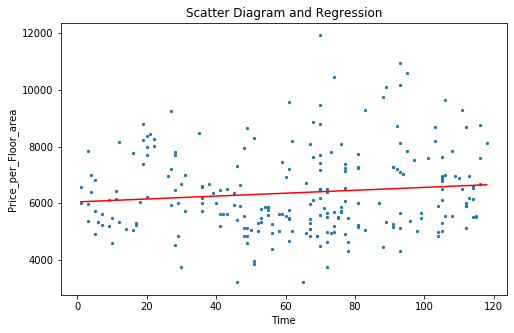

61


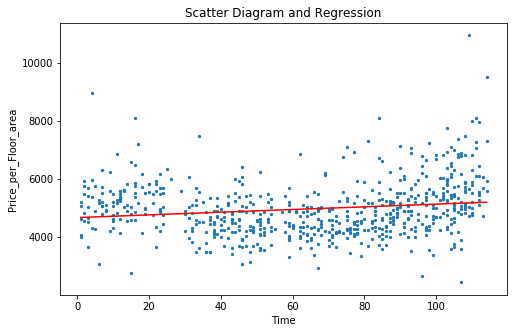

62


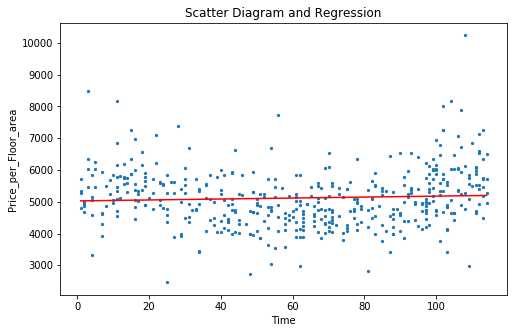

63


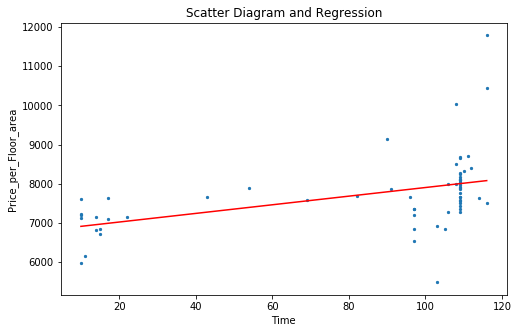

64


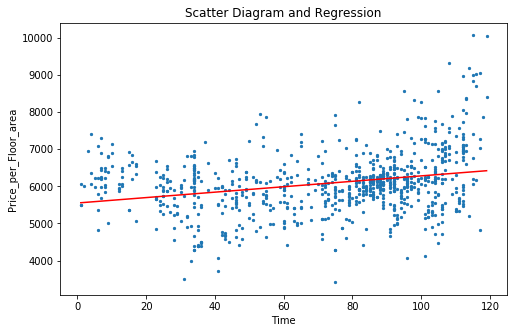

65


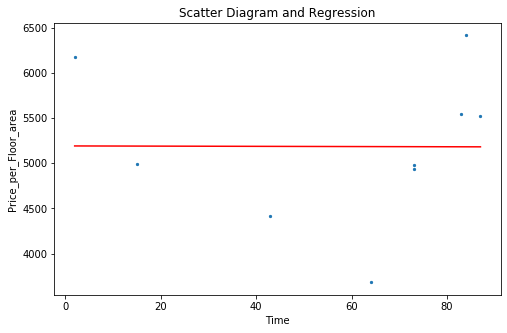

66


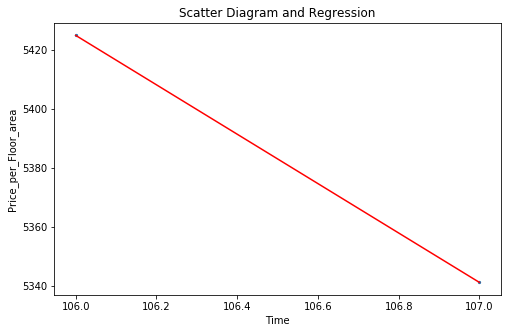

67


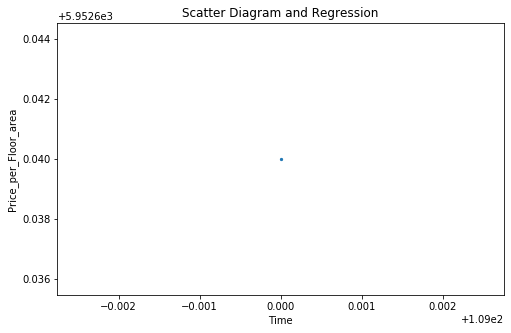

68


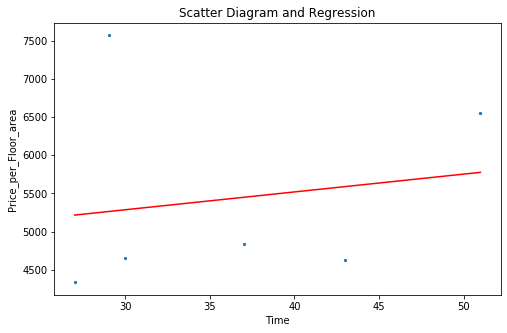

69


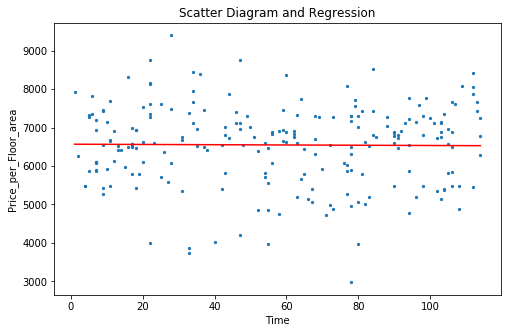

70


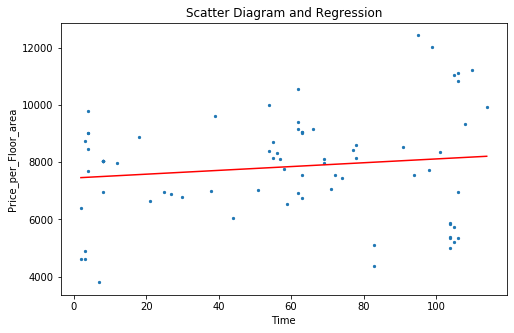

71


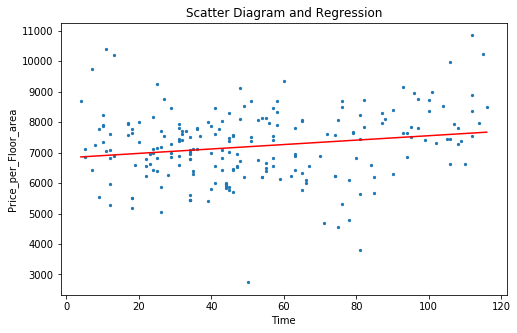

72


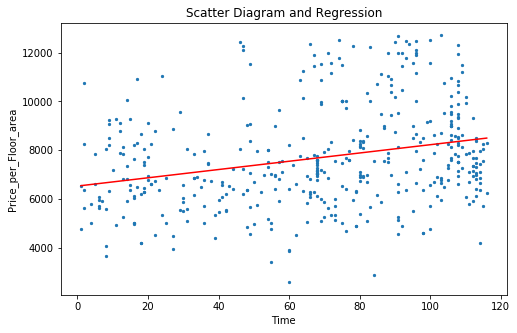

73


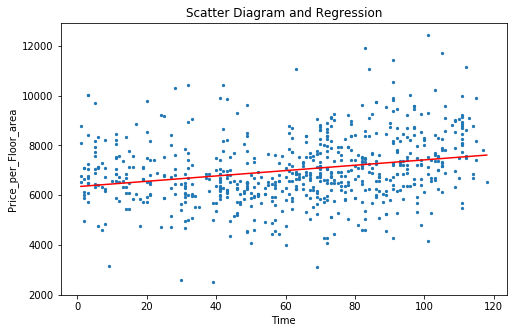

74


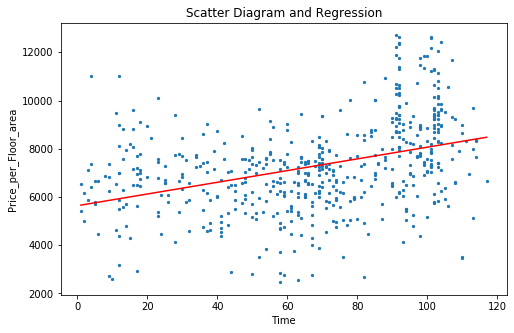

75


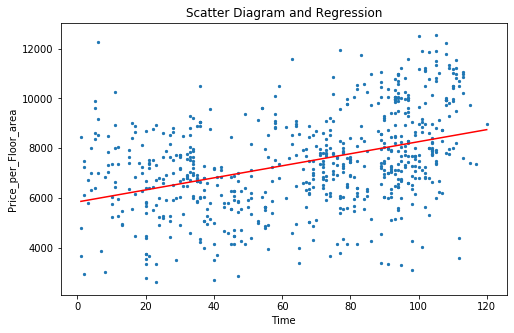

76


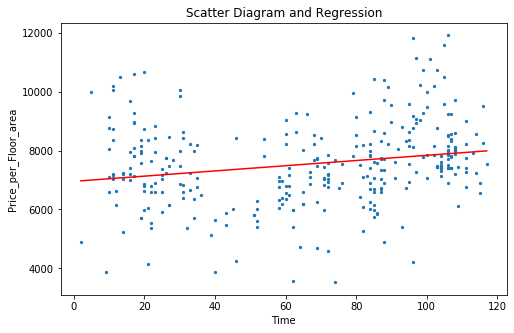

77


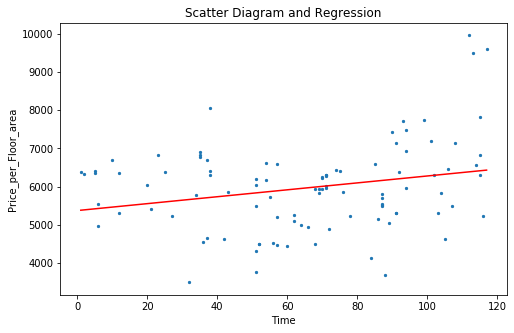

78


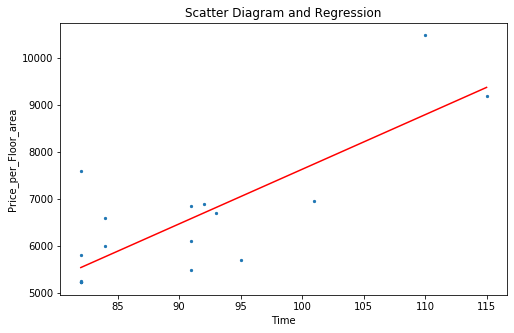

79


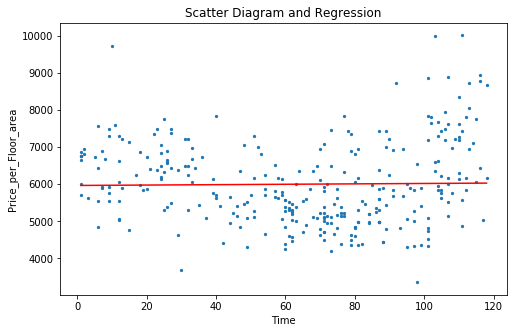

80


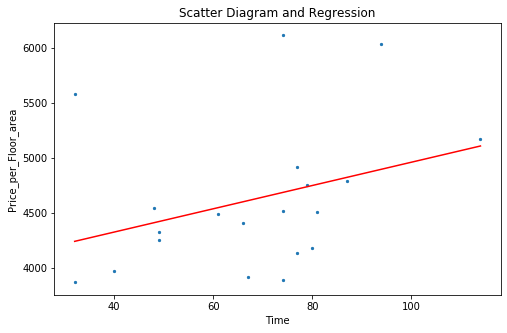

81


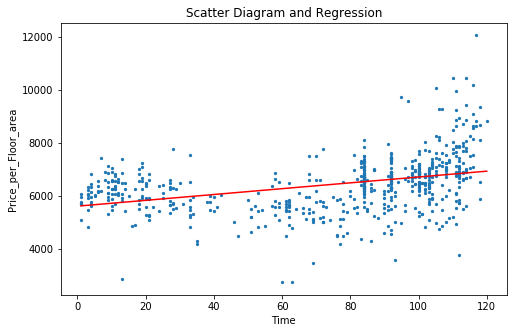

82


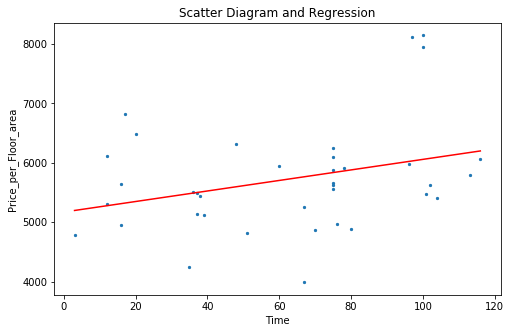

83


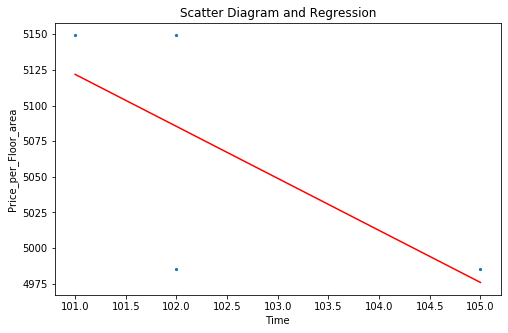

84


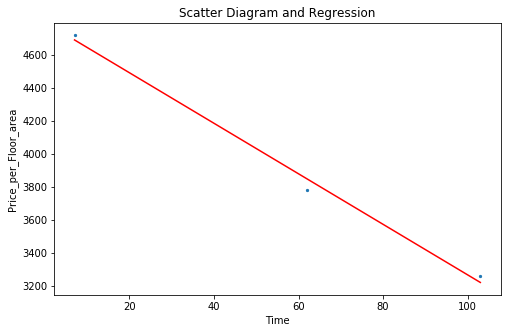

85


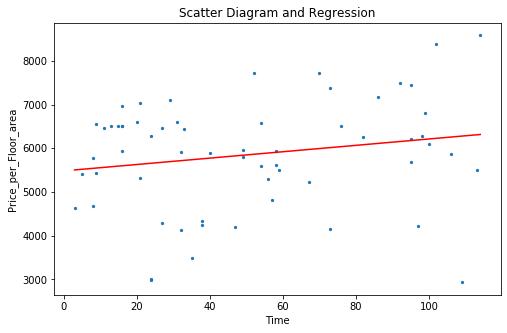

86


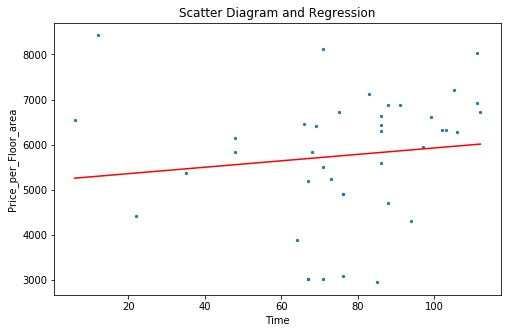

87


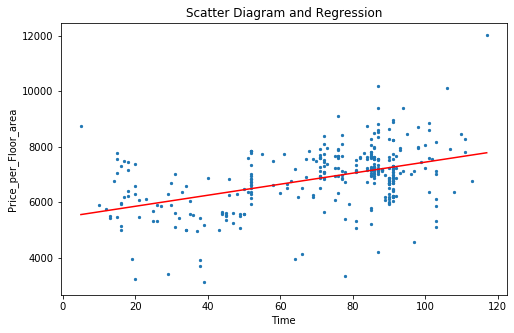

88


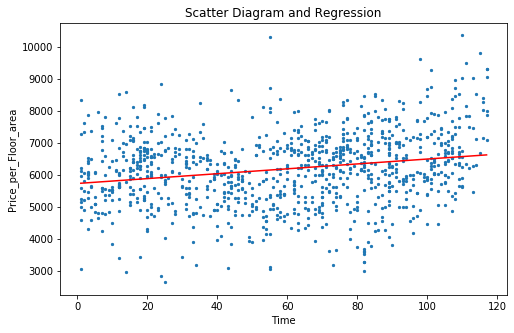

89


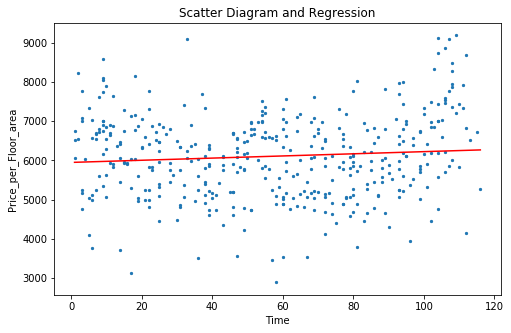

90


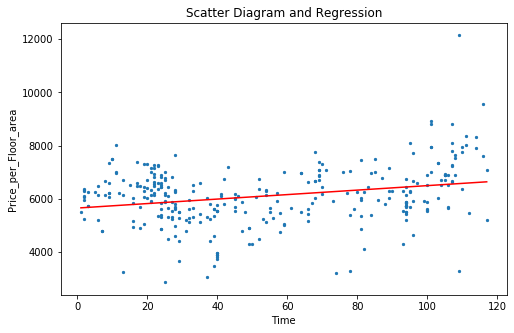

91


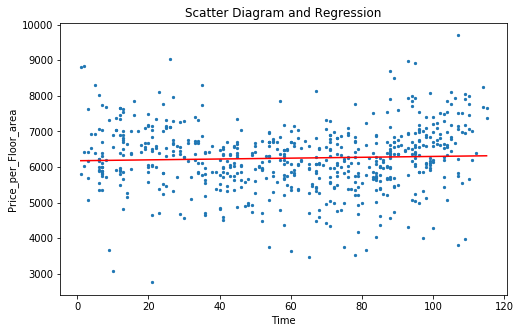

92


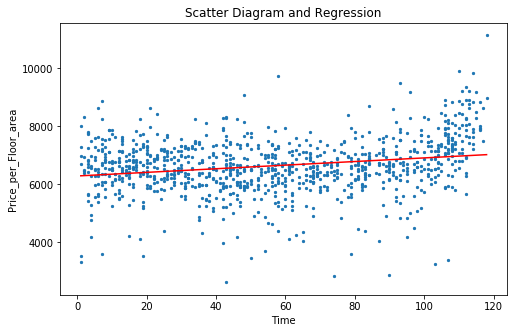

93


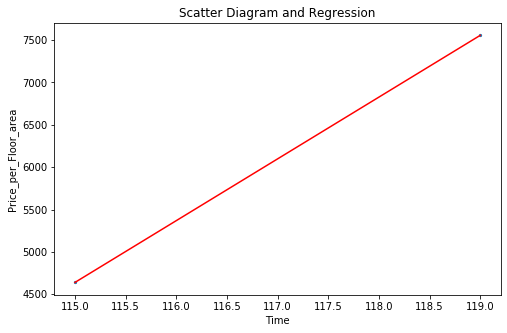

94


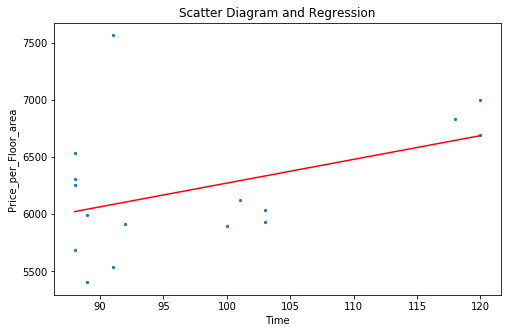

95


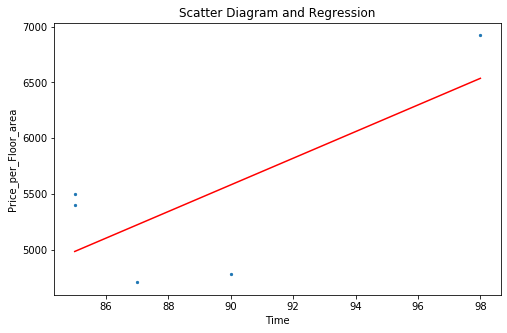

96


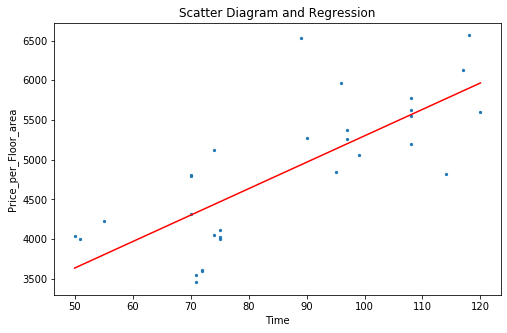

97


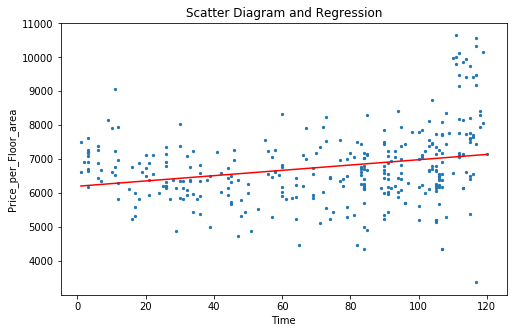

98


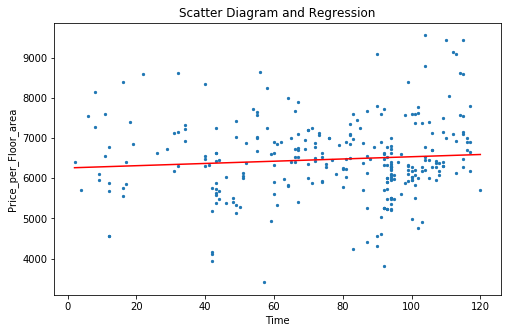

99


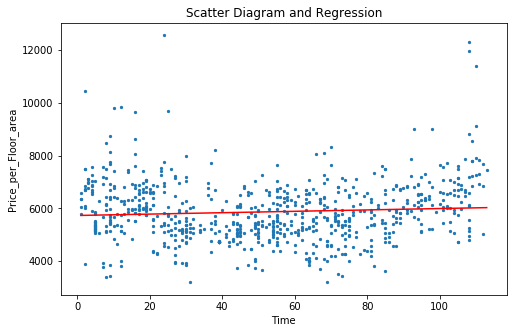

100


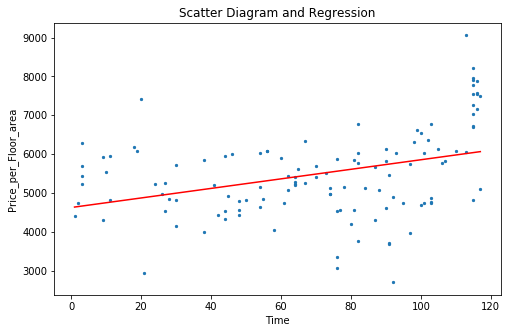

101


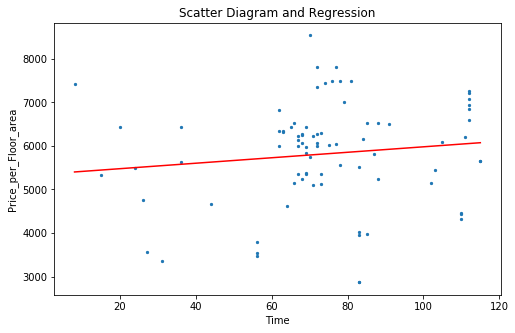

102


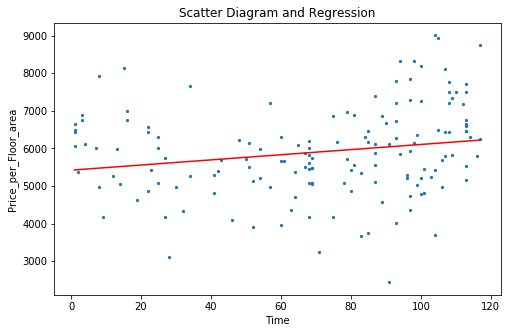

103


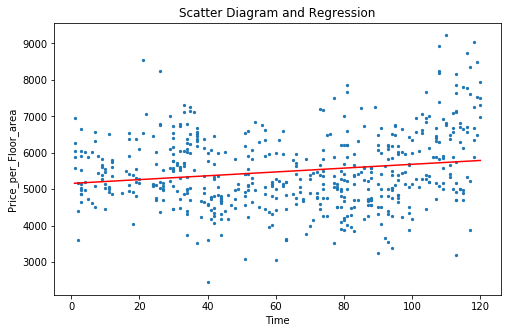

104


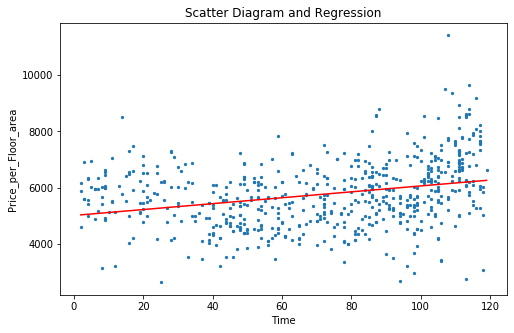

105


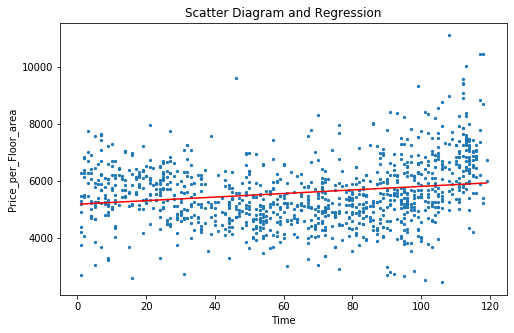

106


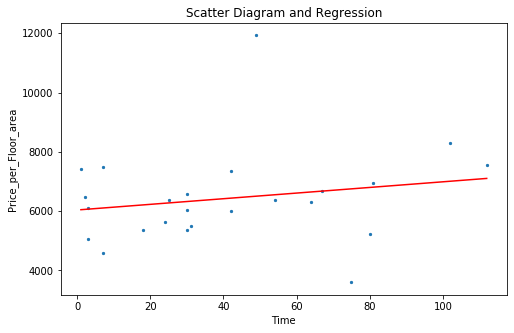

107


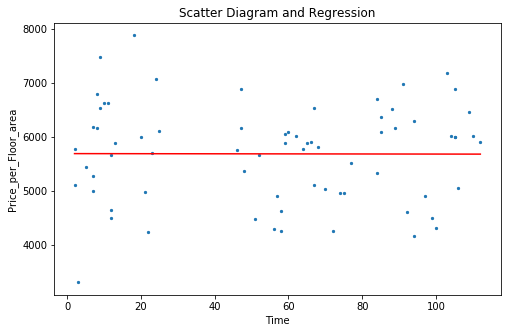

108


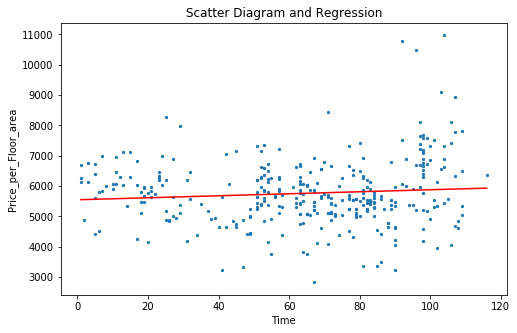

109


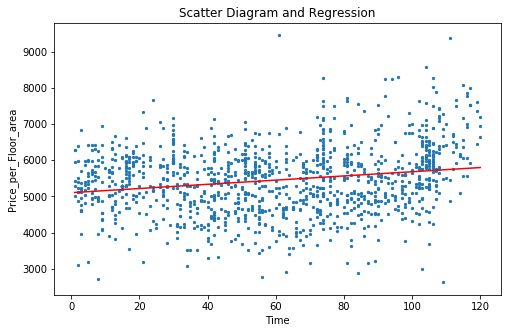

110


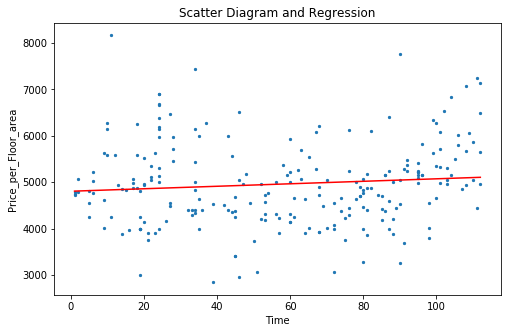

111


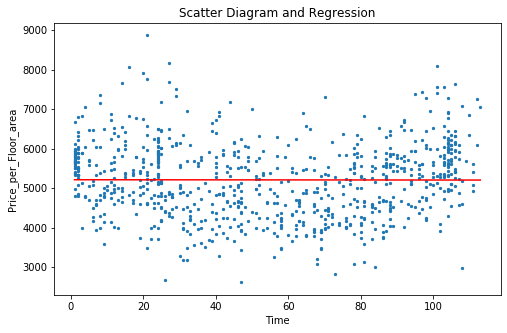

112


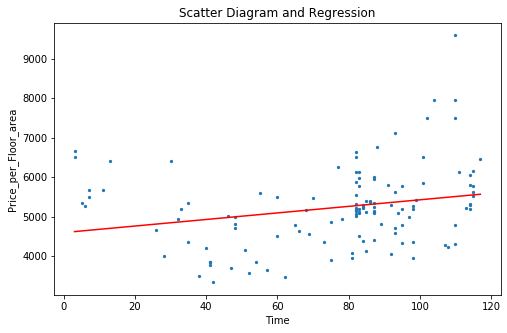

113


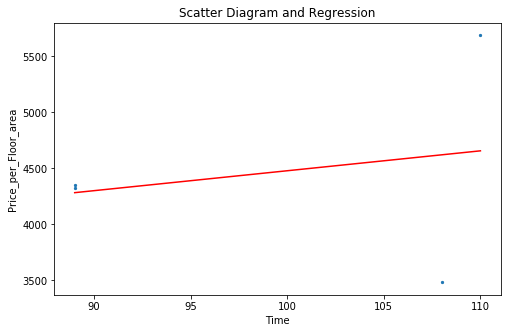

114


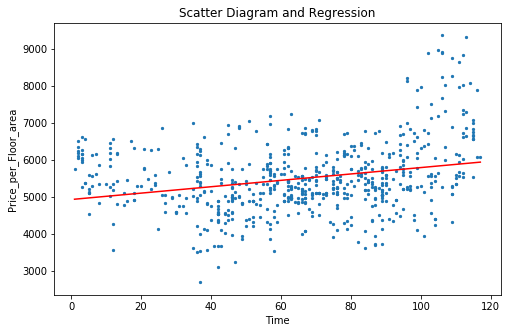

115


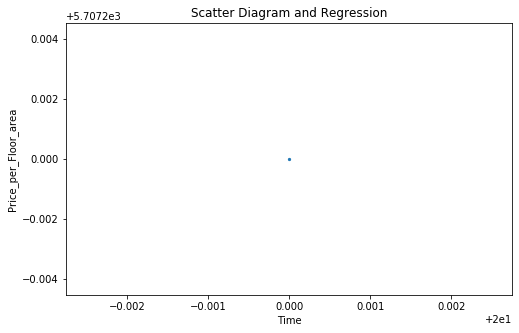

116


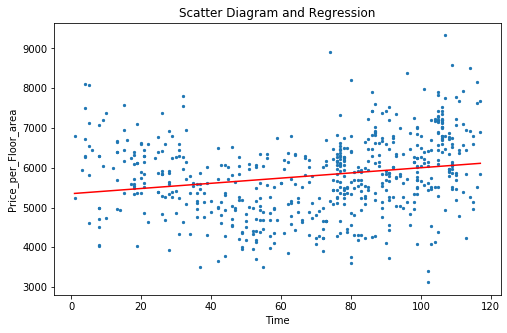

117


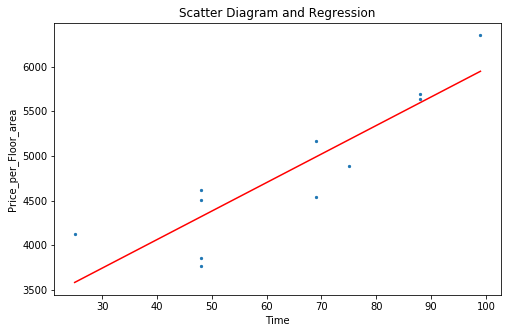

118


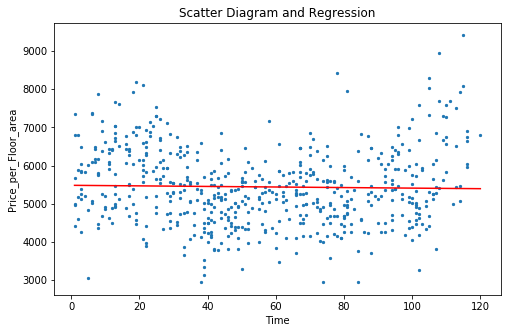

119


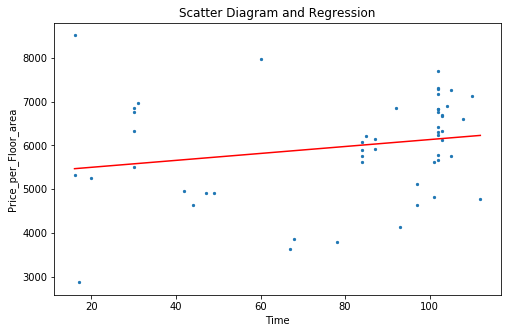

120


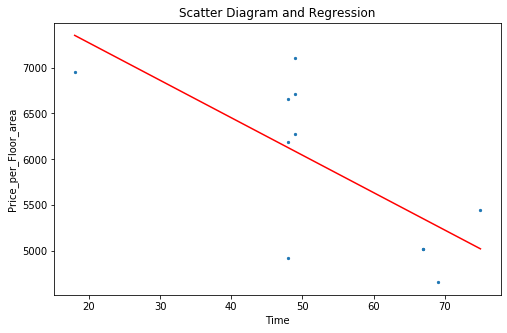

121


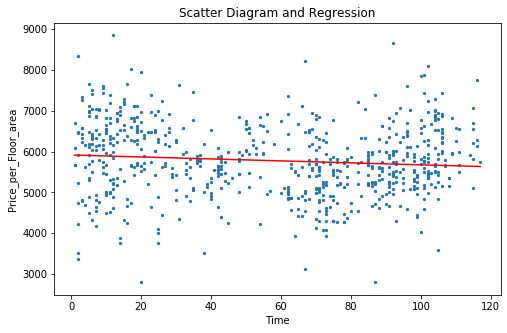

122


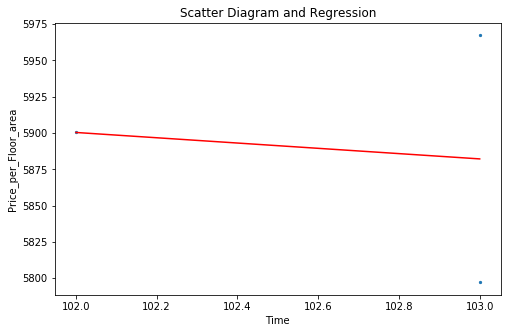

123


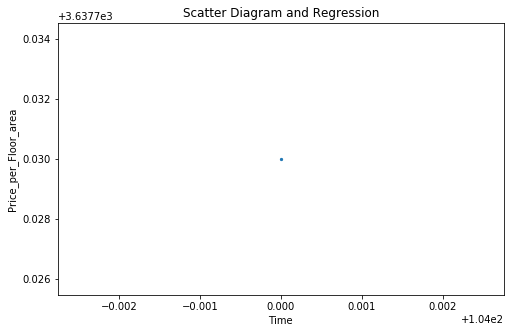

124


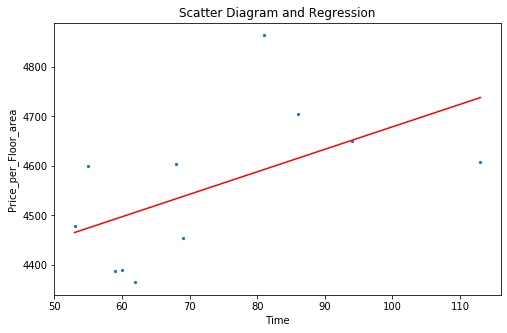

125


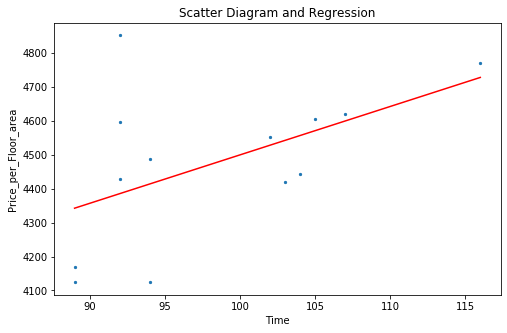

126


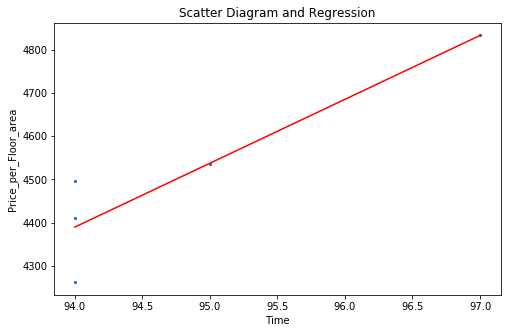

127


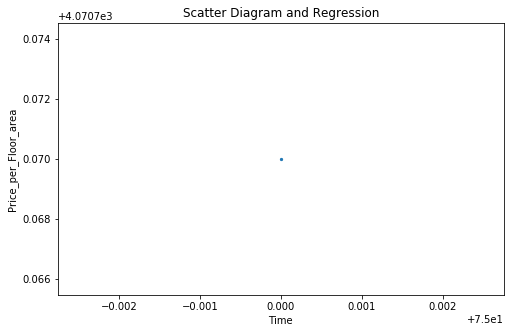

128


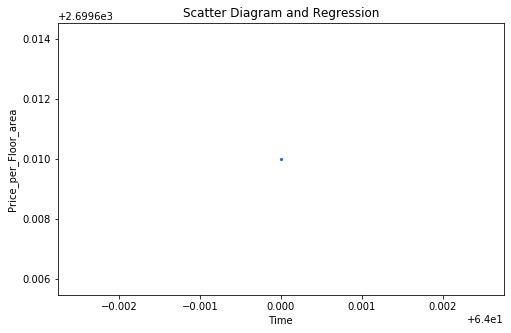

129


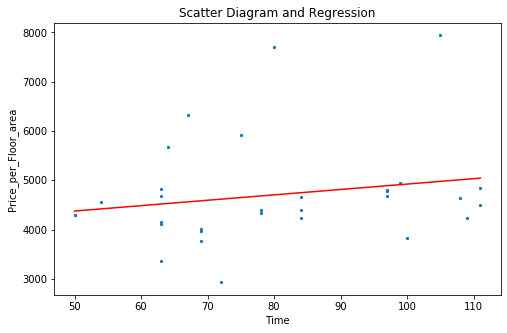

130


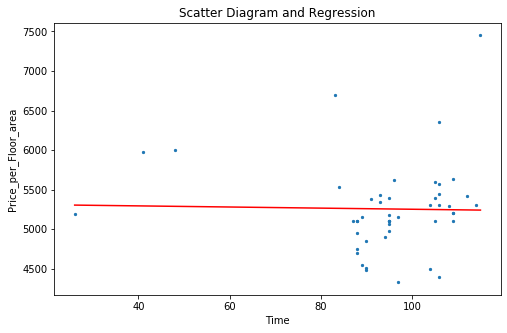

131


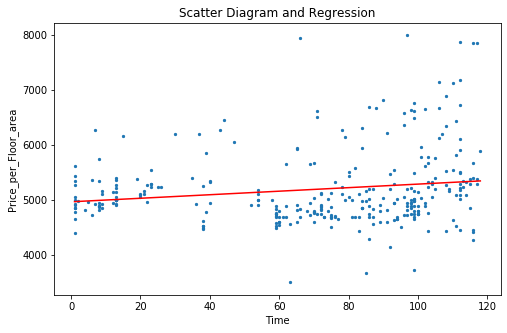

132


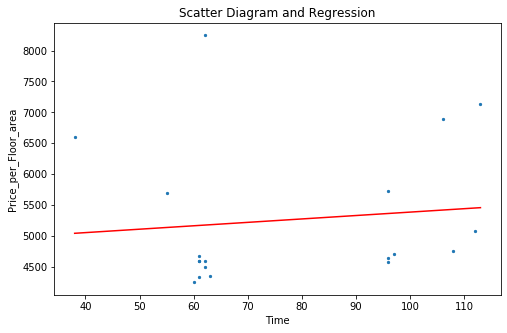

133


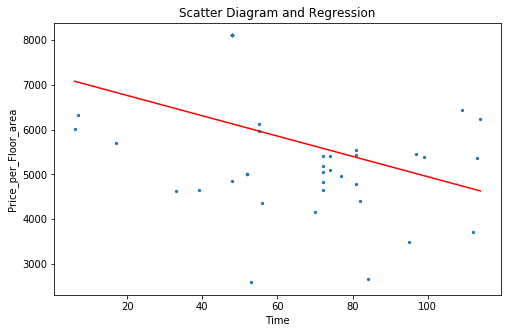

134


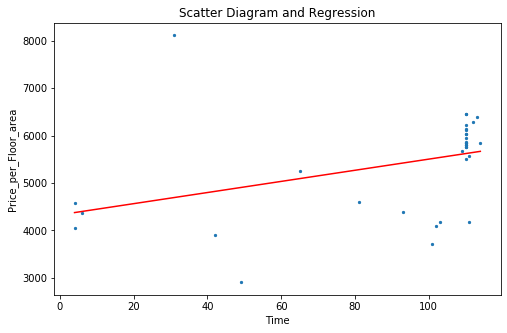

135


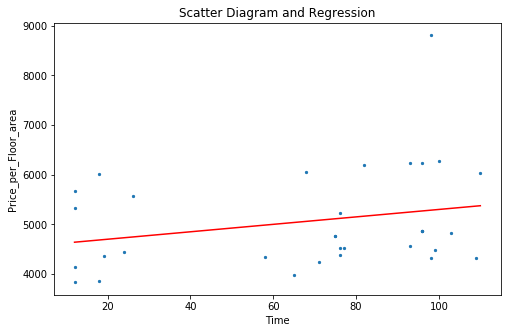

136


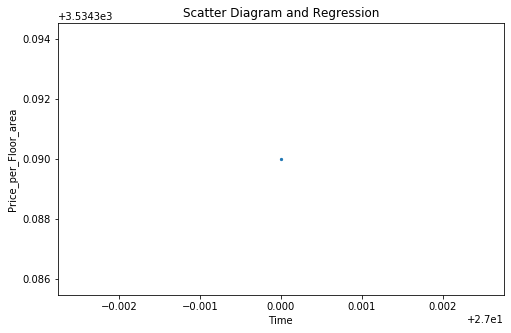

137


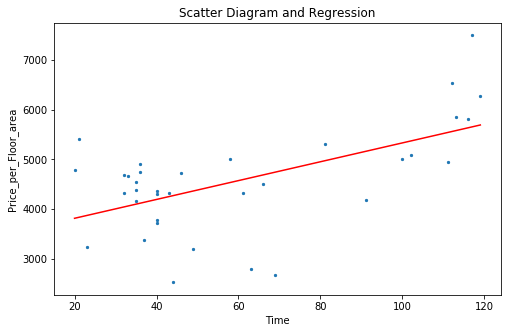

138


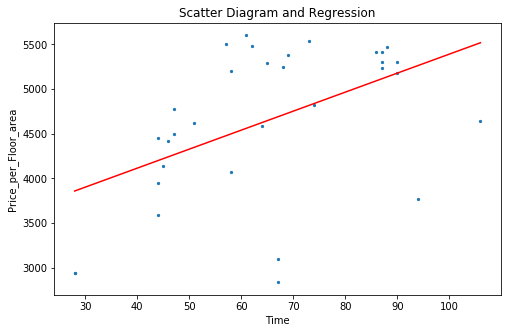

139


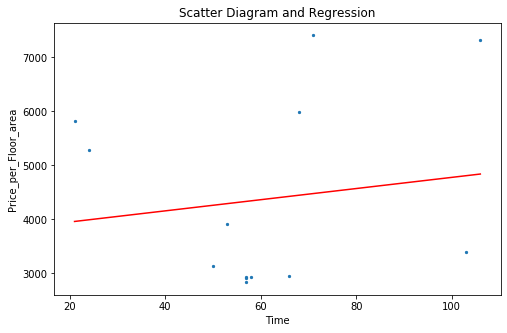

140


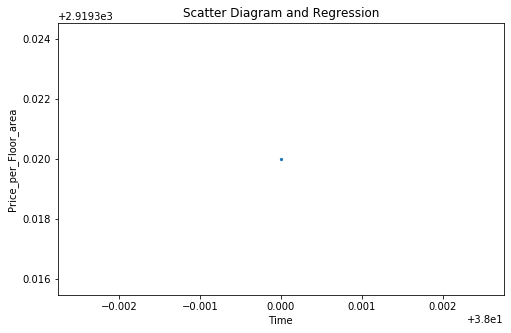

141


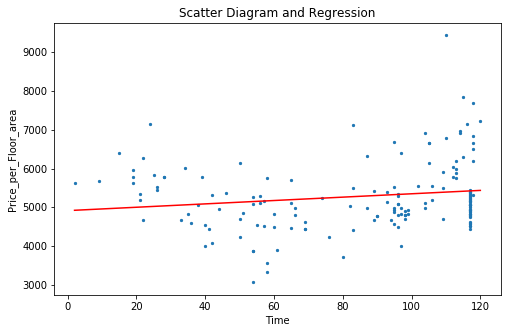

142


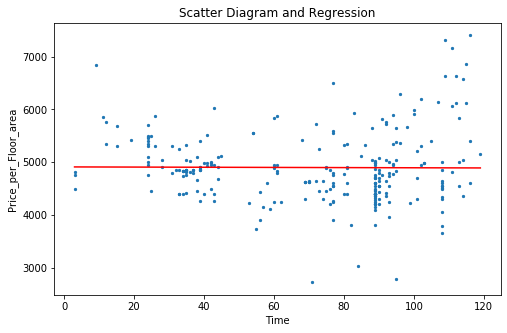

143


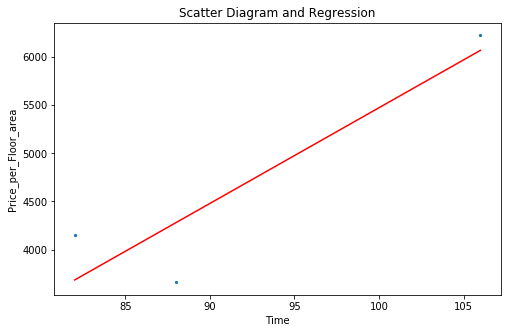

145


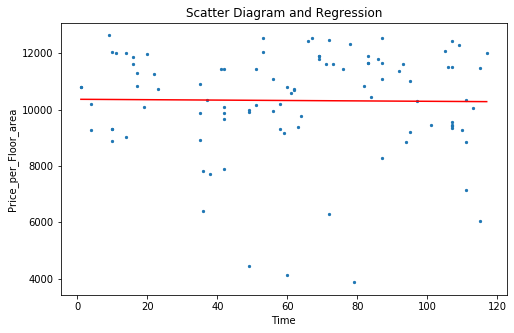

146


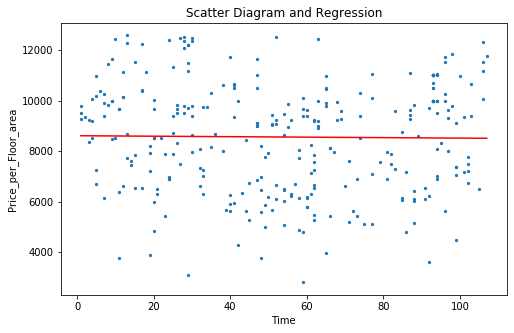

147


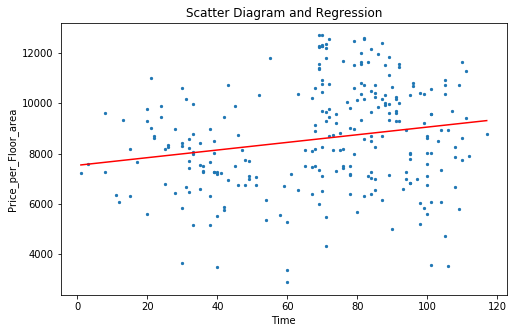

148


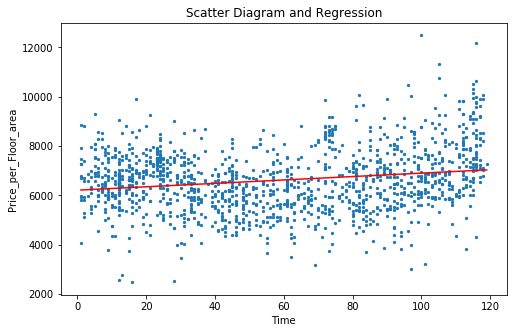

149


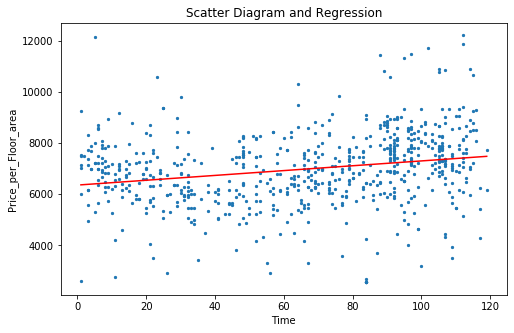

150


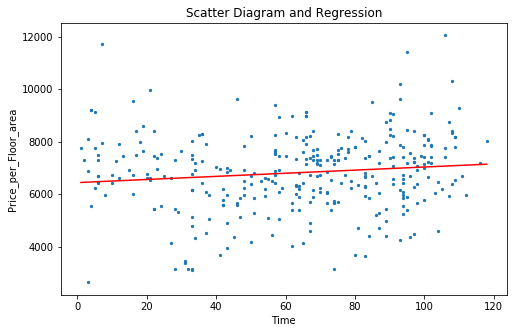

151


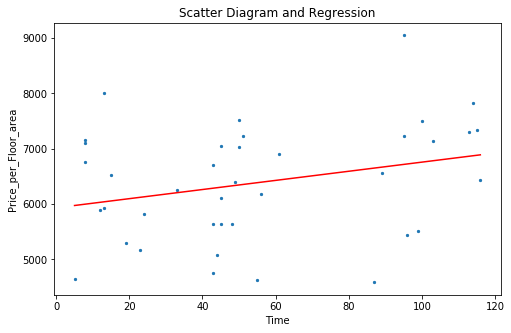

152


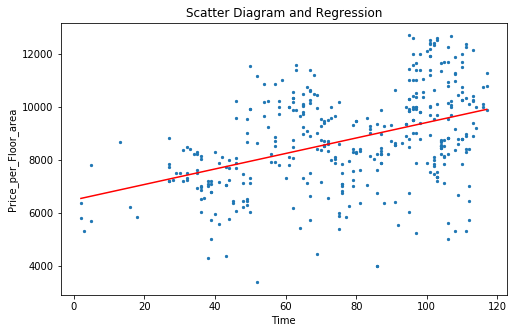

153


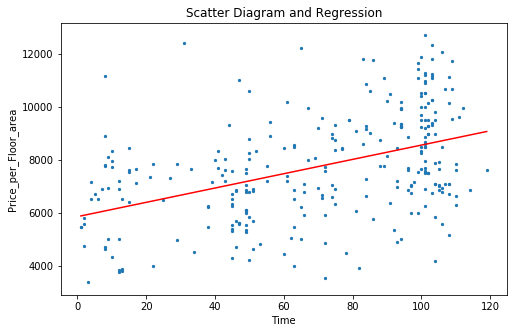

154


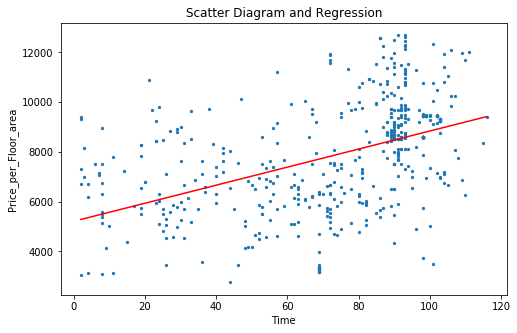

155


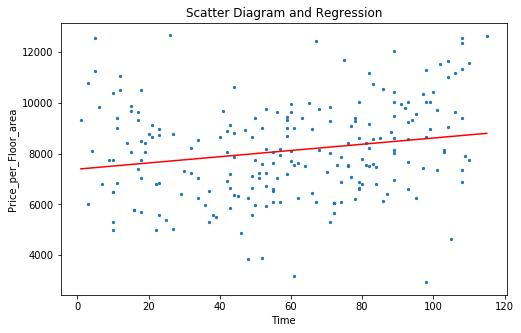

156


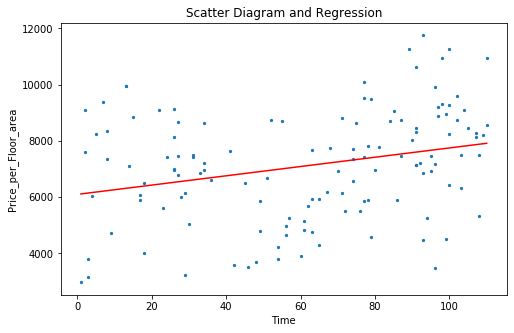

157


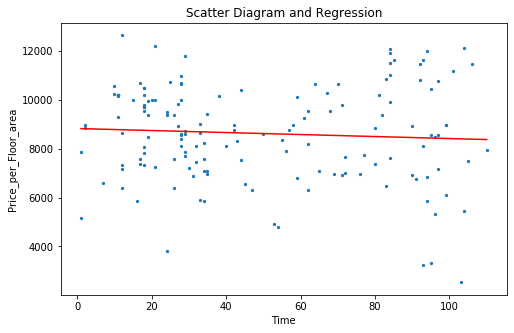

158


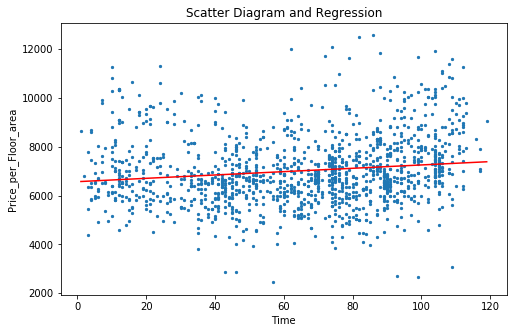

159


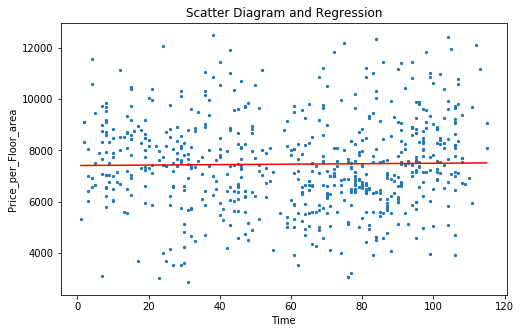

160


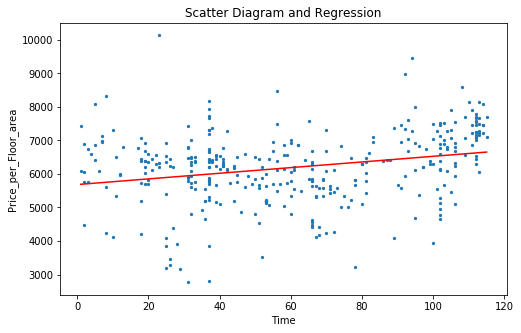

161


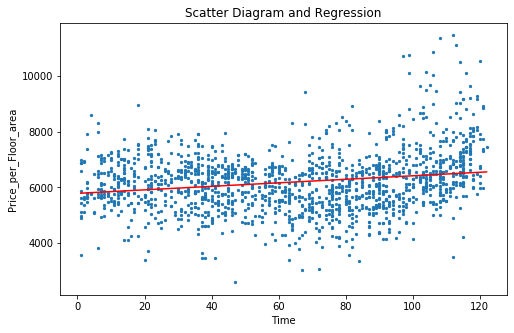

162


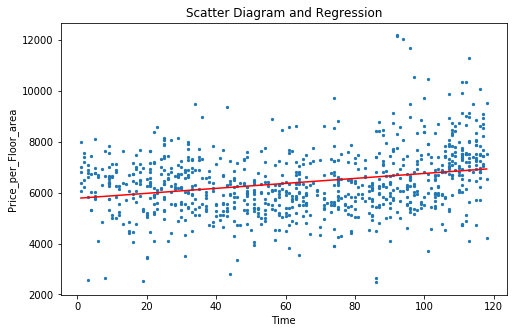

163


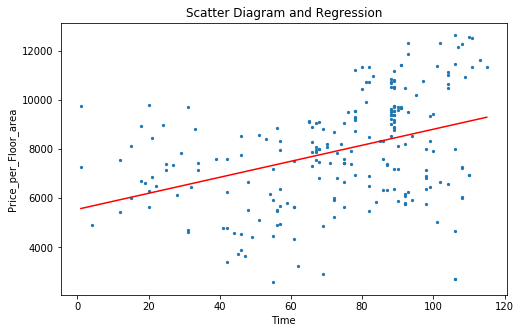

164


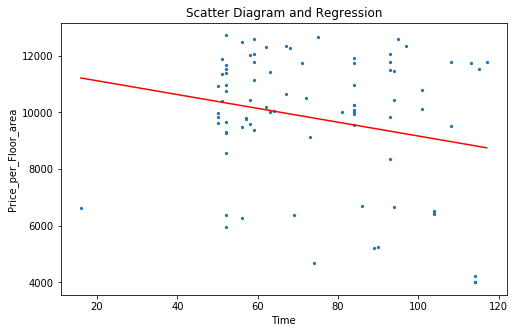

165


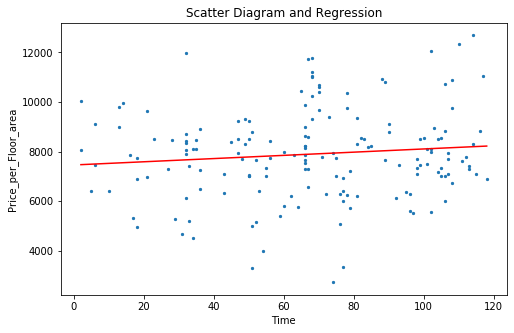

166


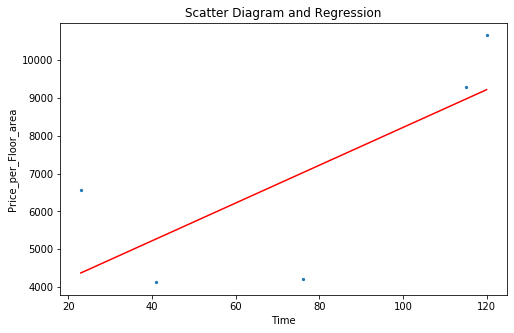

167


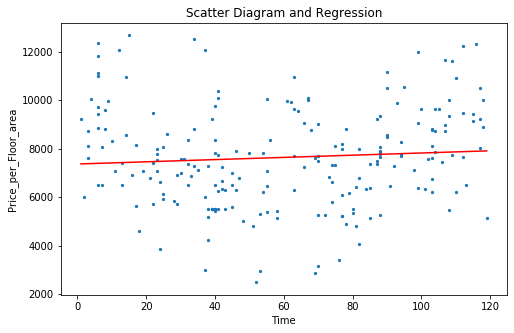

168


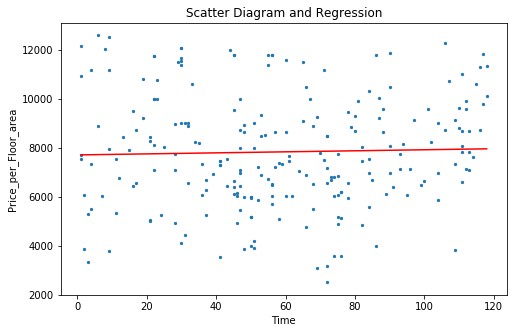

169


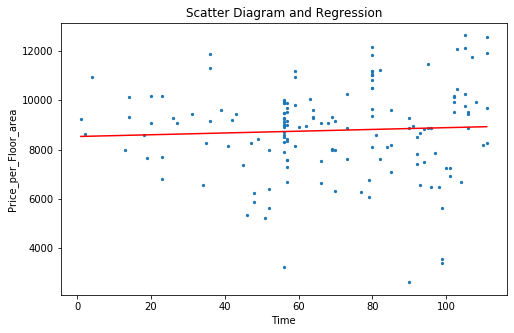

170


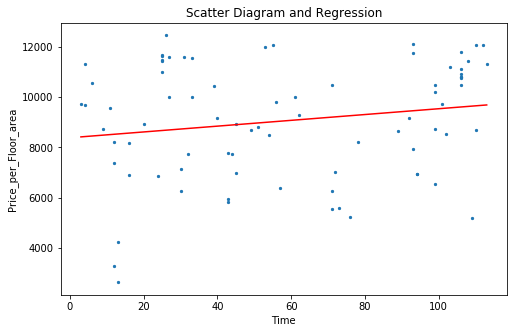

171


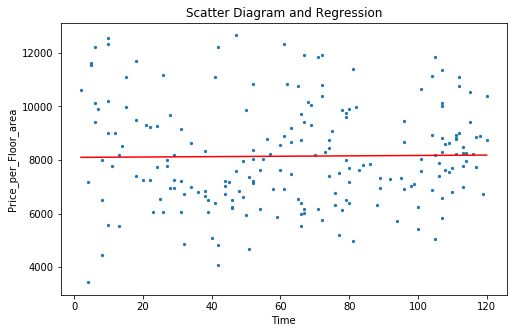

172


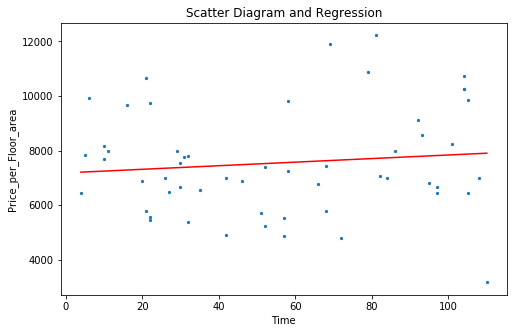

173


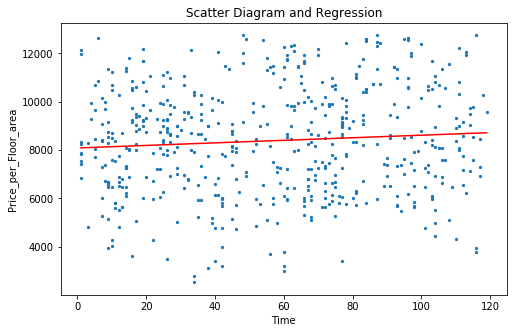

174


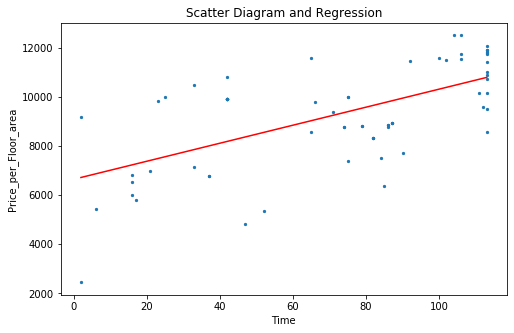

175


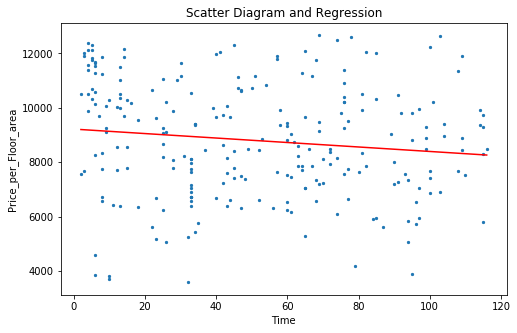

176


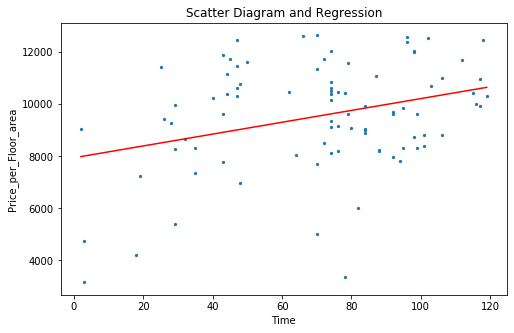

177


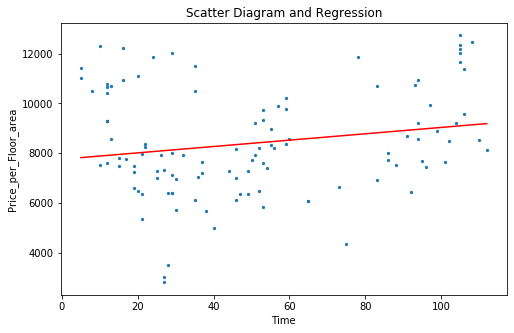

In [248]:
for group_name, df_group in df.groupby('Location'):
    print(group_name)
    scatter_regression(s_X=df_group['Time'], s_Y=df_group['Price_per_Floor_area'], same_scale=False, figsize=(8, 5), s=5)

### Visualization of trend for each Municipal district

I Stare Miasto


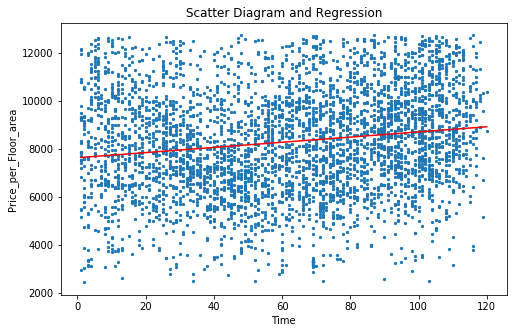

II Grzegórzki


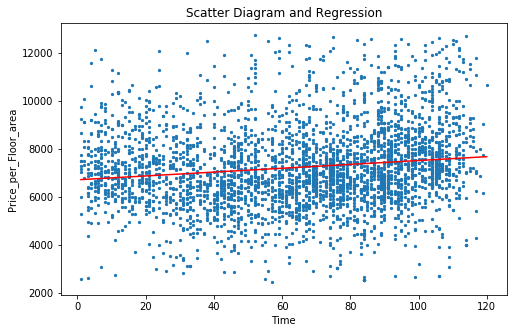

III Prądnik Czerwony


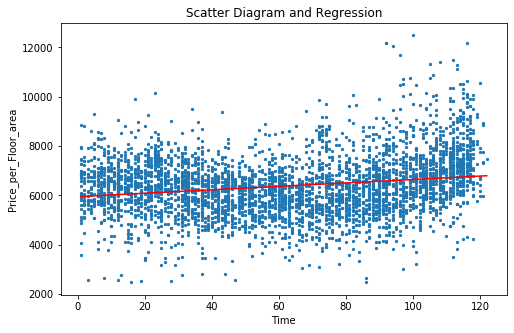

IV Prądnik Biały


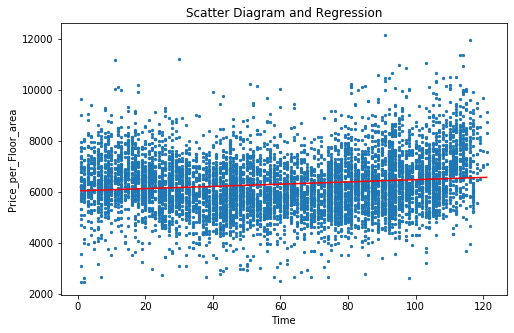

IX Łagiewniki-Borek Fałęcki


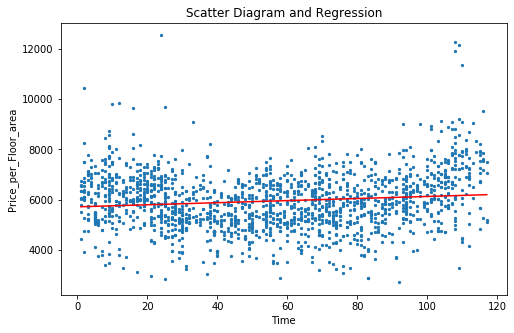

V Krowodrza


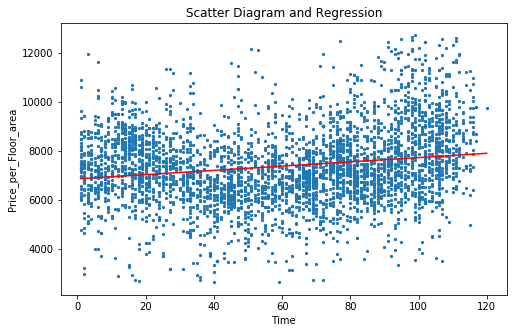

VI Bronowice


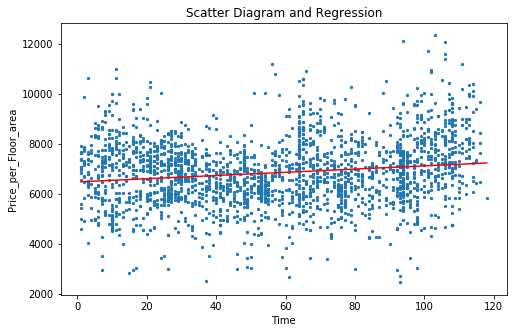

VII Zwierzyniec


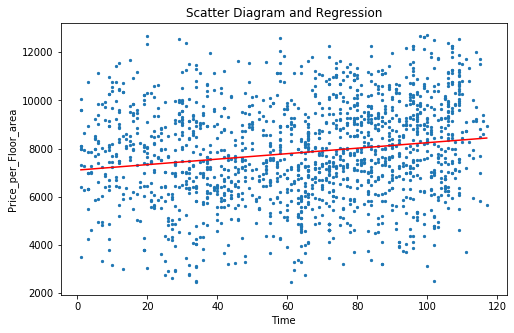

VIII Dębniki


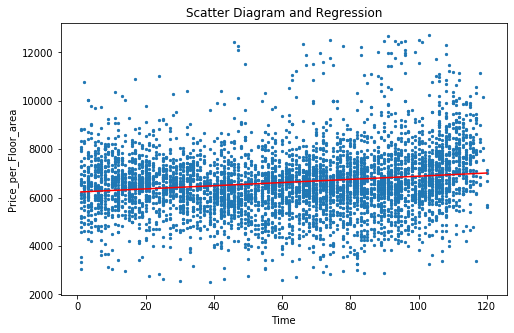

X Swoszowice


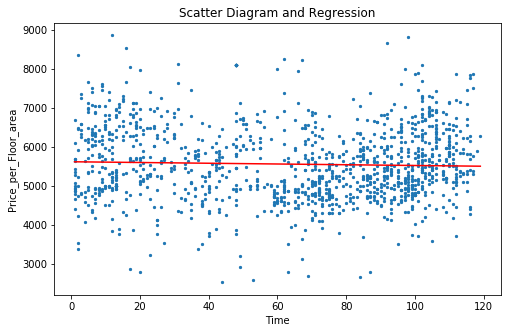

XI Podgórze Duchackie


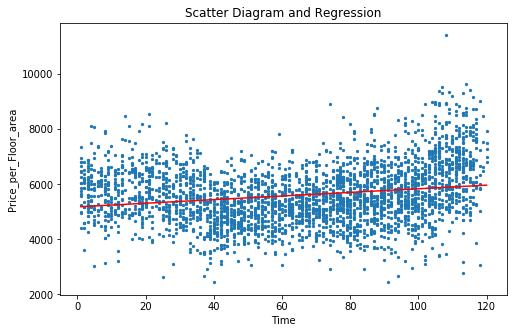

XII Bieżanów-Prokocim


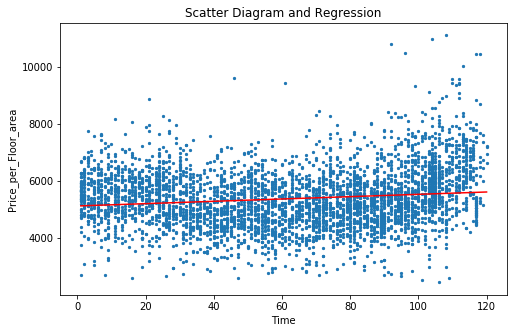

XIII Podgórze


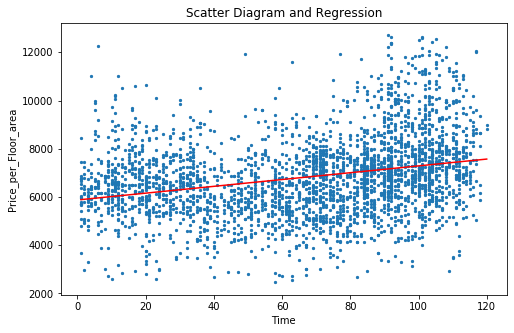

XIV Czyżyny


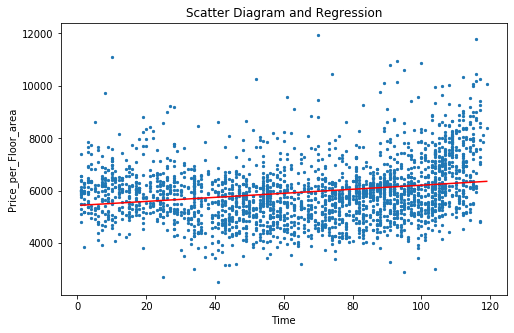

XV Mistrzejowice


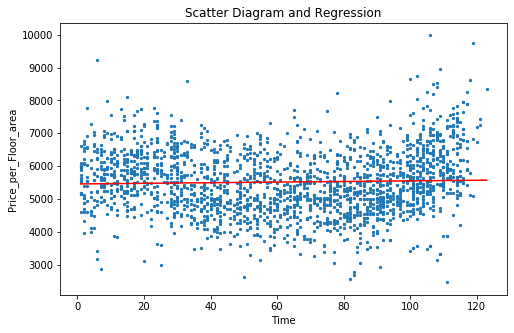

XVI Bieńczyce


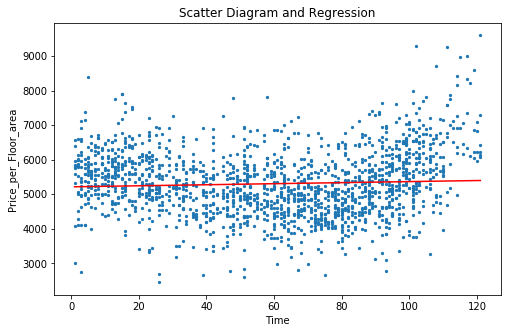

XVII Wzgórza Krzesławickie


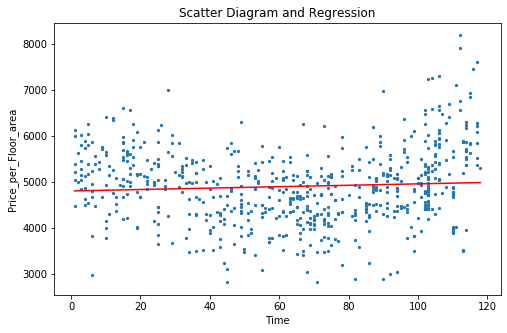

XVIII Nowa Huta


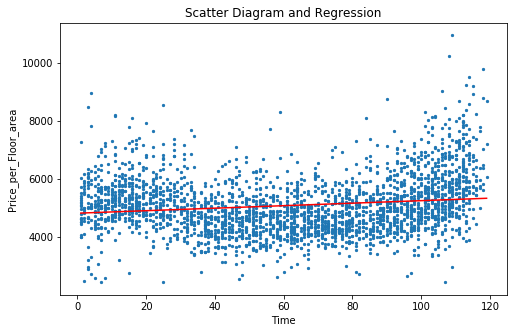

In [249]:
for group_name, df_group in df.groupby('Municipal_district'):
    print(group_name)
    scatter_regression(s_X=df_group['Time'], s_Y=df_group['Price_per_Floor_area'], same_scale=False, figsize=(8, 5), s=5)

##### Conclusion
- Simillar trend of changing prices over time was observed in most municipal districts. Only few had visually different trend, but those districts the number of transactions was small compered to other districts.
- It is not possible to use the proposed method
- the research of this method was stoped at that point

# <center>------------------ METHOD NUMBER III ---------------------------</center>

## Municipal_district as similar zones
- preprocessing:
    - updating data in all districts according to the same trend function
    - removing outliers from Price_per_Floor_area for each district individually
    - converting Municipal_district to dummy data, as Municipal_distric are classification data
- creating and training model

# INPUT

In [250]:
df = DF_PREPROCESSED.copy()

# III.3. Data Preprocessing 

#### Add Municipal_district feature

In [251]:
df_location_dict = pd.read_csv('df_municipal_district_dict.csv')

In [252]:
df_location_dict.head(1)

Admin_district  Geodesic_precinct  Location Municipal_district  \
0  Kraków - Krowodrza                  1         1       VI Bronowice   

        Old_district  
0  BRONOWICE WIELKIE

In [253]:
# create new feature
s = pd.Series(np.full(len(df), np.nan))
# Insert column before 'Location'
loc = np.nonzero(df.columns.to_numpy() == 'Location')
loc = int(loc[0][0])
df.insert(loc, 'Municipal_district', s)

# Assign correct values based on df_location_dict
for label, content in df_location_dict.iterrows():
    index = ( df['Location'] == content['Location'] )
    df.loc[index, 'Municipal_district'] = content['Municipal_district']

In [254]:
df.head(1)

Time      Admin_district  Geodesic_precinct Municipal_district  Location  \
0     1  Kraków - Krowodrza                 43   IV Prądnik Biały        31   

   Transaction_price  Floor_area  Price_per_Floor_area  \
0           180000.0        29.0                6206.9   

   Year_of_construction_class  Floor  Building_height  Standard_of_flat  \
0                           3      3                1                 2   

   Market_type  Number_of_rooms  Kitchen_separate  Extra_room  
0            0                1                 1           0

In [255]:
# Rester index to avoid error
df.reset_index(drop=True, inplace=True)

### Data Cleaning
### Smoothing data
It was decided to split Time on three periods, as ther was a different trend function in each period 

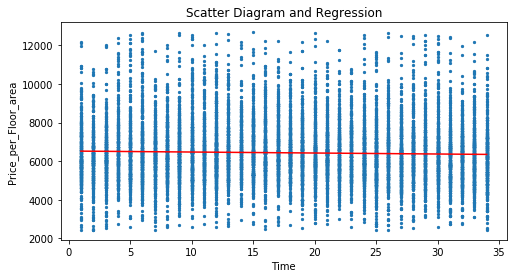

y = -5.13*x + 6524.29


C:\Users\MoioM\Anaconda3\envs\snakes\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


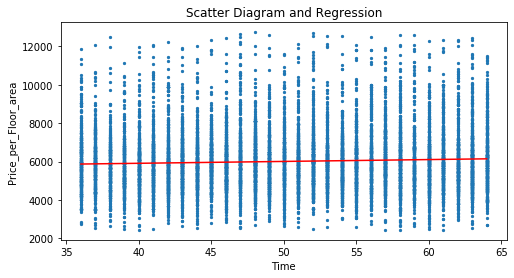

y = 9.69*x + 5520.58


C:\Users\MoioM\Anaconda3\envs\snakes\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


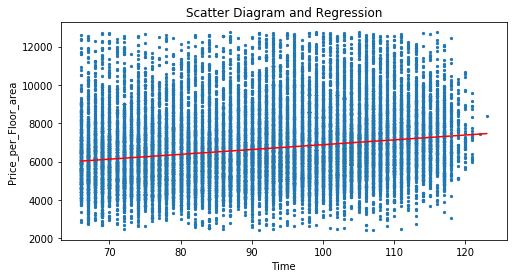

y = 25.19*x + 4360.98


In [256]:
# Smooth data by trend, split Time into three periods
periods = [(0, 35), (35, 65), (65, df['Time'].max() + 1)]
smooth_price_by_time(periods=periods)

In [257]:
df.isna().any()

Time                          False
Admin_district                False
Geodesic_precinct             False
Municipal_district            False
Location                      False
Transaction_price             False
Floor_area                    False
Price_per_Floor_area          False
Year_of_construction_class    False
Floor                         False
Building_height               False
Standard_of_flat              False
Market_type                   False
Number_of_rooms               False
Kitchen_separate              False
Extra_room                    False
dtype: bool

### Feature: Price_per_Floor_area

#### Data Cleaning: Removing outliers

It was decided:
- to deal with outliers seperately for each Municipal_district group (just removing outliers)
- to transform the final result using log function

In [258]:
col_name='Price_per_Floor_area'

IV Prądnik Biały


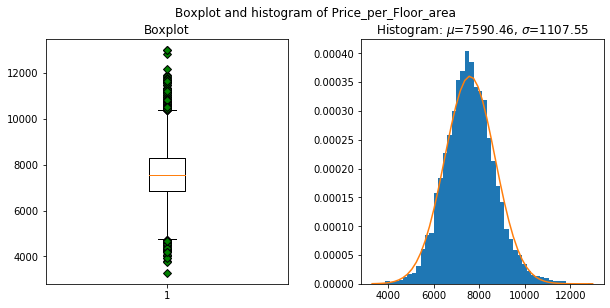

count     7669.00
mean      7590.46
std       1107.55
min       3292.41
5%        5855.06
25%       6861.48
50%       7554.79
75%       8269.70
95%       9450.88
max      12986.12
Name: Price_per_Floor_area, dtype: float64
O1: 4749.15; O3: 10382.02
III Prądnik Czerwony


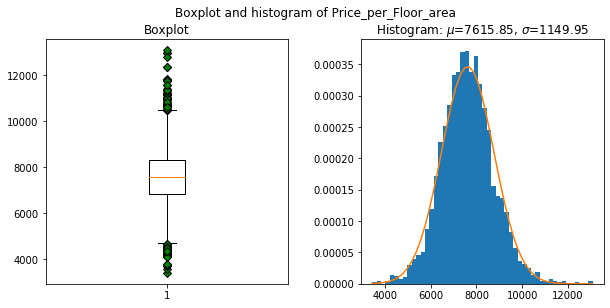

count     4214.00
mean      7615.85
std       1149.95
min       3426.02
5%        5832.48
25%       6851.03
50%       7589.73
75%       8307.33
95%       9522.13
max      13095.21
Name: Price_per_Floor_area, dtype: float64
O1: 4666.56; O3: 10491.80
XVIII Nowa Huta


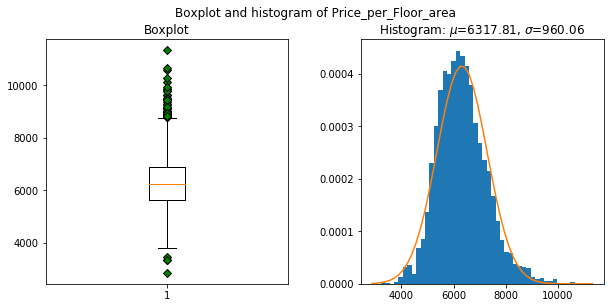

count     2825.00
mean      6317.81
std        960.06
min       2870.63
5%        4939.39
25%       5649.49
50%       6241.43
75%       6897.44
95%       7979.97
max      11322.36
Name: Price_per_Floor_area, dtype: float64
O1: 3777.56; O3: 8769.37
I Stare Miasto


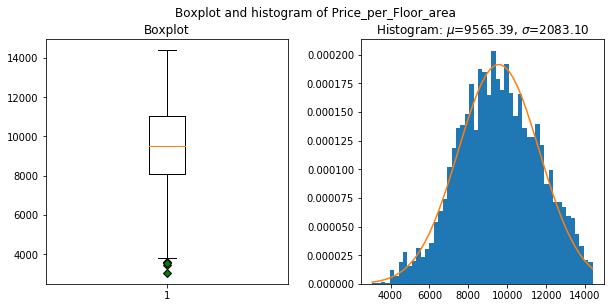

count     4467.00
mean      9565.39
std       2083.10
min       3052.99
5%        6182.82
25%       8094.37
50%       9521.97
75%      11062.99
95%      13075.40
max      14393.23
Name: Price_per_Floor_area, dtype: float64
O1: 3641.43; O3: 15515.92
VII Zwierzyniec


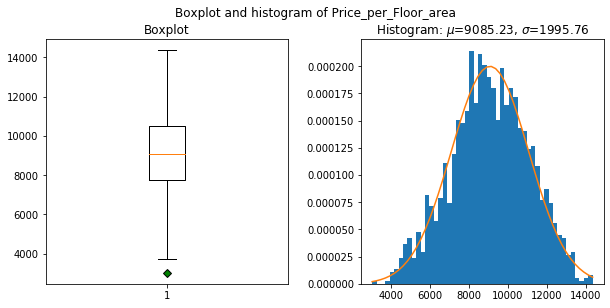

count     1669.00
mean      9085.23
std       1995.76
min       3030.37
5%        5699.64
25%       7763.20
50%       9069.98
75%      10494.98
95%      12316.87
max      14362.66
Name: Price_per_Floor_area, dtype: float64
O1: 3665.54; O3: 14592.64
XII Bieżanów-Prokocim


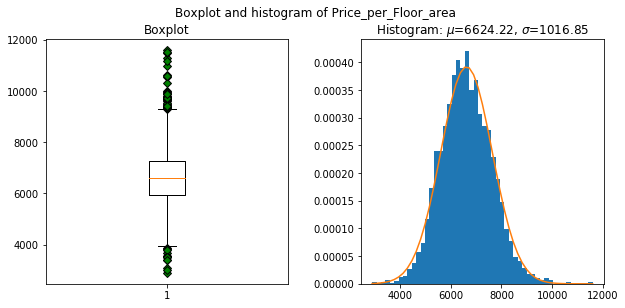

count     4356.00
mean      6624.22
std       1016.85
min       2901.71
5%        5059.26
25%       5933.65
50%       6586.33
75%       7283.86
95%       8265.29
max      11599.02
Name: Price_per_Floor_area, dtype: float64
O1: 3908.35; O3: 9309.16
X Swoszowice


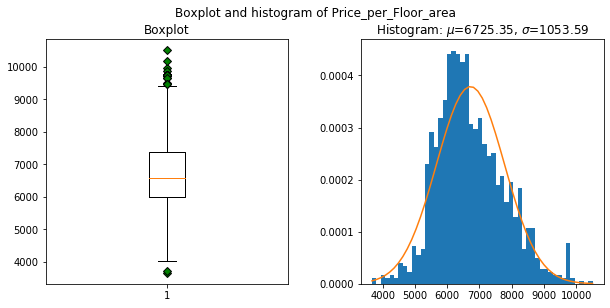

count     1308.00
mean      6725.35
std       1053.59
min       3671.71
5%        5324.49
25%       6001.38
50%       6573.04
75%       7383.07
95%       8611.31
max      10510.02
Name: Price_per_Floor_area, dtype: float64
O1: 3928.83; O3: 9455.61
V Krowodrza


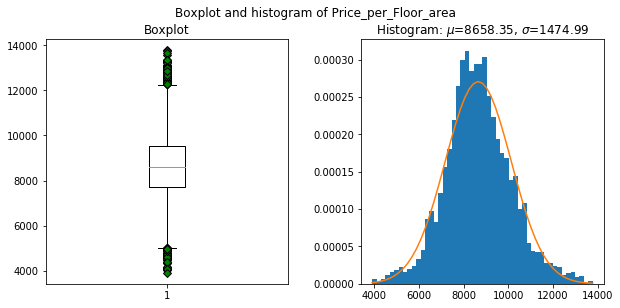

count     3986.00
mean      8658.35
std       1474.99
min       3913.38
5%        6365.68
25%       7729.16
50%       8586.96
75%       9539.95
95%      11183.95
max      13774.80
Name: Price_per_Floor_area, dtype: float64
O1: 5012.98; O3: 12256.13
XIII Podgórze


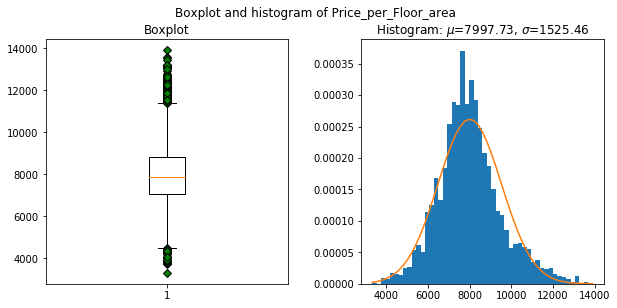

count     3288.00
mean      7997.73
std       1525.46
min       3309.35
5%        5681.01
25%       7068.03
50%       7883.56
75%       8797.78
95%      10815.32
max      13903.48
Name: Price_per_Floor_area, dtype: float64
O1: 4473.40; O3: 11392.41
XIV Czyżyny


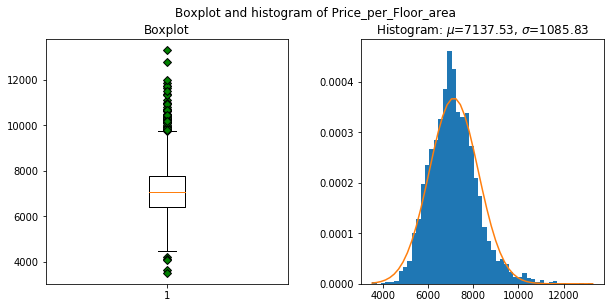

count     2600.00
mean      7137.53
std       1085.83
min       3521.71
5%        5519.61
25%       6418.01
50%       7062.78
75%       7752.60
95%       8999.21
max      13285.91
Name: Price_per_Floor_area, dtype: float64
O1: 4416.12; O3: 9754.49
IX Łagiewniki-Borek Fałęcki


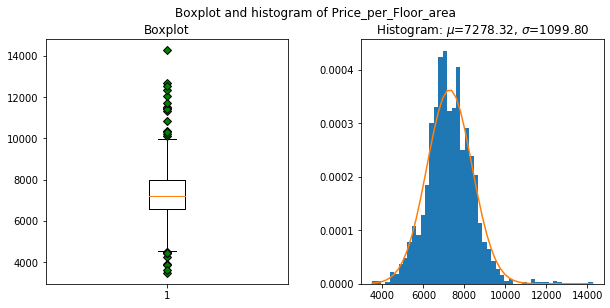

count     1729.00
mean      7278.32
std       1099.80
min       3500.66
5%        5481.57
25%       6602.37
50%       7230.63
75%       7985.69
95%       8984.67
max      14266.96
Name: Price_per_Floor_area, dtype: float64
O1: 4527.41; O3: 10060.65
XVII Wzgórza Krzesławickie


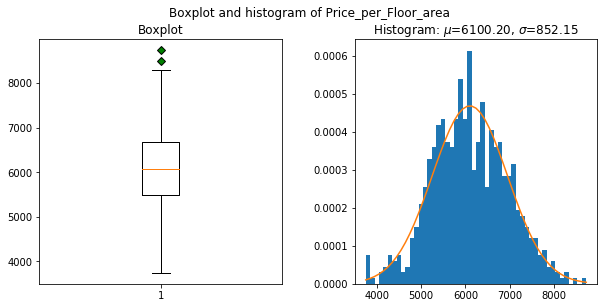

count     671.00
mean     6100.20
std       852.15
min      3747.25
5%       4785.33
25%      5494.15
50%      6064.37
75%      6687.12
95%      7513.23
max      8732.28
Name: Price_per_Floor_area, dtype: float64
O1: 3704.71; O3: 8476.56
VI Bronowice


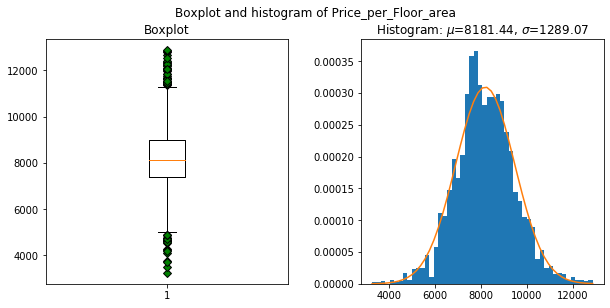

count     2442.00
mean      8181.44
std       1289.07
min       3254.05
5%        6205.69
25%       7391.34
50%       8115.62
75%       8981.27
95%      10307.31
max      12864.11
Name: Price_per_Floor_area, dtype: float64
O1: 5006.43; O3: 11366.18
XI Podgórze Duchackie


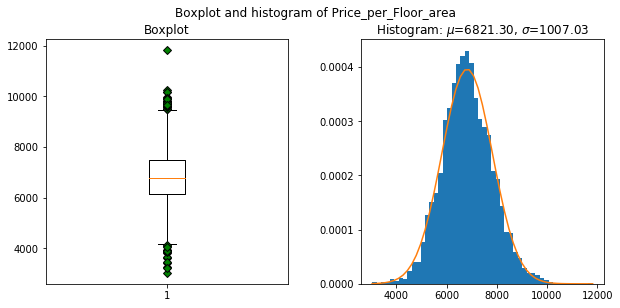

count     3222.00
mean      6821.30
std       1007.03
min       3040.59
5%        5226.96
25%       6153.12
50%       6784.56
75%       7478.93
95%       8511.42
max      11815.38
Name: Price_per_Floor_area, dtype: float64
O1: 4164.40; O3: 9467.65
XVI Bieńczyce


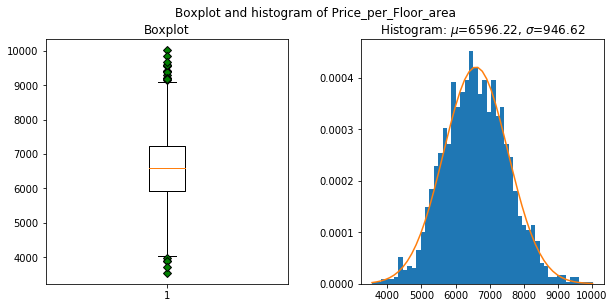

count     1757.00
mean      6596.22
std        946.62
min       3548.05
5%        5132.46
25%       5938.11
50%       6582.47
75%       7224.78
95%       8191.61
max      10020.34
Name: Price_per_Floor_area, dtype: float64
O1: 4008.10; O3: 9154.79
VIII Dębniki


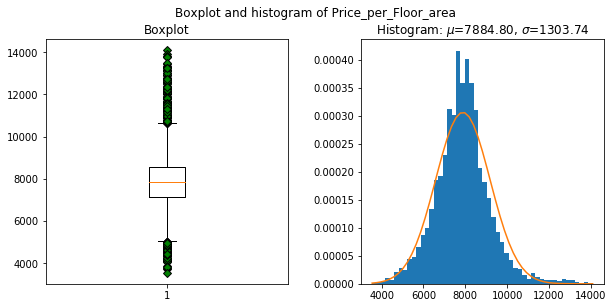

count     5130.00
mean      7884.80
std       1303.74
min       3545.06
5%        5806.74
25%       7134.24
50%       7863.72
75%       8544.53
95%       9994.38
max      14094.36
Name: Price_per_Floor_area, dtype: float64
O1: 5018.79; O3: 10659.98
II Grzegórzki


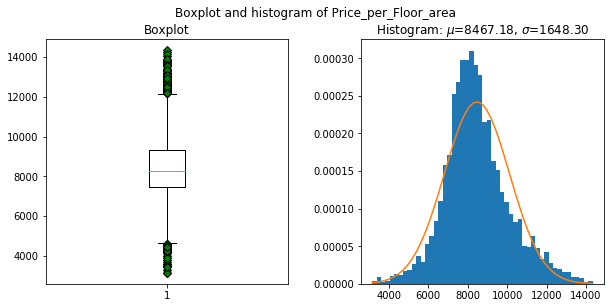

count     3607.00
mean      8467.18
std       1648.30
min       3153.50
5%        6031.02
25%       7452.22
50%       8286.93
75%       9335.54
95%      11559.24
max      14336.09
Name: Price_per_Floor_area, dtype: float64
O1: 4627.22; O3: 12160.54
XV Mistrzejowice


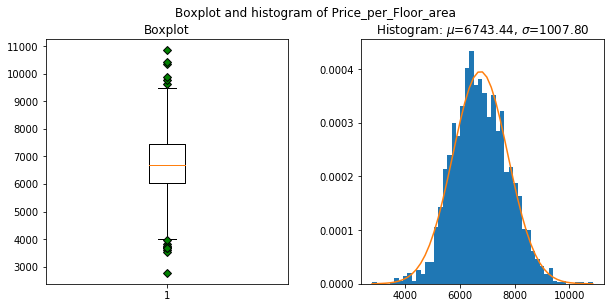

count     2115.00
mean      6743.44
std       1007.80
min       2787.71
5%        5218.46
25%       6052.80
50%       6696.82
75%       7434.22
95%       8427.25
max      10847.61
Name: Price_per_Floor_area, dtype: float64
O1: 3980.68; O3: 9506.34


In [259]:
# Remove outliers, inspect every Municipal_district separately
for value in df[('Municipal_district')].unique():
    print(value)
    
    df_group = df[[col_name]][df['Municipal_district'] == value]
    plot_boxplot_histogram(df=df_group, column_name=col_name)
    
    O1, O3 = get_O1_O3(df_group, col_name)
    print('O1: {:.2f}; O3: {:.2f}'.format(O1, O3))
    
    # Remove outliers
    labels = df_group[col_name][df_group[col_name] < O1].index
    df.drop(labels=labels, inplace=True)

    # Remove outliers
    labels = df_group[col_name][df_group[col_name] > O3].index
    df.drop(labels=labels, inplace=True)
    
    df.reset_index(drop=True, inplace=True)

In [260]:
df.reset_index(drop=True, inplace=True)

###### Visualization after removing outliers

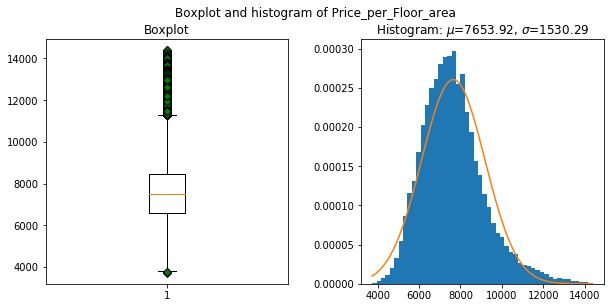

count    55894.00
mean      7653.92
std       1530.29
min       3729.67
5%        5467.28
25%       6596.18
50%       7501.96
75%       8468.79
95%      10492.58
max      14393.23
Name: Price_per_Floor_area, dtype: float64


In [261]:
plot_boxplot_histogram(df=df, column_name=col_name)

###### Transform using log function

In [262]:
df[col_name] = df[col_name].transform(np.log)

### Feature: Floor_area

#### Data Cleaning: Removing outliers

In [263]:
col_name='Floor_area'

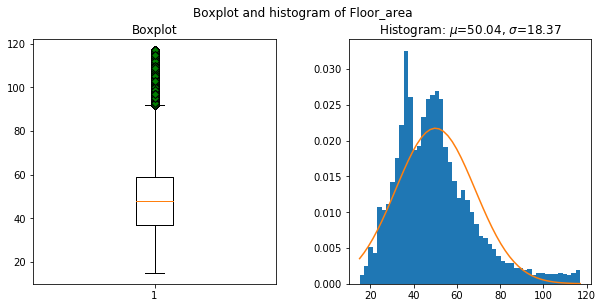

count    55894.00
mean        50.04
std         18.37
min         15.00
5%          25.30
25%         36.90
50%         47.66
75%         58.89
95%         86.17
max        117.00
Name: Floor_area, dtype: float64


In [264]:
plot_boxplot_histogram(df=df, column_name=col_name)

In [265]:
df_o1, df_o3 = get_plot_outliers_o1_o3(df=df, column_name=col_name, plot=False)

Percent of O1 outliers: 0.00%
Percent of O3 outliers: 3.80%
O3 outliers statistics:
count    2126.00
mean      104.01
std         7.63
min        91.88
50%       104.00
max       117.00
Name: Floor_area, dtype: float64


In [266]:
O1, O3 = get_O1_O3(df, col_name)
print('O1: {:.2f}; O3: {:.2f}'.format(O1, O3))

O1: 3.91; O3: 91.88


##### Conclusion:
Continuous Probability Distributions: normal distribution, right skewnes.

It was decided to transform data by using log function

##### Transform data using log function

In [267]:
df[col_name] = df[col_name].transform(np.log)

### Feature: Municipal_district

#### Data Transformation: transforming categorical variables to numeric variables
The variables Municipal_district are categorical variables. SVR can only handle numeric values and so we need to create a new variable (dummy variable) for every unique value of the categorical variables.

In [268]:
df_dummies = pd.get_dummies(df.Municipal_district , prefix='M_District_', columns='Municipal_district', drop_first=False )
df_dummies.head()

M_District__I Stare Miasto  M_District__II Grzegórzki  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   

   M_District__III Prądnik Czerwony  M_District__IV Prądnik Biały  \
0                                 0                             1   
1                                 0                             1   
2                                 1                             0   
3                                 1                             0   
4                                 1                             0   

   M_District__IX Łagiewniki-Borek Fałęcki  M_District__V Krowodrza  \
0                                        0                        0   
1                                        0                        0   
2                                        0                        0   
3                                        0                        0   
4                                        0                        0   

   M_District__VI Bronowice  M_District__VII Zwierzyniec  \
0                         0                            0   
1                         0                            0   
2                         0                            0   
3                         0                            0   
4                         0                            0   

   M_District__VIII Dębniki  M_District__X Swoszowice  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   M_District__XI Podgórze Duchackie  M_District__XII Bieżanów-Prokocim  \
0                                  0                                  0   
1                                  0                                  0   
2                                  0                                  0   
3                                  0                                  0   
4                                  0                                  0   

   M_District__XIII Podgórze  M_District__XIV Czyżyny  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        0   
4                          0                        0   

   M_District__XV Mistrzejowice  M_District__XVI Bieńczyce  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   

   M_District__XVII Wzgórza Krzesławickie  M_District__XVIII Nowa Huta  
0                                       0                            0  
1                                       0                            0  
2                                       0                            0  
3                                       0                            0  
4                                       0                            0

In [269]:
df = pd.concat( [df, df_dummies] , axis=1 )

In [270]:
df.head(1)

Time      Admin_district  Geodesic_precinct Municipal_district  Location  \
0   124  Kraków - Krowodrza                 43   IV Prądnik Biały        31   

   Transaction_price  Floor_area  Price_per_Floor_area  \
0           180000.0    3.367296              8.963132   

   Year_of_construction_class  Floor  ...  M_District__VIII Dębniki  \
0                           3      3  ...                         0   

   M_District__X Swoszowice  M_District__XI Podgórze Duchackie  \
0                         0                                  0   

   M_District__XII Bieżanów-Prokocim  M_District__XIII Podgórze  \
0                                  0                          0   

   M_District__XIV Czyżyny  M_District__XV Mistrzejowice  \
0                        0                             0   

   M_District__XVI Bieńczyce  M_District__XVII Wzgórza Krzesławickie  \
0                          0                                       0   

   M_District__XVIII Nowa Huta  
0                            0  

[1 rows x 34 columns]

In [271]:
df.columns

Index(['Time', 'Admin_district', 'Geodesic_precinct', 'Municipal_district',
       'Location', 'Transaction_price', 'Floor_area', 'Price_per_Floor_area',
       'Year_of_construction_class', 'Floor', 'Building_height',
       'Standard_of_flat', 'Market_type', 'Number_of_rooms',
       'Kitchen_separate', 'Extra_room', 'M_District__I Stare Miasto',
       'M_District__II Grzegórzki', 'M_District__III Prądnik Czerwony',
       'M_District__IV Prądnik Biały',
       'M_District__IX Łagiewniki-Borek Fałęcki', 'M_District__V Krowodrza',
       'M_District__VI Bronowice', 'M_District__VII Zwierzyniec',
       'M_District__VIII Dębniki', 'M_District__X Swoszowice',
       'M_District__XI Podgórze Duchackie',
       'M_District__XII Bieżanów-Prokocim', 'M_District__XIII Podgórze',
       'M_District__XIV Czyżyny', 'M_District__XV Mistrzejowice',
       'M_District__XVI Bieńczyce', 'M_District__XVII Wzgórza Krzesławickie',
       'M_District__XVIII Nowa Huta'],
      dtype='object')

In [272]:
# Use only M_District_.... as a spatial/location feature
df.drop(columns=['Time', 'Admin_district', 'Geodesic_precinct', 'Municipal_district', 'Location', 'Transaction_price'], inplace=True)

# OUTPUT
## DF_OUTPUT_III3
- Price_per_Floor_area is:
    - smoothed by trend
    - outliers are removed
    - transformed by log function to remove right skewnes
- Floor_are is:
    - transformed by log function to remove right skewnes
- Features are selected

In [273]:
DF_OUTPUT_III3 = df.copy()

# 4. Data Modeling

# Model number III.A
## SVR

In [274]:
df = DF_OUTPUT_III3.copy()

### Splitting data into input and output (data and target)

In [275]:
X_df = df.drop(columns=['Price_per_Floor_area'], inplace=False) # input; deep copy of columns 
Y_df = df[['Price_per_Floor_area']] # output

### Data Transformation: Rescale Data
### Normalize data 
Data were rescaled using normalization, MinMax techniqe. It means that the data were rescaled to lie between 0 and 1. It brings all the values of numeric columns in the dataset to a common scale.

In [276]:
# get a set of values from original dataset
X = X_df.values

# normalized data
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [277]:
# Cache input and output data as dataframe
X_df = pd.DataFrame.from_records(X, columns=X_df.columns) # Create dataframe of from normalized data

# Test: display first instance
X_df.head(1)

Floor_area  Year_of_construction_class  Floor  Building_height  \
0    0.320938                         0.5  0.375              1.0   

   Standard_of_flat  Market_type  Number_of_rooms  Kitchen_separate  \
0               0.5          0.0              0.0               1.0   

   Extra_room  M_District__I Stare Miasto  ...  M_District__VIII Dębniki  \
0         0.0                         0.0  ...                       0.0   

   M_District__X Swoszowice  M_District__XI Podgórze Duchackie  \
0                       0.0                                0.0   

   M_District__XII Bieżanów-Prokocim  M_District__XIII Podgórze  \
0                                0.0                        0.0   

   M_District__XIV Czyżyny  M_District__XV Mistrzejowice  \
0                      0.0                           0.0   

   M_District__XVI Bieńczyce  M_District__XVII Wzgórza Krzesławickie  \
0                        0.0                                     0.0   

   M_District__XVIII Nowa Huta  
0                          0.0  

[1 rows x 27 columns]

#### Statistical description of normalized data
Data were normalized using MinMax technique.
- expected: min = 0, max = 0
- mean do not need to be 0 and standad deviation do not need to be 1

In [278]:
df_desc=X_df.describe()
df_desc.loc[['min', 'max', 'mean', 'std']]

Floor_area  Year_of_construction_class     Floor  Building_height  \
min     0.000000                    0.000000  0.000000         0.000000   
max     1.000000                    1.000000  1.000000         1.000000   
mean    0.555427                    0.361832  0.329047         0.499750   
std     0.174547                    0.312785  0.243072         0.500004   

      Standard_of_flat  Market_type  Number_of_rooms  Kitchen_separate  \
min           0.000000     0.000000         0.000000          0.000000   
max           1.000000     1.000000         1.000000          1.000000   
mean          0.623269     0.362472         0.374894          0.557734   
std           0.369926     0.480718         0.283906          0.496660   

      Extra_room  M_District__I Stare Miasto  ...  M_District__VIII Dębniki  \
min     0.000000                    0.000000  ...                  0.000000   
max     1.000000                    1.000000  ...                  1.000000   
mean    0.000215                    0.079848  ...                  0.087827   
std     0.014651                    0.271059  ...                  0.283046   

      M_District__X Swoszowice  M_District__XI Podgórze Duchackie  \
min                   0.000000                           0.000000   
max                   1.000000                           1.000000   
mean                  0.022954                           0.056876   
std                   0.149759                           0.231607   

      M_District__XII Bieżanów-Prokocim  M_District__XIII Podgórze  \
min                            0.000000                   0.000000   
max                            1.000000                   1.000000   
mean                           0.077003                   0.056625   
std                            0.266598                   0.231127   

      M_District__XIV Czyżyny  M_District__XV Mistrzejowice  \
min                  0.000000                      0.000000   
max                  1.000000                      1.000000   
mean                 0.045461                      0.037571   
std                  0.208315                      0.190158   

      M_District__XVI Bieńczyce  M_District__XVII Wzgórza Krzesławickie  \
min                    0.000000                                0.000000   
max                    1.000000                                1.000000   
mean                   0.031095                                0.011969   
std                    0.173575                                0.108748   

      M_District__XVIII Nowa Huta  
min                      0.000000  
max                      1.000000  
mean                     0.049648  
std                      0.217218  

[4 rows x 27 columns]

#### Data Reduction: Feature selection: PCA
PCA technique (Principal Component Analysis)
- automatically select the features that contribut best to prediction
- allows to reduce dimentionality

It is necessary to normalize data before performing PCA (data are already normalized)

In [279]:
#X = X_df.values

In [280]:
#pca = PCA(n_components=6)
#pca.fit(X) # Fit the model with X

In [281]:
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

# summarize components
#print("Explained Variance: %s" % pca.explained_variance_ratio_)
#print(pca.components_)

In [282]:
#X = pca.transform(X) # Apply dimensionality reduction to X

In [283]:
# Cache output data after this stage
#X_df = pd.DataFrame.from_records(X)
#Y_df = Y_df

### Model: Regression: SVR(kernel='linear')

### Document Choice:
- there is more than 50 instances
- data taget is not categorical
- data target describes quantity (number)
- there is less than 100k instances
- all feature should be important
- use SVR(kernel='linear')

In [284]:
# Input Data
X = X_df.values
y = Y_df.values.flatten()

In [285]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Train data 

In [286]:
# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py
regressor = SVR(kernel='linear', C=1, gamma='auto')

model = regressor.fit(X_train, y_train)

#### Evaluate model

In [287]:
y_predicted = model.predict(X_test)

In [288]:
# transform from log
y_test = np.exp(y_test)
y_predicted = np.exp(y_predicted)

In [289]:
# value of Y_predict
y_predicted[0]

6296.424164398236

In [290]:
# actual value
y_test[0]

7603.731546658432

In [291]:
s_predicted = pd.Series(y_predicted, name='Predicted output')
s_target = pd.Series(y_test, name='Target output')

In [292]:
# plot scatter diagram to visualize how well data were predicted
scatter_regression(s_X=s_predicted, s_Y=s_target, same_scale=True)

In [293]:
# Calculate Pearson Correlation Coeficient, the closer to 1 the better
r_pearson_coef, p = pearsonr(y_predicted, y_test)
print('Pearson Correlation Coeficient: {:.2f}, P-value: {}'.format(r_pearson_coef, p))

Pearson Correlation Coeficient: 0.64, P-value: 0.0


In [294]:
s_predicted.describe()

count    16769.000000
mean      7597.012773
std       1002.700047
min       5370.849294
25%       6821.678651
50%       7503.726930
75%       8180.918015
max      11924.707722
Name: Predicted output, dtype: float64

In [295]:
s_target.describe()

count    16769.000000
mean      7648.050887
std       1513.504338
min       3729.665534
25%       6605.578665
50%       7498.524043
75%       8450.220514
max      14391.228657
Name: Target output, dtype: float64

### Conclusion
- positive correlation coefficient
- The Pearson's correlation coefficient droped. Probably data had too many outliers before PCA
- It took short long to train data
- There are many outliers. It should be corrected.

# Model number III.B
## DecisionTree

In [296]:
df = DF_OUTPUT_III3.copy()

#### Split data into input and output (data and target)

In [297]:
X_df = df.drop(columns=['Price_per_Floor_area'], inplace=False) # input; deep copy of columns 
y_df = df[['Price_per_Floor_area']] # output

In [298]:
# Input Data
X = X_df.values
y = y_df.values.flatten()

In [299]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Train data 

In [300]:
regressor = DecisionTreeRegressor()
model = regressor.fit(X_train, y_train)

#### Evaluate model

In [301]:
y_predicted = model.predict(X_test)

In [302]:
# transform from log
y_test = np.exp(y_test)
y_predicted = np.exp(y_predicted)

In [303]:
# value of Y_predict
y_predicted[0]

6060.740642470631

In [304]:
# actual value
y_test[0]

5591.452272871044

In [305]:
s_predicted = pd.Series(y_predicted, name='Predicted output')
s_target = pd.Series(y_test, name='Target output')

In [306]:
# plot scatter diagram to visualize how well data were predicted
scatter_regression(s_X=s_predicted, s_Y=s_target, same_scale=True)

In [307]:
# Calculate Pearson Correlation Coeficient, the closer to 1 the better
r_pearson_coef, p = pearsonr(y_predicted, y_test)
print('Pearson Correlation Coeficient: {:.2f}, P-value: {}'.format(r_pearson_coef, p))

Pearson Correlation Coeficient: 0.54, P-value: 0.0


In [308]:
s_predicted.describe()

count    16769.000000
mean      7649.644422
std       1547.944076
min       3773.278370
25%       6576.650712
50%       7488.390192
75%       8480.182326
max      14362.656626
Name: Predicted output, dtype: float64

In [309]:
s_target.describe()

count    16769.000000
mean      7656.537261
std       1545.594604
min       3729.665534
25%       6572.443903
50%       7503.911744
75%       8471.467974
max      14307.150964
Name: Target output, dtype: float64

### Conclusion
- positive correlation coefficient
- The Pearson's correlation coefficient droped. Probably data had too many outliers before PCA
- It took short long to train data
- There are many outliers. It should be corrected.

# <center>------------------ METHOD NUMBER IV ---------------------------</center>

## Use Old_district  as similar zones
- preprocessing:
    - updating data in all districts according to the same trend function
    - removing outliers from Price_per_Floor_area for each district individually
    - converting Old_district to dummy data, as Municipal_distric are classification data
- creating and training model

# INPUT

In [310]:
df = DF_PREPROCESSED.copy()

# IV.3. Data Preprocessing 

#### Add Old_district feature

In [311]:
df_location_dict = pd.read_csv('df_municipal_district_dict.csv')

In [312]:
df_location_dict.head(1)

Admin_district  Geodesic_precinct  Location Municipal_district  \
0  Kraków - Krowodrza                  1         1       VI Bronowice   

        Old_district  
0  BRONOWICE WIELKIE

In [313]:
# create new feature
s = pd.Series(np.full(len(df), np.nan))
# Insert column before 'Location'
loc = np.nonzero(df.columns.to_numpy() == 'Location')
loc = int(loc[0][0])
df.insert(loc, 'Old_district', s)

# Assign correct values based on df_location_dict
for label, content in df_location_dict.iterrows():
    index = ( df['Location'] == content['Location'] )
    df.loc[index, 'Old_district'] = content['Old_district']

In [314]:
df.head(1)

Time      Admin_district  Geodesic_precinct   Old_district  Location  \
0     1  Kraków - Krowodrza                 43  PRĄDNIK BIAŁY        31   

   Transaction_price  Floor_area  Price_per_Floor_area  \
0           180000.0        29.0                6206.9   

   Year_of_construction_class  Floor  Building_height  Standard_of_flat  \
0                           3      3                1                 2   

   Market_type  Number_of_rooms  Kitchen_separate  Extra_room  
0            0                1                 1           0

In [315]:
# Rester index to avoid error
df.reset_index(drop=True, inplace=True)

### Data Cleaning
### Smoothing data
It was decided to split Time on three periods, as ther was a different trend function in each period 

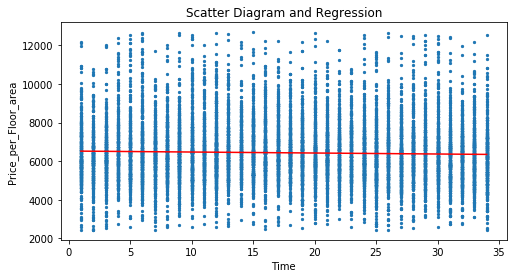

y = -5.13*x + 6524.29


C:\Users\MoioM\Anaconda3\envs\snakes\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


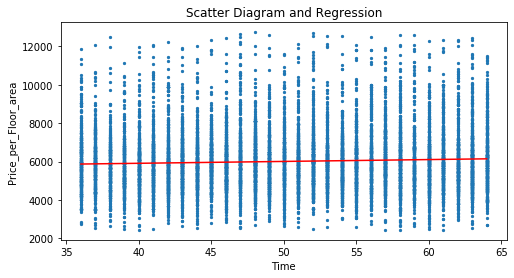

y = 9.69*x + 5520.58


C:\Users\MoioM\Anaconda3\envs\snakes\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


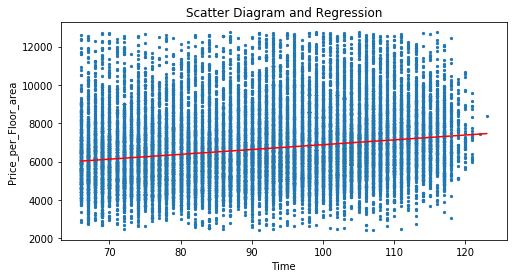

y = 25.19*x + 4360.98


In [316]:
# Smooth data by trend, split Time into three periods
periods = [(0, 35), (35, 65), (65, df['Time'].max() + 1)]
smooth_price_by_time(periods=periods)

In [317]:
df.isna().any()

Time                          False
Admin_district                False
Geodesic_precinct             False
Old_district                  False
Location                      False
Transaction_price             False
Floor_area                    False
Price_per_Floor_area          False
Year_of_construction_class    False
Floor                         False
Building_height               False
Standard_of_flat              False
Market_type                   False
Number_of_rooms               False
Kitchen_separate              False
Extra_room                    False
dtype: bool

### Feature: Price_per_Floor_area

#### Data Cleaning: Removing outliers

It was decided:
- to deal with outliers seperately for each Old)district group (just removing outliers)
- to transform the final result using log function

In [318]:
col_name='Price_per_Floor_area'

PRĄDNIK BIAŁY


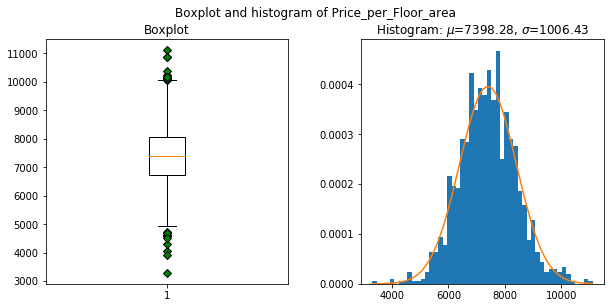

count     1300.00
mean      7398.28
std       1006.43
min       3292.41
5%        5814.93
25%       6743.91
50%       7384.90
75%       8071.27
95%       9020.68
max      11112.47
Name: Price_per_Floor_area, dtype: float64
O1: 4752.87; O3: 10062.30
OLSZA


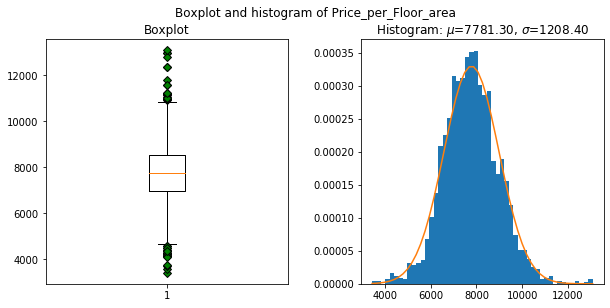

count     2298.00
mean      7781.30
std       1208.40
min       3426.02
5%        5959.48
25%       6977.48
50%       7745.52
75%       8531.73
95%       9736.43
max      13095.21
Name: Price_per_Floor_area, dtype: float64
O1: 4646.11; O3: 10863.10
PRĄDNIK CZERWONY


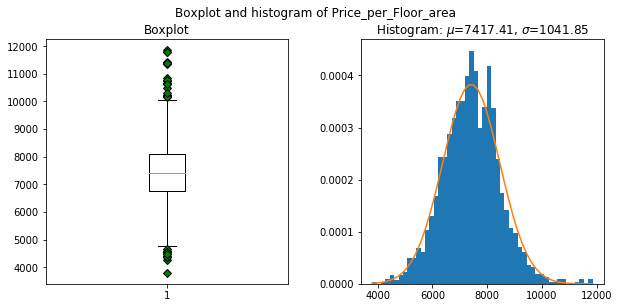

count     1916.00
mean      7417.41
std       1041.85
min       3799.26
5%        5735.47
25%       6740.44
50%       7411.73
75%       8082.47
95%       9078.54
max      11852.23
Name: Price_per_Floor_area, dtype: float64
O1: 4727.40; O3: 10095.51
STARA HUTA


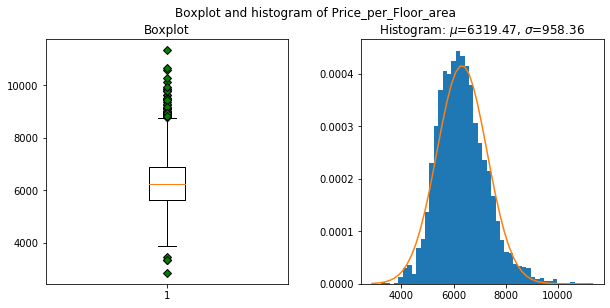

count     2823.00
mean      6319.47
std        958.36
min       2870.63
5%        4941.68
25%       5649.93
50%       6241.55
75%       6897.88
95%       7980.06
max      11322.36
Name: Price_per_Floor_area, dtype: float64
O1: 3778.00; O3: 8769.81
KAZIMIERZ


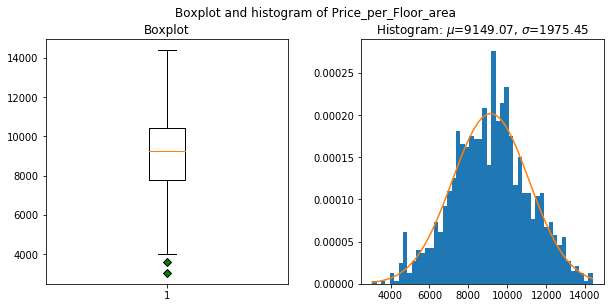

count     1436.00
mean      9149.07
std       1975.45
min       3052.99
5%        5761.21
25%       7772.35
50%       9247.51
75%      10448.03
95%      12449.43
max      14393.23
Name: Price_per_Floor_area, dtype: float64
O1: 3758.84; O3: 14461.55
OLSZANICA


count      176.00
mean      7291.16
std       1582.76
min       3030.37
5%        4905.73
25%       6253.59
50%       7210.65
75%       8205.72
95%       9899.70
max      13719.89
Name: Price_per_Floor_area, dtype: float64
O1: 3325.40; O3: 11133.92
BIEŻANÓW


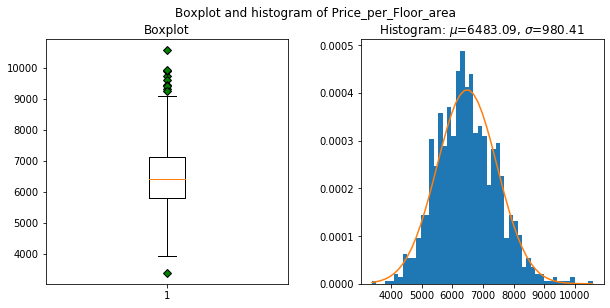

count     1011.00
mean      6483.09
std        980.41
min       3384.35
5%        4994.62
25%       5786.81
50%       6423.27
75%       7113.76
95%       8107.65
max      10573.94
Name: Price_per_Floor_area, dtype: float64
O1: 3796.39; O3: 9104.18
BOREK FAŁĘCKI


count     1794.00
mean      7079.55
std       1080.83
min       3500.66
5%        5445.64
25%       6392.71
50%       7009.05
75%       7731.81
95%       8754.75
max      14266.96
Name: Price_per_Floor_area, dtype: float64
O1: 4384.05; O3: 9740.47
KROWODRZA GORKA


count     1496.00
mean      7166.04
std        939.03
min       4180.94
5%        5667.81
25%       6523.76
50%       7175.98
75%       7784.16
95%       8596.78
max      12844.72
Name: Price_per_Floor_area, dtype: float64
O1: 4633.17; O3: 9674.75
ŁOBZÓW


count     3923.00
mean      8646.15
std       1468.29
min       3913.38
5%        6368.68
25%       7723.38
50%       8569.12
75%       9517.07
95%      11164.13
max      13774.80
Name: Price_per_Floor_area, dtype: float64
O1: 5032.83; O3: 12207.62
STARE PODGÓRZE


count     1595.00
mean      8599.83
std       1683.89
min       3742.72
5%        5890.63
25%       7582.63
50%       8524.93
75%       9616.58
95%      11551.28
max      13903.48
Name: Price_per_Floor_area, dtype: float64
O1: 4531.70; O3: 12667.51
STARE CZYŻYNY


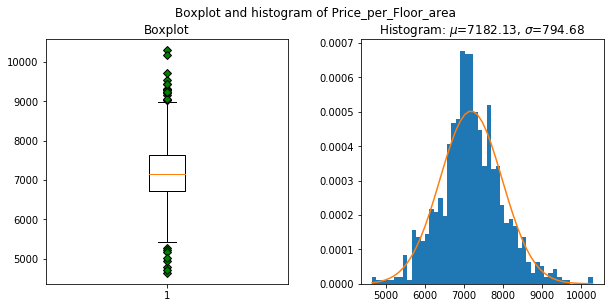

count      850.00
mean      7182.13
std        794.68
min       4645.71
5%        5853.35
25%       6721.76
50%       7140.98
75%       7645.37
95%       8532.70
max      10293.34
Name: Price_per_Floor_area, dtype: float64
O1: 5336.34; O3: 9030.79
KROWODRZA


count     4110.00
mean      7845.09
std       1161.62
min       3254.05
5%        6034.72
25%       7098.06
50%       7798.68
75%       8589.40
95%       9759.10
max      12986.12
Name: Price_per_Floor_area, dtype: float64
O1: 4861.05; O3: 10826.41
TONIE


count     1008.00
mean      7593.04
std        997.26
min       3785.72
5%        5921.95
25%       6990.29
50%       7630.18
75%       8262.80
95%       9114.47
max      11561.47
Name: Price_per_Floor_area, dtype: float64
O1: 5081.51; O3: 10171.58
ŁAGIEWNIKI


count     1131.00
mean      7602.93
std       1085.67
min       3646.14
5%        5671.95
25%       6927.51
50%       7693.58
75%       8294.51
95%       9243.18
max      12523.13
Name: Price_per_Floor_area, dtype: float64
O1: 4877.01; O3: 10345.01
WZGORZA KRZESLAWICKIE


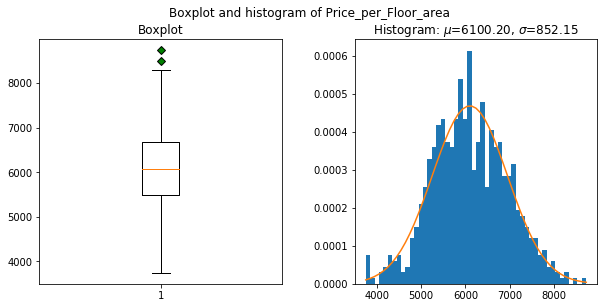

count     671.00
mean     6100.20
std       852.15
min      3747.25
5%       4785.33
25%      5494.15
50%      6064.37
75%      6687.12
95%      7513.23
max      8732.28
Name: Price_per_Floor_area, dtype: float64
O1: 3704.71; O3: 8476.56
CZYZYNY


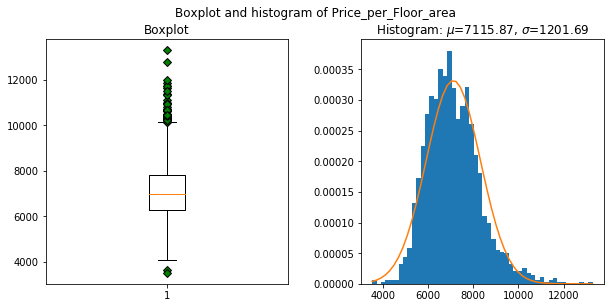

count     1750.00
mean      7115.87
std       1201.69
min       3521.71
5%        5454.63
25%       6261.74
50%       6979.07
75%       7813.71
95%       9273.59
max      13285.91
Name: Price_per_Floor_area, dtype: float64
O1: 3933.78; O3: 10141.66
PIERWSZA OBWODNICA


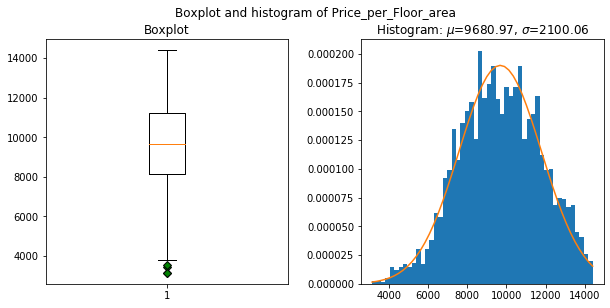

count     3382.00
mean      9680.97
std       2100.06
min       3153.50
5%        6342.81
25%       8156.97
50%       9657.77
75%      11234.73
95%      13167.54
max      14391.23
Name: Price_per_Floor_area, dtype: float64
O1: 3540.33; O3: 15851.38
BRONOWICE WIELKIE


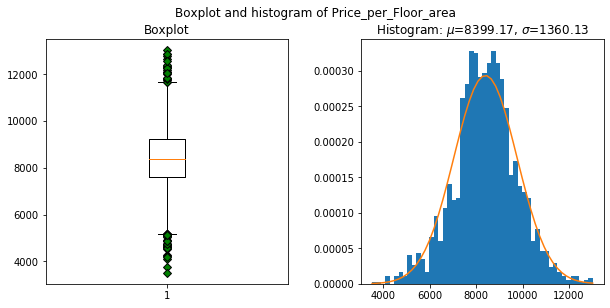

count     1830.00
mean      8399.17
std       1360.13
min       3520.76
5%        6110.53
25%       7603.10
50%       8391.74
75%       9223.08
95%      10642.73
max      13017.07
Name: Price_per_Floor_area, dtype: float64
O1: 5173.14; O3: 11653.04
WOLA DUCHACKA


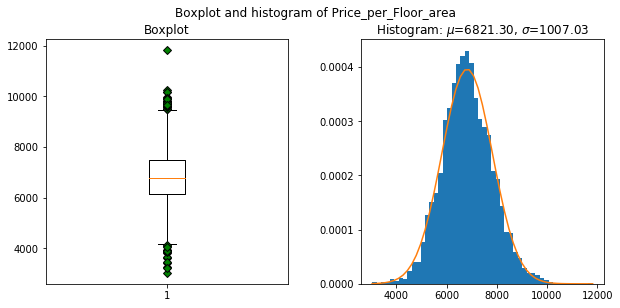

count     3222.00
mean      6821.30
std       1007.03
min       3040.59
5%        5226.96
25%       6153.12
50%       6784.56
75%       7478.93
95%       8511.42
max      11815.38
Name: Price_per_Floor_area, dtype: float64
O1: 4164.40; O3: 9467.65
BIENCZYCE


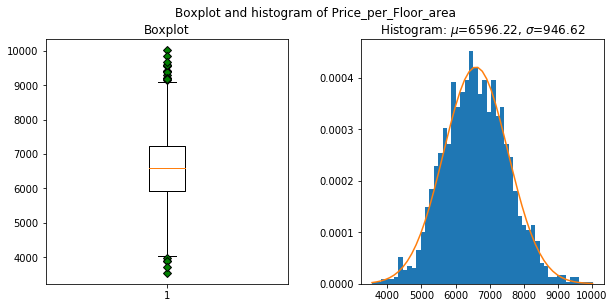

count     1757.00
mean      6596.22
std        946.62
min       3548.05
5%        5132.46
25%       5938.11
50%       6582.47
75%       7224.78
95%       8191.61
max      10020.34
Name: Price_per_Floor_area, dtype: float64
O1: 4008.10; O3: 9154.79
PŁASZÓW


count     1207.00
mean      7294.83
std       1025.48
min       3309.35
5%        5617.59
25%       6626.64
50%       7333.60
75%       7939.44
95%       8925.97
max      12247.93
Name: Price_per_Floor_area, dtype: float64
O1: 4657.45; O3: 9908.63
RUCZAJ


count     3574.00
mean      7688.19
std       1037.13
min       3545.06
5%        5898.84
25%       7069.08
50%       7733.69
75%       8333.68
95%       9316.39
max      11888.42
Name: Price_per_Floor_area, dtype: float64
O1: 5172.19; O3: 10230.57
PROKOCIM


count     2915.00
mean      6754.28
std       1017.19
min       2901.71
5%        5209.10
25%       6082.05
50%       6725.19
75%       7422.00
95%       8371.46
max      11599.02
Name: Price_per_Floor_area, dtype: float64
O1: 4072.13; O3: 9431.92
SWOSZOWICE


count     500.00
mean     6309.16
std       979.36
min      3671.71
5%       4983.57
25%      5681.42
50%      6185.33
75%      6667.74
95%      7954.46
max      9870.89
Name: Price_per_Floor_area, dtype: float64
O1: 4201.94; O3: 8147.22
GRZEGÓRZKI


count     3158.00
mean      8314.41
std       1493.19
min       3311.30
5%        6028.78
25%       7423.12
50%       8204.05
75%       9102.36
95%      11080.08
max      14242.45
Name: Price_per_Floor_area, dtype: float64
O1: 4904.25; O3: 11621.22
DĘBNIKI


count     1428.00
mean      8553.22
std       1564.43
min       3885.48
5%        6192.81
25%       7621.49
50%       8382.68
75%       9372.24
95%      11555.39
max      14094.36
Name: Price_per_Floor_area, dtype: float64
O1: 4995.38; O3: 11998.36
WOLA JUSTOWSKA


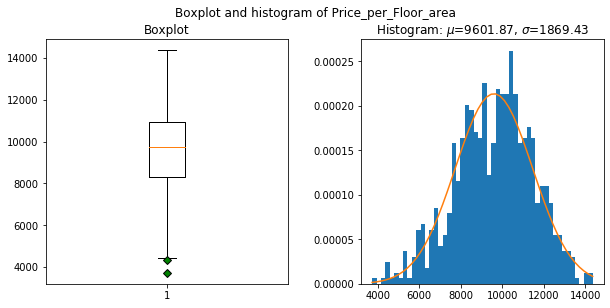

count      773.00
mean      9601.87
std       1869.43
min       3729.67
5%        6173.23
25%       8325.95
50%       9745.17
75%      10928.43
95%      12471.31
max      14362.66
Name: Price_per_Floor_area, dtype: float64
O1: 4422.22; O3: 14832.15
SALWATOR


count      734.00
mean      8962.34
std       1949.73
min       3960.11
5%        5479.89
25%       7772.43
50%       8920.48
75%      10255.51
95%      12268.06
max      14154.41
Name: Price_per_Floor_area, dtype: float64
O1: 4047.80; O3: 13980.14
MISTRZEJOWICE


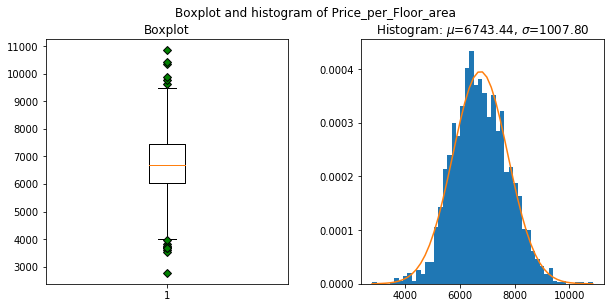

count     2115.00
mean      6743.44
std       1007.80
min       2787.71
5%        5218.46
25%       6052.80
50%       6696.82
75%       7434.22
95%       8427.25
max      10847.61
Name: Price_per_Floor_area, dtype: float64
O1: 3980.68; O3: 9506.34
STARY PROKOCIM


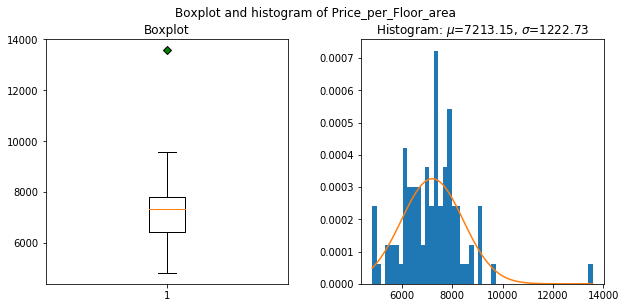

count       95.00
mean      7213.15
std       1222.73
min       4828.09
5%        5321.65
25%       6425.90
50%       7322.18
75%       7809.09
95%       9040.28
max      13571.01
Name: Price_per_Floor_area, dtype: float64
O1: 4351.12; O3: 9883.88
MYDLNIKI


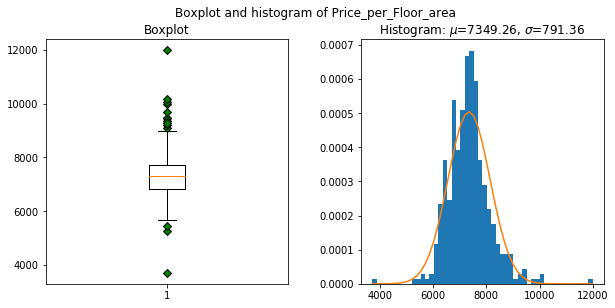

count      416.00
mean      7349.26
std        791.36
min       3713.95
5%        6253.42
25%       6837.78
50%       7311.03
75%       7704.10
95%       8725.61
max      11988.77
Name: Price_per_Floor_area, dtype: float64
O1: 5538.30; O3: 9003.57
STARE MIASTO


count       98.00
mean     11568.81
std       1892.55
min       4999.69
5%        7576.85
25%      10712.31
50%      11944.78
75%      12900.81
95%      13693.69
max      14274.52
Name: Price_per_Floor_area, dtype: float64
O1: 7429.57; O3: 16183.56
RYBITWY


count     433.00
mean     6070.24
std       862.11
min      3513.57
5%       4813.68
25%      5434.88
50%      6002.60
75%      6643.45
95%      7484.79
max      9787.78
Name: Price_per_Floor_area, dtype: float64
O1: 3622.03; O3: 8456.30
PYCHOWICE


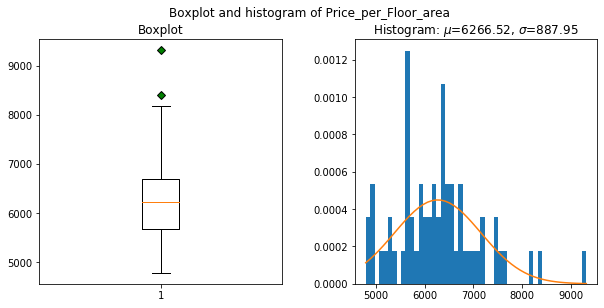

count      62.00
mean     6266.52
std       887.95
min      4790.19
5%       4906.29
25%      5677.98
50%      6232.82
75%      6695.60
95%      7675.76
max      9314.13
Name: Price_per_Floor_area, dtype: float64
O1: 4151.54; O3: 8222.03
OPATKOWICE


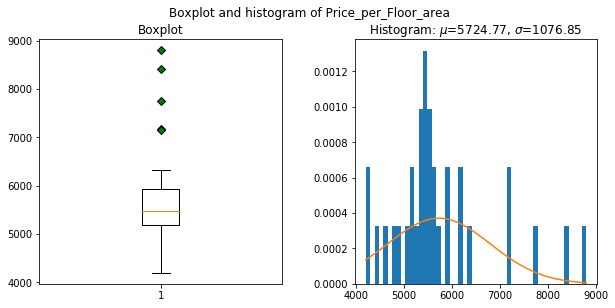

count      33.00
mean     5724.77
std      1076.85
min      4195.77
5%       4352.99
25%      5175.71
50%      5478.51
75%      5936.49
95%      8020.03
max      8802.71
Name: Price_per_Floor_area, dtype: float64
O1: 4034.53; O3: 7077.67
TYNIEC


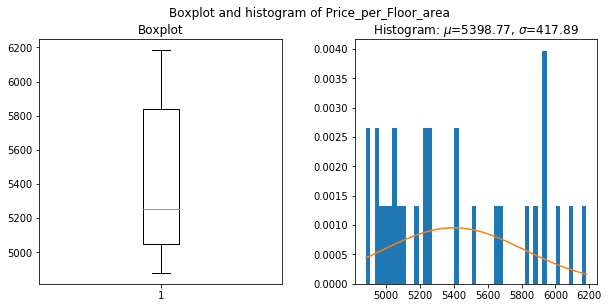

count      29.00
mean     5398.77
std       417.89
min      4879.54
5%       4910.56
25%      5048.03
50%      5251.94
75%      5839.89
95%      6054.76
max      6183.39
Name: Price_per_Floor_area, dtype: float64
O1: 3860.25; O3: 7027.68
PRZYLASEK


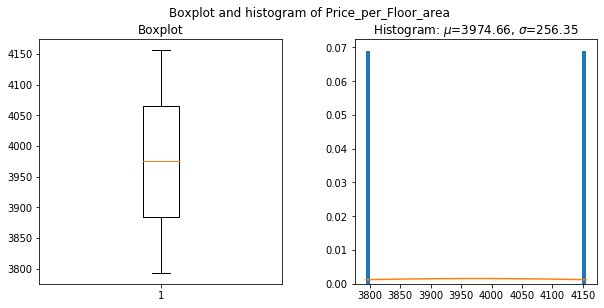

count       2.00
mean     3974.66
std       256.35
min      3793.39
5%       3811.52
25%      3884.03
50%      3974.66
75%      4065.30
95%      4137.81
max      4155.93
Name: Price_per_Floor_area, dtype: float64
O1: 3612.13; O3: 4337.20
SKOTNIKI


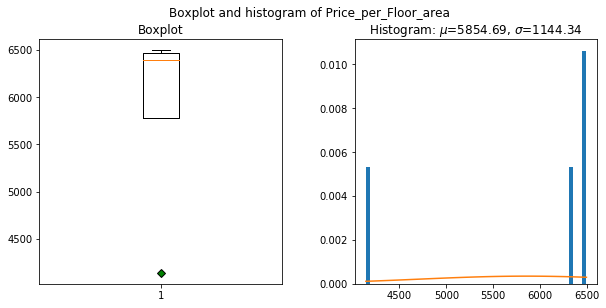

count       4.00
mean     5854.69
std      1144.34
min      4141.62
5%       4469.30
25%      5780.04
50%      6390.41
75%      6465.06
95%      6490.06
max      6496.31
Name: Price_per_Floor_area, dtype: float64
O1: 4752.51; O3: 7492.60


In [319]:
# Remove outliers, inspect every Municipal_district separately
for value in df[('Old_district')].unique():
    print(value)
    
    df_group = df[[col_name]][df['Old_district'] == value]
    plot_boxplot_histogram(df=df_group, column_name=col_name)
    
    O1, O3 = get_O1_O3(df_group, col_name)
    print('O1: {:.2f}; O3: {:.2f}'.format(O1, O3))
    
    # Remove outliers
    labels = df_group[col_name][df_group[col_name] < O1].index
    df.drop(labels=labels, inplace=True)

    # Remove outliers
    labels = df_group[col_name][df_group[col_name] > O3].index
    df.drop(labels=labels, inplace=True)
    
    df.reset_index(drop=True, inplace=True)

In [320]:
df.reset_index(drop=True, inplace=True)

###### Visualization after removing outliers

In [321]:
plot_boxplot_histogram(df=df, column_name=col_name)

count    55995.00
mean      7668.46
std       1545.21
min       3747.25
5%        5476.26
25%       6601.86
50%       7509.65
75%       8481.58
95%      10585.42
max      14393.23
Name: Price_per_Floor_area, dtype: float64


###### Transform using log function

In [322]:
df[col_name] = df[col_name].transform(np.log)

### Feature: Floor_area

#### Data Cleaning: Removing outliers

In [323]:
col_name='Floor_area'

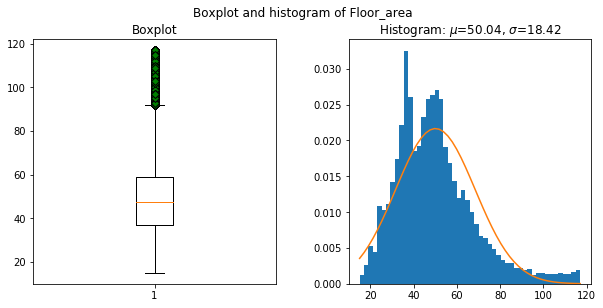

count    55995.00
mean        50.04
std         18.42
min         15.00
5%          25.21
25%         36.89
50%         47.64
75%         58.90
95%         86.34
max        117.00
Name: Floor_area, dtype: float64


In [324]:
plot_boxplot_histogram(df=df, column_name=col_name)

In [325]:
df_o1, df_o3 = get_plot_outliers_o1_o3(df=df, column_name=col_name, plot=False)

Percent of O1 outliers: 0.00%
Percent of O3 outliers: 3.82%
O3 outliers statistics:
count    2139.00
mean      104.10
std         7.60
min        91.93
50%       104.00
max       117.00
Name: Floor_area, dtype: float64


In [326]:
O1, O3 = get_O1_O3(df, col_name)
print('O1: {:.2f}; O3: {:.2f}'.format(O1, O3))

O1: 3.88; O3: 91.91


##### Conclusion:
Continuous Probability Distributions: normal distribution, right skewnes.

It was decided to transform data by using log function

##### Transform data using log function

In [327]:
df[col_name] = df[col_name].transform(np.log)

### Feature:Old_district

#### Data Transformation: transforming categorical variables to numeric variables
The variables Old_district are categorical variables. SVR can only handle numeric values and so we need to create a new variable (dummy variable) for every unique value of the categorical variables.

In [328]:
df_dummies = pd.get_dummies(df.Old_district , prefix='Old_District_', columns='Old_district', drop_first=False )
df_dummies.head()

Old_District__BIENCZYCE  Old_District__BIEŻANÓW  \
0                        0                       0   
1                        0                       0   
2                        0                       0   
3                        0                       0   
4                        0                       0   

   Old_District__BOREK FAŁĘCKI  Old_District__BRONOWICE WIELKIE  \
0                            0                                0   
1                            0                                0   
2                            0                                0   
3                            0                                0   
4                            0                                0   

   Old_District__CZYZYNY  Old_District__DĘBNIKI  Old_District__GRZEGÓRZKI  \
0                      0                      0                         0   
1                      0                      0                         0   
2                      0                      0                         0   
3                      0                      0                         0   
4                      0                      0                         0   

   Old_District__KAZIMIERZ  Old_District__KROWODRZA  \
0                        0                        0   
1                        0                        0   
2                        0                        0   
3                        0                        0   
4                        0                        0   

   Old_District__KROWODRZA GORKA  ...  Old_District__STARE PODGÓRZE  \
0                              0  ...                             0   
1                              0  ...                             0   
2                              0  ...                             0   
3                              0  ...                             0   
4                              0  ...                             0   

   Old_District__STARY PROKOCIM  Old_District__SWOSZOWICE  \
0                             0                         0   
1                             0                         0   
2                             0                         0   
3                             0                         0   
4                             0                         0   

   Old_District__TONIE  Old_District__TYNIEC  Old_District__WOLA DUCHACKA  \
0                    0                     0                            0   
1                    0                     0                            0   
2                    0                     0                            0   
3                    0                     0                            0   
4                    0                     0                            0   

   Old_District__WOLA JUSTOWSKA  Old_District__WZGORZA KRZESLAWICKIE  \
0                             0                                    0   
1                             0                                    0   
2                             0                                    0   
3                             0                                    0   
4                             0                                    0   

   Old_District__ŁAGIEWNIKI  Old_District__ŁOBZÓW  
0                         0                     0  
1                         0                     0  
2                         0                     0  
3                         0                     0  
4                         0                     0  

[5 rows x 39 columns]

In [329]:
df = pd.concat( [df, df_dummies] , axis=1 )

In [330]:
df.head(1)

Time      Admin_district  Geodesic_precinct   Old_district  Location  \
0   124  Kraków - Krowodrza                 43  PRĄDNIK BIAŁY        31   

   Transaction_price  Floor_area  Price_per_Floor_area  \
0           180000.0    3.367296              8.963132   

   Year_of_construction_class  Floor  ...  Old_District__STARE PODGÓRZE  \
0                           3      3  ...                             0   

   Old_District__STARY PROKOCIM  Old_District__SWOSZOWICE  \
0                             0                         0   

   Old_District__TONIE  Old_District__TYNIEC  Old_District__WOLA DUCHACKA  \
0                    0                     0                            0   

   Old_District__WOLA JUSTOWSKA  Old_District__WZGORZA KRZESLAWICKIE  \
0                             0                                    0   

   Old_District__ŁAGIEWNIKI  Old_District__ŁOBZÓW  
0                         0                     0  

[1 rows x 55 columns]

In [331]:
df.columns

Index(['Time', 'Admin_district', 'Geodesic_precinct', 'Old_district',
       'Location', 'Transaction_price', 'Floor_area', 'Price_per_Floor_area',
       'Year_of_construction_class', 'Floor', 'Building_height',
       'Standard_of_flat', 'Market_type', 'Number_of_rooms',
       'Kitchen_separate', 'Extra_room', 'Old_District__BIENCZYCE',
       'Old_District__BIEŻANÓW', 'Old_District__BOREK FAŁĘCKI',
       'Old_District__BRONOWICE WIELKIE', 'Old_District__CZYZYNY',
       'Old_District__DĘBNIKI', 'Old_District__GRZEGÓRZKI',
       'Old_District__KAZIMIERZ', 'Old_District__KROWODRZA',
       'Old_District__KROWODRZA GORKA', 'Old_District__MISTRZEJOWICE',
       'Old_District__MYDLNIKI', 'Old_District__OLSZA',
       'Old_District__OLSZANICA', 'Old_District__OPATKOWICE',
       'Old_District__PIERWSZA OBWODNICA', 'Old_District__PROKOCIM',
       'Old_District__PRZYLASEK', 'Old_District__PRĄDNIK BIAŁY',
       'Old_District__PRĄDNIK CZERWONY', 'Old_District__PYCHOWICE',
       'Old_Dis

In [332]:
# Use only M_District_.... as a spatial/location feature
df.drop(columns=['Time', 'Admin_district', 'Geodesic_precinct', 'Old_district', 'Location', 'Transaction_price'], inplace=True)

# OUTPUT
## DF_OUTPUT_IV3
- Price_per_Floor_area is:
    - smoothed by trend
    - outliers are removed
    - transformed by log function to remove right skewnes
- Floor_are is:
    - transformed by log function to remove right skewnes
- Features are selected

In [333]:
DF_OUTPUT_IV3 = df.copy()

# IV.4. Data Modeling

# Model number IV.A
## SVR

In [334]:
df = DF_OUTPUT_IV3.copy()

### Splitting data into input and output (data and target)

In [335]:
X_df = df.drop(columns=['Price_per_Floor_area'], inplace=False) # input; deep copy of columns 
Y_df = df[['Price_per_Floor_area']] # output

### Data Transformation: Rescale Data
### Normalize data 
Data were rescaled using normalization, MinMax techniqe. It means that the data were rescaled to lie between 0 and 1. It brings all the values of numeric columns in the dataset to a common scale.

In [336]:
# get a set of values from original dataset
X = X_df.values

# normalized data
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [337]:
# Cache input and output data as dataframe
X_df = pd.DataFrame.from_records(X, columns=X_df.columns) # Create dataframe of from normalized data

# Test: display first instance
X_df.head(1)

Floor_area  Year_of_construction_class  Floor  Building_height  \
0    0.320938                         0.5  0.375              1.0   

   Standard_of_flat  Market_type  Number_of_rooms  Kitchen_separate  \
0               0.5          0.0              0.0               1.0   

   Extra_room  Old_District__BIENCZYCE  ...  Old_District__STARE PODGÓRZE  \
0         0.0                      0.0  ...                           0.0   

   Old_District__STARY PROKOCIM  Old_District__SWOSZOWICE  \
0                           0.0                       0.0   

   Old_District__TONIE  Old_District__TYNIEC  Old_District__WOLA DUCHACKA  \
0                  0.0                   0.0                          0.0   

   Old_District__WOLA JUSTOWSKA  Old_District__WZGORZA KRZESLAWICKIE  \
0                           0.0                                  0.0   

   Old_District__ŁAGIEWNIKI  Old_District__ŁOBZÓW  
0                       0.0                   0.0  

[1 rows x 48 columns]

#### Statistical description of normalized data
Data were normalized using MinMax technique.
- expected: min = 0, max = 0
- mean do not need to be 0 and standad deviation do not need to be 1

In [338]:
df_desc=X_df.describe()
df_desc.loc[['min', 'max', 'mean', 'std']]

Floor_area  Year_of_construction_class     Floor  Building_height  \
min     0.000000                    0.000000  0.000000         0.000000   
max     1.000000                    1.000000  1.000000         1.000000   
mean    0.555226                    0.361907  0.329317         0.499098   
std     0.175029                    0.313275  0.242992         0.500004   

      Standard_of_flat  Market_type  Number_of_rooms  Kitchen_separate  \
min           0.000000     0.000000         0.000000          0.000000   
max           1.000000     1.000000         1.000000          1.000000   
mean          0.624172     0.363354         0.374789          0.556710   
std           0.369675     0.480970         0.284208          0.496778   

      Extra_room  Old_District__BIENCZYCE  ...  Old_District__STARE PODGÓRZE  \
min     0.000000                 0.000000  ...                      0.000000   
max     1.000000                 1.000000  ...                      1.000000   
mean    0.000214                 0.031038  ...                      0.027842   
std     0.014638                 0.173423  ...                      0.164521   

      Old_District__STARY PROKOCIM  Old_District__SWOSZOWICE  \
min                       0.000000                  0.000000   
max                       1.000000                  1.000000   
mean                      0.001679                  0.008519   
std                       0.040938                  0.091903   

      Old_District__TONIE  Old_District__TYNIEC  Old_District__WOLA DUCHACKA  \
min              0.000000              0.000000                     0.000000   
max              1.000000              1.000000                     1.000000   
mean             0.017662              0.000518                     0.056773   
std              0.131722              0.022752                     0.231410   

      Old_District__WOLA JUSTOWSKA  Old_District__WZGORZA KRZESLAWICKIE  \
min                       0.000000                             0.000000   
max                       1.000000                             1.000000   
mean                      0.013769                             0.011947   
std                       0.116532                             0.108651   

      Old_District__ŁAGIEWNIKI  Old_District__ŁOBZÓW  
min                   0.000000              0.000000  
max                   1.000000              1.000000  
mean                  0.019805              0.068167  
std                   0.139332              0.252034  

[4 rows x 48 columns]

#### Data Reduction: Feature selection: PCA
PCA technique (Principal Component Analysis)
- automatically select the features that contribut best to prediction
- allows to reduce dimentionality

It is necessary to normalize data before performing PCA (data are already normalized)

In [339]:
#X = X_df.values

In [340]:
#pca = PCA(n_components=6)
#pca.fit(X) # Fit the model with X

In [341]:
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

# summarize components
#print("Explained Variance: %s" % pca.explained_variance_ratio_)
#print(pca.components_)

In [342]:
#X = pca.transform(X) # Apply dimensionality reduction to X

In [343]:
# Cache output data after this stage
#X_df = pd.DataFrame.from_records(X)
#Y_df = Y_df

### Model: Regression: SVR(kernel='linear')

### Document Choice:
- there is more than 50 instances
- data taget is not categorical
- data target describes quantity (number)
- there is less than 100k instances
- all feature should be important
- use SVR(kernel='linear')

In [344]:
# Input Data
X = X_df.values
y = Y_df.values.flatten()

In [345]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Train data 

In [346]:
# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py
regressor = SVR(kernel='linear', C=1, gamma='auto')

model = regressor.fit(X_train, y_train)

#### Evaluate model

In [347]:
y_predicted = model.predict(X_test)

In [348]:
# transform from log
y_test = np.exp(y_test)
y_predicted = np.exp(y_predicted)

In [349]:
# value of Y_predict
y_predicted[0]

9876.997781177954

In [350]:
# actual value
y_test[0]

12244.046670107366

In [351]:
s_predicted = pd.Series(y_predicted, name='Predicted output')
s_target = pd.Series(y_test, name='Target output')

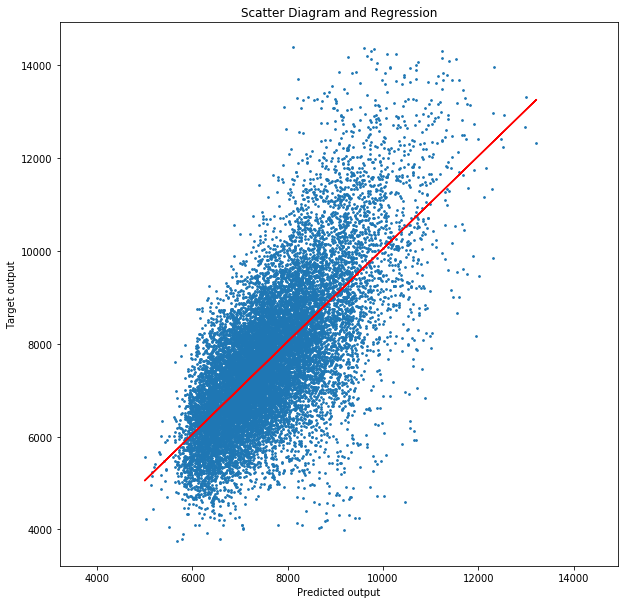

In [352]:
# plot scatter diagram to visualize how well data were predicted
scatter_regression(s_X=s_predicted, s_Y=s_target, same_scale=True)

In [353]:
# Calculate Pearson Correlation Coeficient, the closer to 1 the better
r_pearson_coef, p = pearsonr(y_predicted, y_test)
print('Pearson Correlation Coeficient: {:.2f}, P-value: {}'.format(r_pearson_coef, p))

Pearson Correlation Coeficient: 0.69, P-value: 0.0


In [354]:
s_predicted.describe()

count    16799.000000
mean      7627.696737
std       1070.354781
min       4997.309522
25%       6843.714710
50%       7485.194255
75%       8252.132368
max      13220.328431
Name: Predicted output, dtype: float64

In [355]:
s_target.describe()

count    16799.000000
mean      7674.653499
std       1550.779936
min       3747.249506
25%       6602.597952
50%       7502.086468
75%       8476.732164
max      14393.225435
Name: Target output, dtype: float64

### Conclusion
- positive correlation coefficient
- The Pearson's correlation coefficient droped. Probably data had too many outliers before PCA
- It took short long to train data
- There are many outliers. It should be corrected.

# Model number IV.B
## DecisionTree

In [356]:
df = DF_OUTPUT_IV3.copy()

#### Split data into input and output (data and target)

In [357]:
X_df = df.drop(columns=['Price_per_Floor_area'], inplace=False) # input; deep copy of columns 
y_df = df[['Price_per_Floor_area']] # output

In [358]:
# Input Data
X = X_df.values
y = y_df.values.flatten()

In [359]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Train data 

In [360]:
regressor = DecisionTreeRegressor()
model = regressor.fit(X_train, y_train)

#### Evaluate model

In [361]:
y_predicted = model.predict(X_test)

In [362]:
# transform from log
y_test = np.exp(y_test)
y_predicted = np.exp(y_predicted)

In [363]:
# value of Y_predict
y_predicted[0]

6201.6439032714425

In [364]:
# actual value
y_test[0]

7331.397121691524

In [365]:
s_predicted = pd.Series(y_predicted, name='Predicted output')
s_target = pd.Series(y_test, name='Target output')

In [366]:
# plot scatter diagram to visualize how well data were predicted
scatter_regression(s_X=s_predicted, s_Y=s_target, same_scale=True)

In [367]:
# Calculate Pearson Correlation Coeficient, the closer to 1 the better
r_pearson_coef, p = pearsonr(y_predicted, y_test)
print('Pearson Correlation Coeficient: {:.2f}, P-value: {}'.format(r_pearson_coef, p))

Pearson Correlation Coeficient: 0.56, P-value: 0.0


In [368]:
s_predicted.describe()

count    16799.000000
mean      7655.559719
std       1570.933862
min       3787.442342
25%       6563.492485
50%       7482.420872
75%       8456.932895
max      14393.225435
Name: Predicted output, dtype: float64

In [369]:
s_target.describe()

count    16799.000000
mean      7666.258196
std       1531.902699
min       3747.249506
25%       6609.800283
50%       7518.430964
75%       8465.257300
max      14336.089429
Name: Target output, dtype: float64

### Conclusion
- positive correlation coefficient
- The Pearson's correlation coefficient droped. Probably data had too many outliers before PCA
- It took short long to train data
- There are many outliers. It should be corrected.

# <center>---------------------- END -------------------------</center>